# CONNECTOME ANALYSIS OF StN_SA PATHWAYS

## This code is moslty based on the analyses in Walker et al.

### The code is organized into sections focused on StN_SAs, 2Ns, 3Ns, etc.,. with several types of analysis in each section.

This workflow is on the second set/cluster naming convention we came up with for the StN_SAs

### First, import packages and set default plotting parameters

In [1]:
#from StN_SAs_Activation import set_1
#%pip install statsmodels

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.optimize import curve_fit
from venn import venn
import seaborn as sns
from matplotlib.colors import LogNorm
import statsmodels.api as sm

In [ ]:
# Set seaborn theme to white
sns.set_theme(style='white')

# set up matplot lib theme
andy_theme = {'axes.grid': False,
              'grid.linestyle': '--',
              'legend.framealpha': 1,
              'legend.facecolor': 'white',
              'legend.shadow': False,
              'legend.fontsize': 14,
              'legend.title_fontsize': 14,
              'font.sans-serif':'Helvetica',
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'axes.labelsize': 12,
              'axes.titlesize': 16,
              'figure.dpi': 300}

plt.rcParams.update(andy_theme)

#Uncomment next 2 lines if matplotlib can not find Helvetica font
#plt.rcParams['font.family'] = 'DeJavu Serif'
#plt.rcParams['font.sans-serif'] = ['Arial']

## 1. FIRST ORDER ANALYSES

### Load the datasets with neurons and connections.

* This script assumes that the **CSV** files (`.csv.gz`) and **StN_SAs lists** (`_new.csv` files) are in the same folder as this notebook or script.
* These files include four CSVs containing manually curated StN_SAs lists and connectome datasets from FlyWire:
  1. **`classification.csv.gz`**
  2. **`connections.csv.gz`**
  3. **`neuropil_synapse_table.csv.gz`**
  4. **`neurons.csv.gz`**
* **Axon lists** were curated manually as described in the paper.
* **Connectome datasets** were downloaded from the FlyWire website using **snapshot 783** (previous snapshot 630).
* We focus on putative sensory axons from the Drosophila **pharyngeal/stomodeal nerve** in this analysis.


In [ ]:
# Connections dataset and additional data sets

# Load the connections dataset
# columns: pre_root_id, post_root_id, neuropil, syn_count, nt_type
connections = pd.read_csv('/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/Drosophila_brain_model/connections.csv.gz')

# Neuropil synapses
# columns: root_id, input synapses, input partners, output synapses, output partners, etc
# Keep only root_id, input syanapses, output synapses
neuropil_synapse = pd.read_csv('/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/Drosophila_brain_model/neuropil_synapse_table.csv.gz')[['root_id','input synapses','output synapses']]

# Rename with underscores
neuropil_synapse.rename(columns={'input synapses': 'input_synapses','output synapses': 'output_synapses'}, inplace=True)

# Load classification table
# columns: root_id, flow, super_class, side, etc
# Keep only root_id and side
classification = pd.read_csv('/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/Drosophila_brain_model/classification.csv.gz')[['root_id','side']]
classification_other = pd.read_csv('/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/Drosophila_brain_model/classification.csv.gz')[['root_id','super_class', 'class']]

# Load data about each neuron
# columns: root_id, group, nt_type, etc
# Keep only root_id, nt_type
neurons = pd.read_csv('/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/Drosophila_brain_model/neurons.csv.gz')[['root_id','nt_type']]

# Merging additional data in one data set
neurons_data = pd.merge(neurons, pd.merge(classification, neuropil_synapse, on='root_id',how= 'outer'), on='root_id',how='outer')

# Load putative PSA lists
set_1 = pd.read_csv('/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_1.csv')
set_2 = pd.read_csv('/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_2.csv')
set_3 = pd.read_csv('/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_3.csv')
set_4 = pd.read_csv('/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_4.csv')
set_5 = pd.read_csv('/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_5.csv')
set_6 = pd.read_csv('/Users/yaolab/Downloads/taste-connectome-main/PhN-SA_v2/set_6.csv')

### Find downstream connections of StN_SAs
- includes all neurons downstream of StN_SAs - we will filter out set-set connections later
- minimum of 5 synapses between the two neurons

# Define function to get outputs of StN_SAs, Walker et al method
def neuronal_outputs(StNSA):
    # Merge the StN_SA DataFrame with the 'connections' data, filtering out any connections
    # that have fewer than 5 synapses
    connectivity = pd.merge(
        StN_SA['root_id'],
        connections[['pre_root_id','post_root_id','neuropil','syn_count','nt_type']],
        left_on='root_id',
        right_on='pre_root_id',
        how='inner'
    ).query("syn_count >= 5")

    # Remove the temporary 'root_id' column that came from the StN_SA DataFrame
    connectivity = connectivity.drop(columns='root_id')

    # Define function to categorize connection location
    def projection(neuropil):
        if neuropil in ['GNG', 'PRW', 'SAD', 'FLA_L', 'FLA_R', 'CAN']:  # Example SEZ-related regions
            return 'local'
        else:
            return 'outside_SEZ'

    # Apply the projection categorization to each row in 'connectivity'
    connectivity['location_of_connection'] = connectivity['neuropil'].apply(projection)

    return connectivity

In [ ]:
### Find downstream connections of StN_SAs (FlyWire ≥5 synapses per pair)

# Define function to get outputs of StN_SAs using pair-level thresholding
def neuronal_outputs(StN_SA):
    # 1) merge once to collect all synapse rows for each StN_SA
    df = pd.merge(
        StN_SA[['root_id']],
        connections[['pre_root_id', 'post_root_id', 'neuropil', 'syn_count', 'nt_type']],
        left_on='root_id',
        right_on='pre_root_id',
        how='inner'
    ).drop(columns='root_id')

    # 2) sum across every (pre, post) pair, then keep pairs with total ≥ 5
    summed = (
        df
        .groupby(['pre_root_id', 'post_root_id'], as_index=False)
        .agg({'syn_count': 'sum'})
        .query('syn_count >= 5')
    )

    # 3) re-attach a representative neuropil & nt_type for each surviving pair
    strongest = (
        df.loc[df.groupby(['pre_root_id', 'post_root_id'])['syn_count'].idxmax()]
        [['pre_root_id', 'post_root_id', 'neuropil', 'nt_type']]
    )
    connectivity = pd.merge(summed, strongest, on=['pre_root_id', 'post_root_id'], how='left')

    # 4) tag local vs outside_SEZ
    def projection(neu):
        return 'local' if neu in ['GNG', 'PRW', 'SAD', 'FLA_L', 'FLA_R', 'CAN'] else 'outside_SEZ'

    connectivity['location_of_connection'] = connectivity['neuropil'].apply(projection)

    return connectivity


In [ ]:
sets_list = [set_1, set_2, set_3, set_4, set_5, set_6]

In [ ]:
for i, df in enumerate(sets_list, start=1):
    globals()[f'set_{i}_outputs'] = neuronal_outputs(df)

In [ ]:
# Get the outputs for each set of StN_SAs
set_1_outputs = neuronal_outputs(set_1)
set_2_outputs = neuronal_outputs(set_2)
set_3_outputs = neuronal_outputs(set_3)
set_4_outputs = neuronal_outputs(set_4)
set_5_outputs = neuronal_outputs(set_5)
set_6_outputs = neuronal_outputs(set_6)

In [ ]:
# (hypothesis: row-level >=5 lets one “false positive” through)

# 1. Row-level thresholding exactly as in neuronal_outputs()
orig_outputs = (
    pd.merge(
        set_1[['root_id']],
        connections[['pre_root_id', 'post_root_id', 'syn_count']],
        left_on='root_id', right_on='pre_root_id', how='inner'
    )
    .query('syn_count >= 5')
)
orig_ids = set(orig_outputs['post_root_id'].unique())

# 2. Sum-then-threshold approach
sum_outputs = (
    pd.merge(
        set_1[['root_id']],
        connections[['pre_root_id', 'post_root_id', 'syn_count']],
        left_on='root_id', right_on='pre_root_id', how='inner'
    )
    .groupby(['pre_root_id', 'post_root_id'], as_index=False)
    .agg({'syn_count': 'sum'})
    .query('syn_count >= 5')
)
sum_ids = set(sum_outputs['post_root_id'].unique())

# 3. Print out counts and any mismatches
print(f"Row-level unique downstream IDs: {len(orig_ids)}")
print(f"Summed-synapses unique downstream IDs: {len(sum_ids)}")
print("In row-level only :", orig_ids - sum_ids)
print("In summed only    :", sum_ids - orig_ids)


In [ ]:
set_1

In [ ]:
sum_ids

### Quantifying StN_SA to StN_SA communication
# This creates a heatmap showing the number of synapses between each set of pharyngeal sensory axons.

In [1]:
def StN_SA_heatmap_matrix(outputs_list, sets_list):
    """
    Given a list of DataFrames representing the outputs of each StN_SA set
    (e.g., set_1_outputs, set_2_outputs, etc.) and a list of DataFrames of the
    actual sets (e.g., set_1, set_2, ...), return an NxN matrix where
    matrix[i, j] is the sum of 'syn_count' from set i to set j.
    """
    n = len(sets_list)
    syn_matrix = np.zeros((n, n), dtype=int)
    for i, out_df in enumerate(outputs_list):
        for j, set_df in enumerate(sets_list):
            merged = pd.merge(
                out_df,
                set_df,
                left_on='post_root_id',
                right_on='root_id',
                how='inner'
            )
            syn_matrix[i, j] = merged['syn_count'].sum()
    return syn_matrix

# 1) Gather your original DataFrames into a list
sets_list = [globals()[f"set_{i}"] for i in range(1, 7)]
#    —> In another notebook, you might do: sets_list = [aPhN1, aPhN2, DCSO]

# 2) Compute first-order outputs for each set
for i, df in enumerate(sets_list, start=1):
    globals()[f"set_{i}_outputs"] = neuronal_outputs(df)

# 3) Prepare the inputs for the heatmap
n = len(sets_list)
all_sets    = sets_list
all_outputs = [globals()[f"set_{i}_outputs"] for i in range(1, n+1)]

# 4) Build dynamic labels
labels     = [f"Set {i}" for i in range(1, n+1)]
row_labels = labels
col_labels = labels

# 5) Compute the synapse matrix
syn_matrix = StN_SA_heatmap_matrix(all_outputs, all_sets)

# 6) Plot
plt.figure(figsize=(6,5))
sns.heatmap(
    syn_matrix,
    cmap='viridis',
    annot=True,
    fmt="d",
    xticklabels=col_labels,
    yticklabels=row_labels,
    square=True,
    vmin=0
)
plt.title("Set-to-Set Synapses", fontsize=18)
plt.ylabel("Upstream Set", fontsize=14)
plt.xlabel("Downstream Set", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Optionally save
plt.savefig('/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/General - YaoLabUF/SVG_figs/Fig2/syncount1n.svg', bbox_inches='tight')
plt.show()


KeyError: 'set_1'

## 2. SECOND ORDER NEURON ANALYSES

## 2a. Identify 2Ns and their connections and organize the data

### Define and run a function to identify second order neurons (2Ns)
- neuron must be downstream of StN_SAs
- minimum of 5 synapses between the two neurons
- we will filter out StN_SAs from the list later

In [13]:
# Define function
def second_order(StN_SA, set_label):
    """
    Given a set of pharyngeal sensory axons (StN_SAs) with a 'root_id' column,
    this function extracts the connectivity (filtered for syn_count >= 5) and
    aggregates it to yield second-order outputs.

    Parameters:
        StN_SA : pd.DataFrame
            DataFrame containing a column 'root_id' for the StN_SAs.
        set_label : str
            A label (e.g., 'set_1', 'set_2', etc.) used to annotate the output columns.

    Returns:
        connectivity : pd.DataFrame
            DataFrame containing the filtered connectivity data.
        second_orders : pd.DataFrame
            Aggregated connectivity DataFrame with:
              - 'root_id': post-synaptic neuron ID,
              - 'upstream_<set_label>_StN_SAs': count of unique upstream StN_SAs,
              - '<set_label>_syn_count': total synapse count,
              - 'const': constant column for OLS regression.
    """
    # Get connectivity from StN_SAs
    connectivity = pd.merge(
        StN_SA['root_id'],
        connections[['pre_root_id', 'post_root_id', 'neuropil', 'syn_count', 'nt_type']],
        left_on='root_id',
        right_on='pre_root_id',
        how='inner'
    ).query("syn_count >= 5")

    connectivity = connectivity.drop(columns='root_id')

    # Aggregate connectivity to obtain second-order outputs
    second_orders = connectivity.groupby("post_root_id").agg({
        'pre_root_id': 'nunique',
        'syn_count': 'sum'
    }).reset_index()

    second_orders.columns = ['root_id', 'upstream_' + set_label + '_StN_SAs', set_label + '_syn_count']
    second_orders['const'] = 1  # For OLS regression later

    return connectivity, second_orders


## 2. SECOND ORDER NEURON ANALYSES
## 2a. Identify 2Ns and their connections and organize the data

### Define and run a function to identify second order neurons (2Ns)
- neuron
must
be
downstream
of
StN_SAs(FlyWire ≥5
synapses
per
pair)
- we
will
filter
out
StN_SAs
from the list later

In [14]:
## 2. SECOND ORDER NEURON ANALYSES
## 2a. Identify 2Ns and their connections and organize the data

### Define and run a function to identify second order neurons (2Ns)
#  - neuron must be downstream of StN_SAs (FlyWire ≥5 synapses per pair)
#  - we will filter out StN_SAs from the list later
def second_order(StN_SA, set_label):
    """
    Given a set of StN_SAs (column 'root_id'), this function:
      1) merges with connections,
      2) sums synapses per (pre, post) pair and keeps pairs with total ≥ 5,
      3) re-attaches representative neuropil & nt_type,
      4) aggregates to yield second-order outputs.

    Returns:
      connectivity : DataFrame of filtered pairwise connections
      second_orders : DataFrame with columns
        - 'root_id': post-synaptic neuron ID
        - 'upstream_<set_label>_StN_SAs': count of unique upstream StN_SAs
        - '<set_label>_syn_count': total synapses from that set
        - 'const': constant = 1 for OLS
    """
    # 1) collect all rows for this set
    df = pd.merge(
        StN_SA[['root_id']],
        connections[['pre_root_id', 'post_root_id', 'neuropil', 'syn_count', 'nt_type']],
        left_on='root_id', right_on='pre_root_id', how='inner'
    ).drop(columns='root_id')

    # 2) sum & threshold at the pair level
    summed = (
        df
        .groupby(['pre_root_id', 'post_root_id'], as_index=False)
        .agg({'syn_count': 'sum'})
        .query('syn_count >= 5')
    )

    # 3) pull in a representative neuropil & nt_type row
    strongest = (
        df.loc[df.groupby(['pre_root_id', 'post_root_id'])['syn_count'].idxmax()]
        [['pre_root_id', 'post_root_id', 'neuropil', 'nt_type']]
    )
    connectivity = pd.merge(summed, strongest, on=['pre_root_id', 'post_root_id'], how='left')

    # 4) aggregate per post_root_id
    second_orders = (
        connectivity
        .groupby('post_root_id')
        .agg({
            'pre_root_id': 'nunique',
            'syn_count': 'sum'
        })
        .reset_index()
    )
    second_orders.columns = [
        'root_id',
        f'upstream_{set_label}_StN_SAs',
        f'{set_label}_syn_count'
    ]
    second_orders['const'] = 1

    return connectivity, second_orders

In [15]:
# Run function to get second-order connectivity and list of second-order outputs (2Ns) for each set
for i, stn_sa in enumerate(sets_list, start=1):
    conn, twoNs = second_order(stn_sa, f'set_{i}')
    globals()[f'set_{i}_second_order_connectivity'] = conn
    globals()[f'set_{i}_2Ns']                          = twoNs

In [16]:
set_1

root_id
0  720575940617034713
1  720575940604355872
2  720575940621106465
3  720575940632040749
4  720575940630434616
5  720575940625785731
6  720575940622575754
7  720575940629887695

In [17]:
# Quick sanity check
for i in range(1, n+1):
    df = globals()[f'set_{i}_2Ns']
    print(f"Set_{i} 2Ns: {df.shape[0]} rows, unique IDs: {df['root_id'].nunique()}")

Set_1 2Ns: 13 rows, unique IDs: 13
Set_2 2Ns: 87 rows, unique IDs: 87
Set_3 2Ns: 119 rows, unique IDs: 119
Set_4 2Ns: 118 rows, unique IDs: 118
Set_5 2Ns: 50 rows, unique IDs: 50
Set_6 2Ns: 76 rows, unique IDs: 76


### Getting more information about 2Ns from flywire

In [18]:
### Getting more information about 2Ns from FlyWire

# Number of sets (e.g. 6 for set_1…set_6)
n = len(sets_list)  # or hard-code 6 if you prefer

# 1) Merge metadata into each set_i_2Ns
for i in range(1, n+1):
    df = globals()[f"set_{i}_2Ns"]
    df = pd.merge(df, neurons_data, on='root_id', how='inner')
    globals()[f"set_{i}_2Ns"] = df

# 2) Quick check that we didn't drop any neurons
for i in range(1, n+1):
    df = globals()[f"set_{i}_2Ns"]
    uniq = df['root_id'].nunique()
    print(f"Set_{i} 2Ns (after merge): {uniq} unique IDs")


Set_1 2Ns (after merge): 13 unique IDs
Set_2 2Ns (after merge): 87 unique IDs
Set_3 2Ns (after merge): 119 unique IDs
Set_4 2Ns (after merge): 118 unique IDs
Set_5 2Ns (after merge): 50 unique IDs
Set_6 2Ns (after merge): 76 unique IDs



### Remove Sets from 2N lists

In [19]:
### Remove 1Ns (StN_SAs) from each 2N list, and report how many & which were dropped: Roots from set 1 may connect to other roots in set 1 and thus be catagorized as a 2nd order neuron (2N). This is to filter out those redundencies.

# 1) Build all StN_SA IDs dynamically from your list of original sets
all_StN_SA_ids = set(pd.concat(sets_list, axis=0)['root_id'])

# 2) Determine how many sets you have
n = len(sets_list)  # e.g. 6

# 3) Loop over each set_i
for i in range(1, n+1):
    twoNs = globals()[f"set_{i}_2Ns"]
    conn  = globals()[f"set_{i}_second_order_connectivity"]

    # Which 2Ns are actually 1Ns?
    original_ids = set(twoNs['root_id'])
    removed_ids  = sorted(original_ids & all_StN_SA_ids)

    # Report
    print(f"Set_{i}: Removing {len(removed_ids)} StN_SA neurons:")
    print(removed_ids or "  (none)")

    # Drop them
    clean_twoNs = twoNs[~twoNs['root_id'].isin(all_StN_SA_ids)].copy()
    clean_conn  = conn[~conn['post_root_id'].isin(all_StN_SA_ids)].copy()

    # Overwrite the globals
    globals()[f"set_{i}_2Ns"]                         = clean_twoNs
    globals()[f"set_{i}_second_order_connectivity"] = clean_conn

Set_1: Removing 0 StN_SA neurons:
  (none)
Set_2: Removing 2 StN_SA neurons:
[720575940623056422, 720575940638086256]
Set_3: Removing 1 StN_SA neurons:
[720575940633194029]
Set_4: Removing 2 StN_SA neurons:
[720575940630806267, 720575940639972816]
Set_5: Removing 1 StN_SA neurons:
[720575940622144648]
Set_6: Removing 9 StN_SA neurons:
[720575940611388595, 720575940620983637, 720575940621207517, 720575940622144648, 720575940623056422, 720575940630654539, 720575940631572141, 720575940633194029, 720575940650760825]


In [20]:
# Quick sanity check: how many 2Ns remain?
for i in range(1, 7):
    df = globals()[f'set_{i}_2Ns']
    print(f"Set_{i} final 2Ns: {df['root_id'].nunique()} unique neurons")

Set_1 final 2Ns: 13 unique neurons
Set_2 final 2Ns: 85 unique neurons
Set_3 final 2Ns: 118 unique neurons
Set_4 final 2Ns: 116 unique neurons
Set_5 final 2Ns: 49 unique neurons
Set_6 final 2Ns: 67 unique neurons


###



In [21]:
# 4) Make a DataFrame with data for all sets
# 2) Concatenate all set_{i}_2Ns, tagging each row with its origin
df_list = []
for i in range(1, n+1):
    df = globals()[f'set_{i}_2Ns'].copy()
    df['label'] = f'set_{i}'
    df_list.append(df)

all_2N = pd.concat(df_list, ignore_index=True)

# 3) Determine the dynamic column names
syn_cols = [f'set_{i}_syn_count'          for i in range(1, n+1)]
up_cols  = [f'upstream_set_{i}_StN_SAs'   for i in range(1, n+1)]

# 4) Compute total synapse counts and total upstream counts
all_2N['total_syn_count'] = all_2N[syn_cols].sum(axis=1)
all_2N['total_upstream']  = all_2N[up_cols].sum(axis=1)

# 5) Drop the per-set columns now that we have totals
all_2N = all_2N.drop(columns=syn_cols + up_cols)

# 6) Inspect the result
all_2N.head()

# all_2N now contains a combined table of second-order neurons with:
#   - Activation status at each rate, for each set
#   - Summed total syn_count across all sets
#   - Summed total of upstream sets
#   - A 'label' column that indicates which set the neuron was originally associated with

root_id  const nt_type    side  input_synapses  output_synapses  \
0  720575940606746034      1     NaN    left           267.0             84.0   
1  720575940616801622      1    GLUT   right           798.0            573.0   
2  720575940621662332      1    GLUT  center          1406.0           3275.0   
3  720575940624015287      1     ACH    left           173.0             74.0   
4  720575940625841241      1    GLUT    left           458.0            985.0   

   label  total_syn_count  total_upstream  
0  set_1            113.0             8.0  
1  set_1            221.0             8.0  
2  set_1             11.0             1.0  
3  set_1             18.0             2.0  
4  set_1             27.0             4.0

In [22]:
num_sets = 6

for i in range(1, num_sets + 1):
    # (A) grab the filtered second-order table for this set
    clean_conn = globals()[f"set_{i}_second_order_connectivity"]
    # (B) select only the three columns we need
    df_edges = clean_conn[['pre_root_id', 'post_root_id', 'syn_count']].copy()
    # (C) save to a CSV file named for this set
    df_edges.to_csv(f"set_{i}_second_order_edges.csv", index=False)


In [23]:
num_sets = 6

for i in range(1, num_sets + 1):
    # (A) grab the filtered second-order table for this set
    clean_conn = globals()[f"set_{i}_second_order_connectivity"]
    # (B) extract unique pre_root_id and unique post_root_id
    unique_pre_ids = clean_conn['pre_root_id'].unique()
    unique_post_ids = clean_conn['post_root_id'].unique()

    # (C) turn each into a one‐column DataFrame for easy export
    df_pre = pd.DataFrame({'unique_root_id': unique_pre_ids})
    df_post = pd.DataFrame({'unique_root_id': unique_post_ids})

    # (D) save each to its own CSV
    df_pre.to_csv(f"set_{i}_second_order_unique_pre_ids.csv", index=False)
    df_post.to_csv(f"set_{i}_second_order_unique_post_ids.csv", index=False)


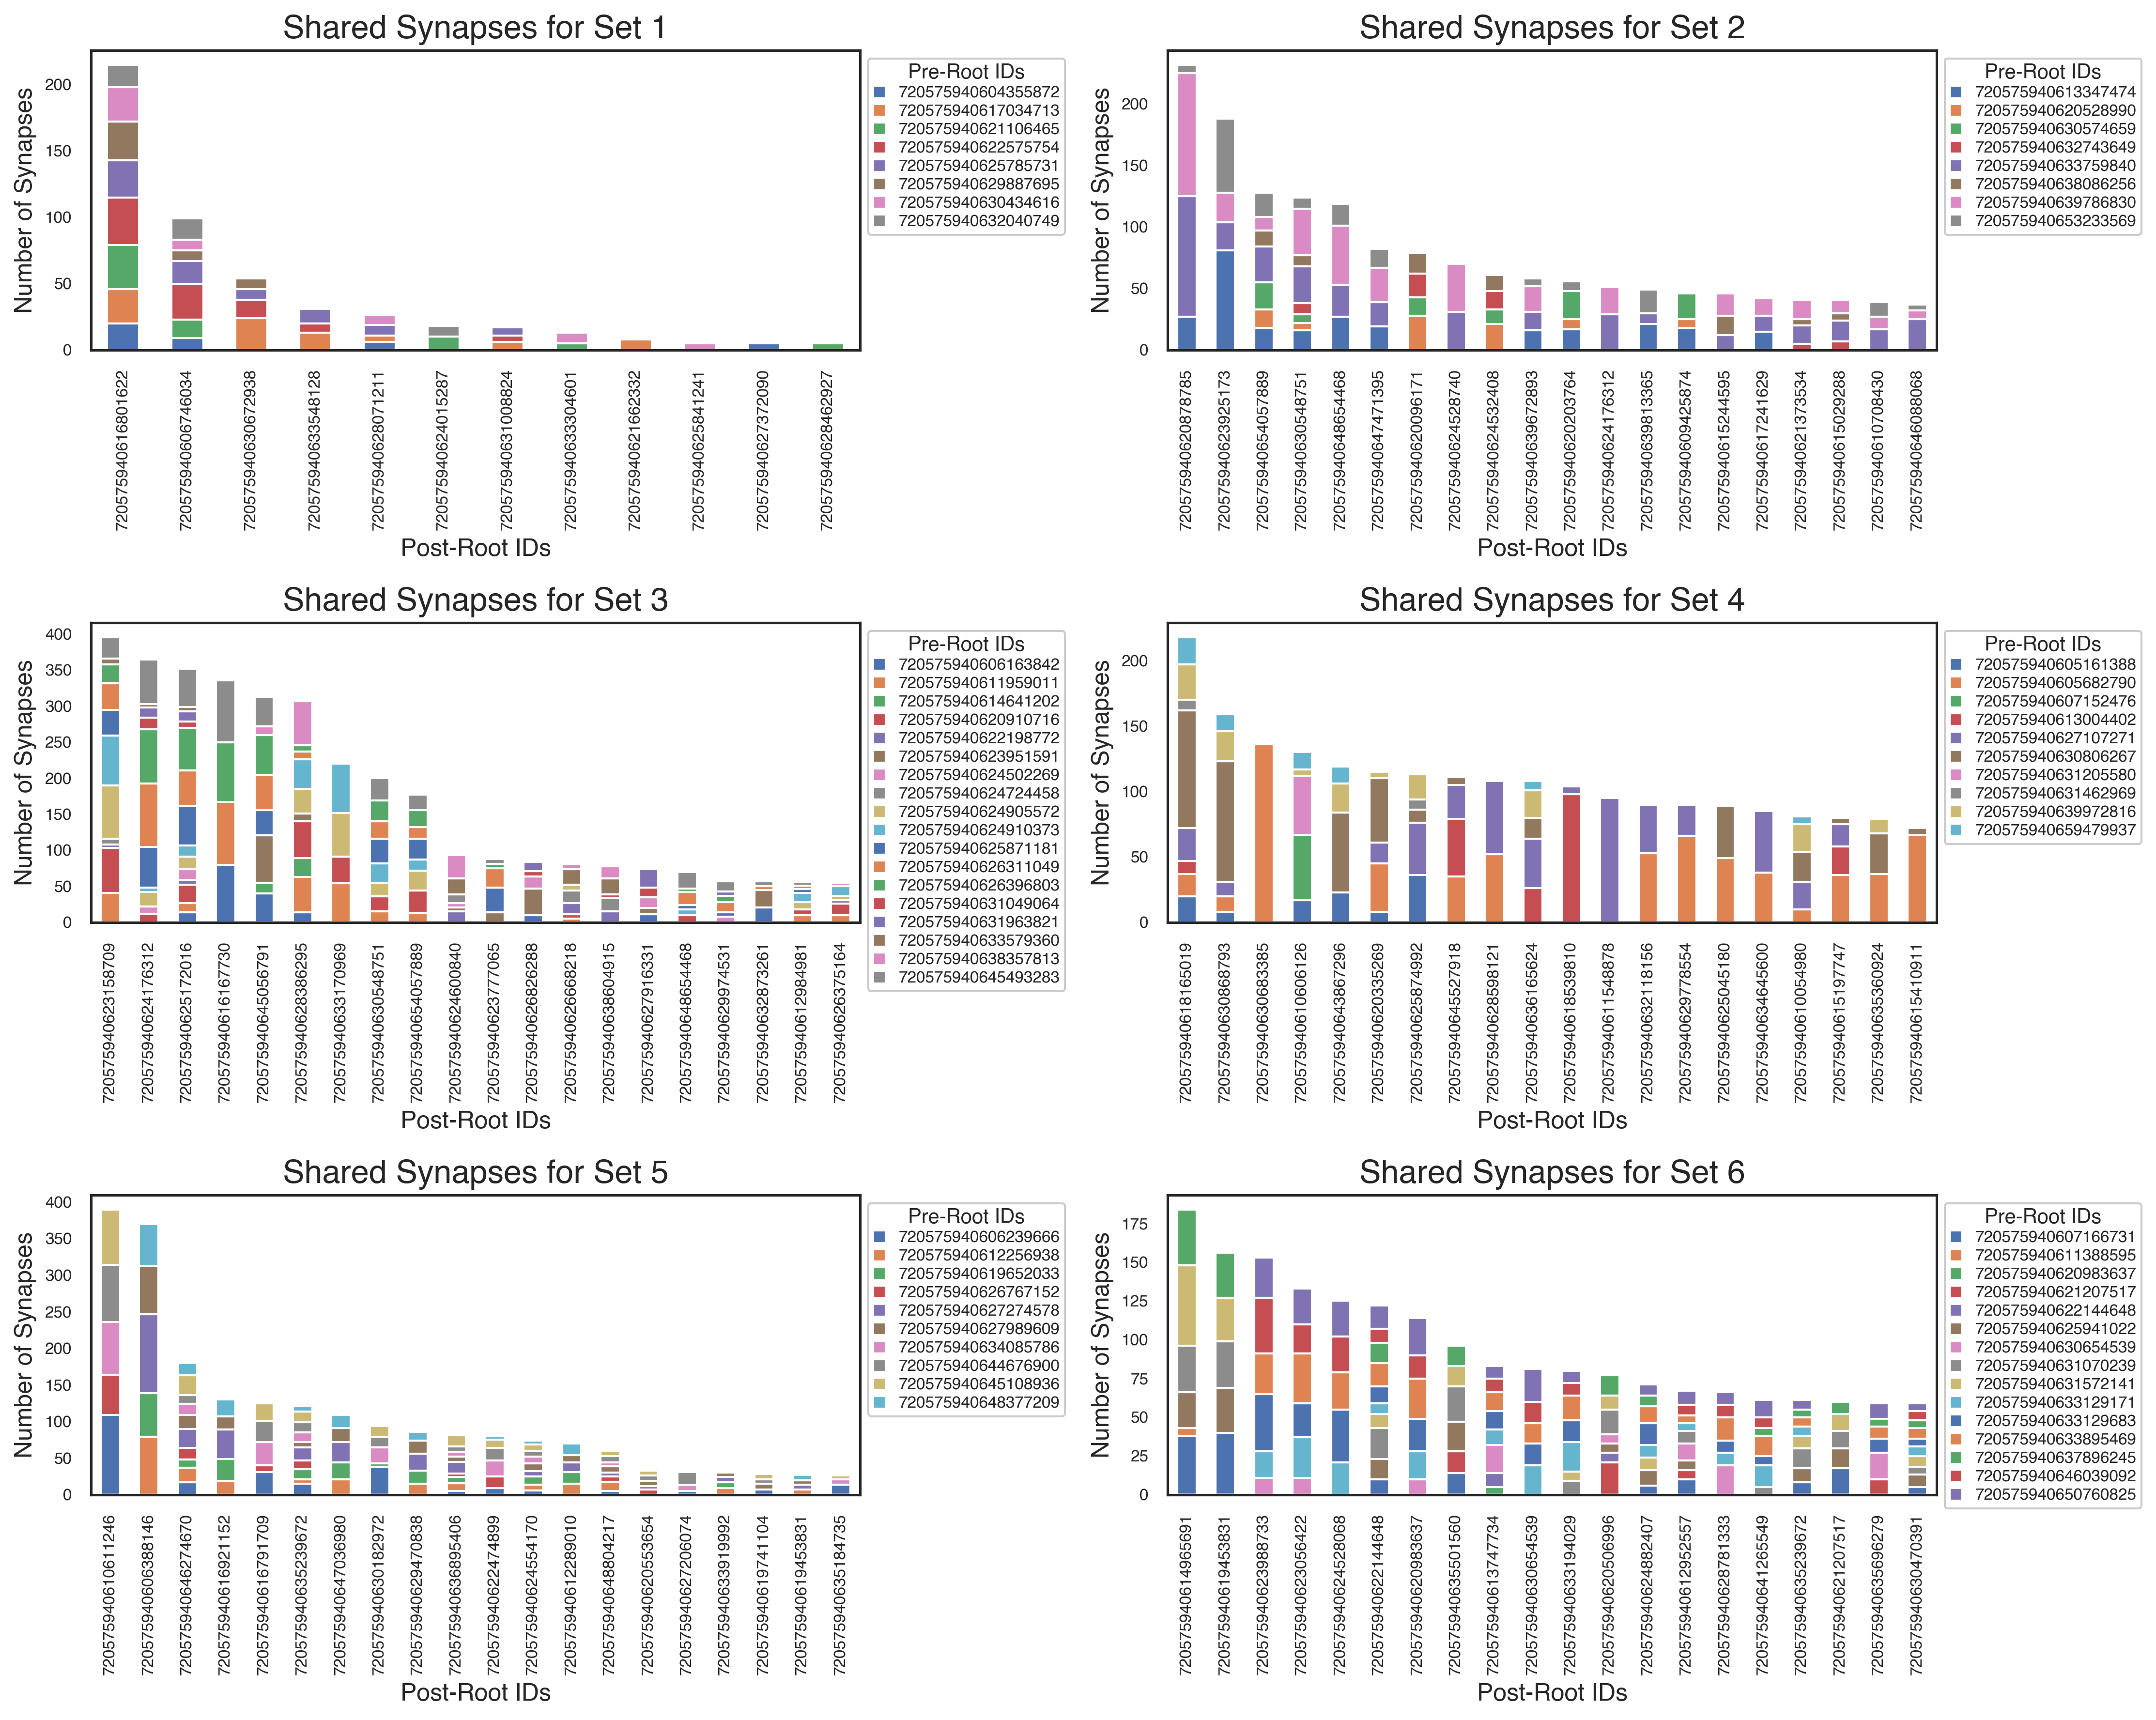

In [26]:
## X. Shared‐Synapse Stacked‐Bar for Each StN_SA Set

import math

# (A) Build a dict mapping “Set i” to that set’s array of root IDs
#     (we assume each set_i DataFrame has a column named “root_id”)
sets_roots = {
    f"Set {i}": globals()[f"set_{i}"]["root_id"].unique()
    for i in range(1, 7)
}

# (B) Determine subplot layout: 2 columns, enough rows to fit 6 sets
n_sets = len(sets_roots)
n_cols = 2
n_rows = math.ceil(n_sets / n_cols)

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(15, 4 * n_rows),
    dpi=300,
    sharex=False,
    sharey=False
)
axes = axes.flatten()

for ax, (set_name, root_ids) in zip(axes, sets_roots.items()):
    # 1) Filter “connections” for this set’s presynaptic IDs & syn_count ≥ 5
    subset = connections[
        (connections["pre_root_id"].isin(root_ids)) &
        (connections["syn_count"] >= 5)
        ]

    # 2) Aggregate by (post_root_id, pre_root_id) summing syn_count
    shared = (
        subset
        .groupby(["post_root_id", "pre_root_id"])["syn_count"]
        .sum()
        .reset_index(name="synapse_count")
    )

    # 3) Sum‐up total synapses per post_root_id, then pick top 20
    post_totals = (
        shared
        .groupby("post_root_id")["synapse_count"]
        .sum()
        .reset_index()
        .sort_values("synapse_count", ascending=False)
        .head(20)
    )
    top_post_ids = post_totals["post_root_id"].tolist()

    # 4) Keep only those top 20 post_root_id rows
    filtered = shared[shared["post_root_id"].isin(top_post_ids)]

    # 5) Pivot into a “post_root_id × pre_root_id” table (filled with 0 when missing)
    stacked = filtered.pivot_table(
        index="post_root_id",
        columns="pre_root_id",
        values="synapse_count",
        fill_value=0
    )
    # Re‐order rows to match the descending “top 20” list
    stacked = stacked.loc[top_post_ids]

    # 6) Plot a stacked bar chart in the appropriate subplot (ax)
    bars = stacked.plot(
        kind="bar",
        stacked=True,
        ax=ax,
        legend=False
    )
    ax.set_title(f"Shared Synapses for {set_name}")
    ax.set_xlabel("Post‐Root IDs")
    ax.set_ylabel("Number of Synapses")
    ax.tick_params(axis="x", rotation=90)

    # 7) Build a legend of “pre_root_id” colors, placed just outside upper‐left
    handles, labels = bars.get_legend_handles_labels()
    ax.legend(
    handles,
    labels,
    title="Pre‐Root IDs",
    loc="upper left",
    bbox_to_anchor=(1, 1),
    fontsize=8,         # smaller text
    title_fontsize=10,
    handlelength=0.8,   # shorter color‐patches
    handleheight=0.8,   # less tall color‐patches
    labelspacing=0.2,   # less vertical spacing between entries
    borderpad=0.3       # less padding around the whole legend box
)


# (C) Any extra subplots beyond 6 → turn off
for extra_ax in axes[len(sets_roots):]:
    extra_ax.axis("off")

plt.tight_layout()
plt.show()


In [27]:
## X. Export Top 100 Downstream Connections for Each StN_SA Set

import os

# (1) Build a dict “Set i” → {all root_id’s in set_i}
sets_roots = {
    f"Set {i}": set(globals()[f"set_{i}"]["root_id"].unique())
    for i in range(1, 7)
}

# (2) Make output directory (adjust to your desired path)
output_dir = "/Users/yaolab/UFL Dropbox/Dimitrios Giakoumas (giakoumasd)/Shared with Dimitrios/PhN_cluster_1-6_CAVE_outputs/"
os.makedirs(output_dir, exist_ok=True)

# (3) For each Set, filter `connections`, aggregate, and save CSVs
for set_name, root_ids in sets_roots.items():
    # 3a) Filter connections where pre_root_id ∈ this set and syn_count ≥ 5
    subset = connections[
        (connections["pre_root_id"].isin(root_ids)) &
        (connections["syn_count"] >= 5)
        ]

    # 3b) Sum syn_count over (post_root_id, pre_root_id)
    shared = (
        subset
        .groupby(["post_root_id", "pre_root_id"])["syn_count"]
        .sum()
        .reset_index(name="synapse_count")
    )

    # 3c) Compute total synapses per post_root_id, then pick top 100 by total
    post_totals = (
        shared
        .groupby("post_root_id")["synapse_count"]
        .sum()
        .reset_index()
        .sort_values("synapse_count", ascending=False)
        .head(100)
    )
    top_post_ids = post_totals["post_root_id"].tolist()

    # 3d) Keep only the top 100 rows in detailed “shared” table
    top_100_details = shared[shared["post_root_id"].isin(top_post_ids)]
    top_100_details = top_100_details.sort_values("synapse_count", ascending=False)

    # 3e) Save the detailed “pre→post” table to CSV
    csv_path = os.path.join(output_dir, f"{set_name}_top_100_connections.csv")
    top_100_details.to_csv(csv_path, index=False)

    # 3f) Save the unique post_root_id’s (top 100) to their own CSV
    unique_post_df = pd.DataFrame({"post_root_id": top_post_ids})
    post_ids_path = os.path.join(output_dir, f"{set_name}_top_post_root_ids.csv")
    unique_post_df.to_csv(post_ids_path, index=False)

    print(f"✔ Saved top 100 connections for {set_name} → {csv_path}")
    print(f"✔ Saved unique top post_root_ids for {set_name} → {post_ids_path}")


✔ Saved top 100 connections for Set 1 → /Users/yaolab/UFL Dropbox/Dimitrios Giakoumas (giakoumasd)/Shared with Dimitrios/PhN_cluster_1-6_CAVE_outputs/Set 1_top_100_connections.csv
✔ Saved unique top post_root_ids for Set 1 → /Users/yaolab/UFL Dropbox/Dimitrios Giakoumas (giakoumasd)/Shared with Dimitrios/PhN_cluster_1-6_CAVE_outputs/Set 1_top_post_root_ids.csv
✔ Saved top 100 connections for Set 2 → /Users/yaolab/UFL Dropbox/Dimitrios Giakoumas (giakoumasd)/Shared with Dimitrios/PhN_cluster_1-6_CAVE_outputs/Set 2_top_100_connections.csv
✔ Saved unique top post_root_ids for Set 2 → /Users/yaolab/UFL Dropbox/Dimitrios Giakoumas (giakoumasd)/Shared with Dimitrios/PhN_cluster_1-6_CAVE_outputs/Set 2_top_post_root_ids.csv
✔ Saved top 100 connections for Set 3 → /Users/yaolab/UFL Dropbox/Dimitrios Giakoumas (giakoumasd)/Shared with Dimitrios/PhN_cluster_1-6_CAVE_outputs/Set 3_top_100_connections.csv
✔ Saved unique top post_root_ids for Set 3 → /Users/yaolab/UFL Dropbox/Dimitrios Giakoumas (gi

## 2c. Analyze 2N inputs/outputs and convergence/interactions across modalities

### Make a Venn diagram to analyze convergence of different StN_SA sets onto 2Ns

In [24]:
# Set seaborn theme to white
sns.set_theme(style='white')

# set up matplot lib theme
andy_theme = {'axes.grid': False,
              'grid.linestyle': '--',
              'legend.framealpha': 1,
              'legend.facecolor': 'white',
              'legend.shadow': False,
              'legend.fontsize': 14,
              'legend.title_fontsize': 14,
              'font.sans-serif':'Helvetica',
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'axes.labelsize': 12,
              'axes.titlesize': 16,
              'figure.dpi': 400}

plt.rcParams.update(andy_theme)

#Uncomment next 2 lines if matplotlib can not find Helvetica font
#plt.rcParams['font.family'] = 'DeJavu Serif'
#plt.rcParams['font.sans-serif'] = ['Arial']

In [25]:
from upsetplot import UpSet, from_contents

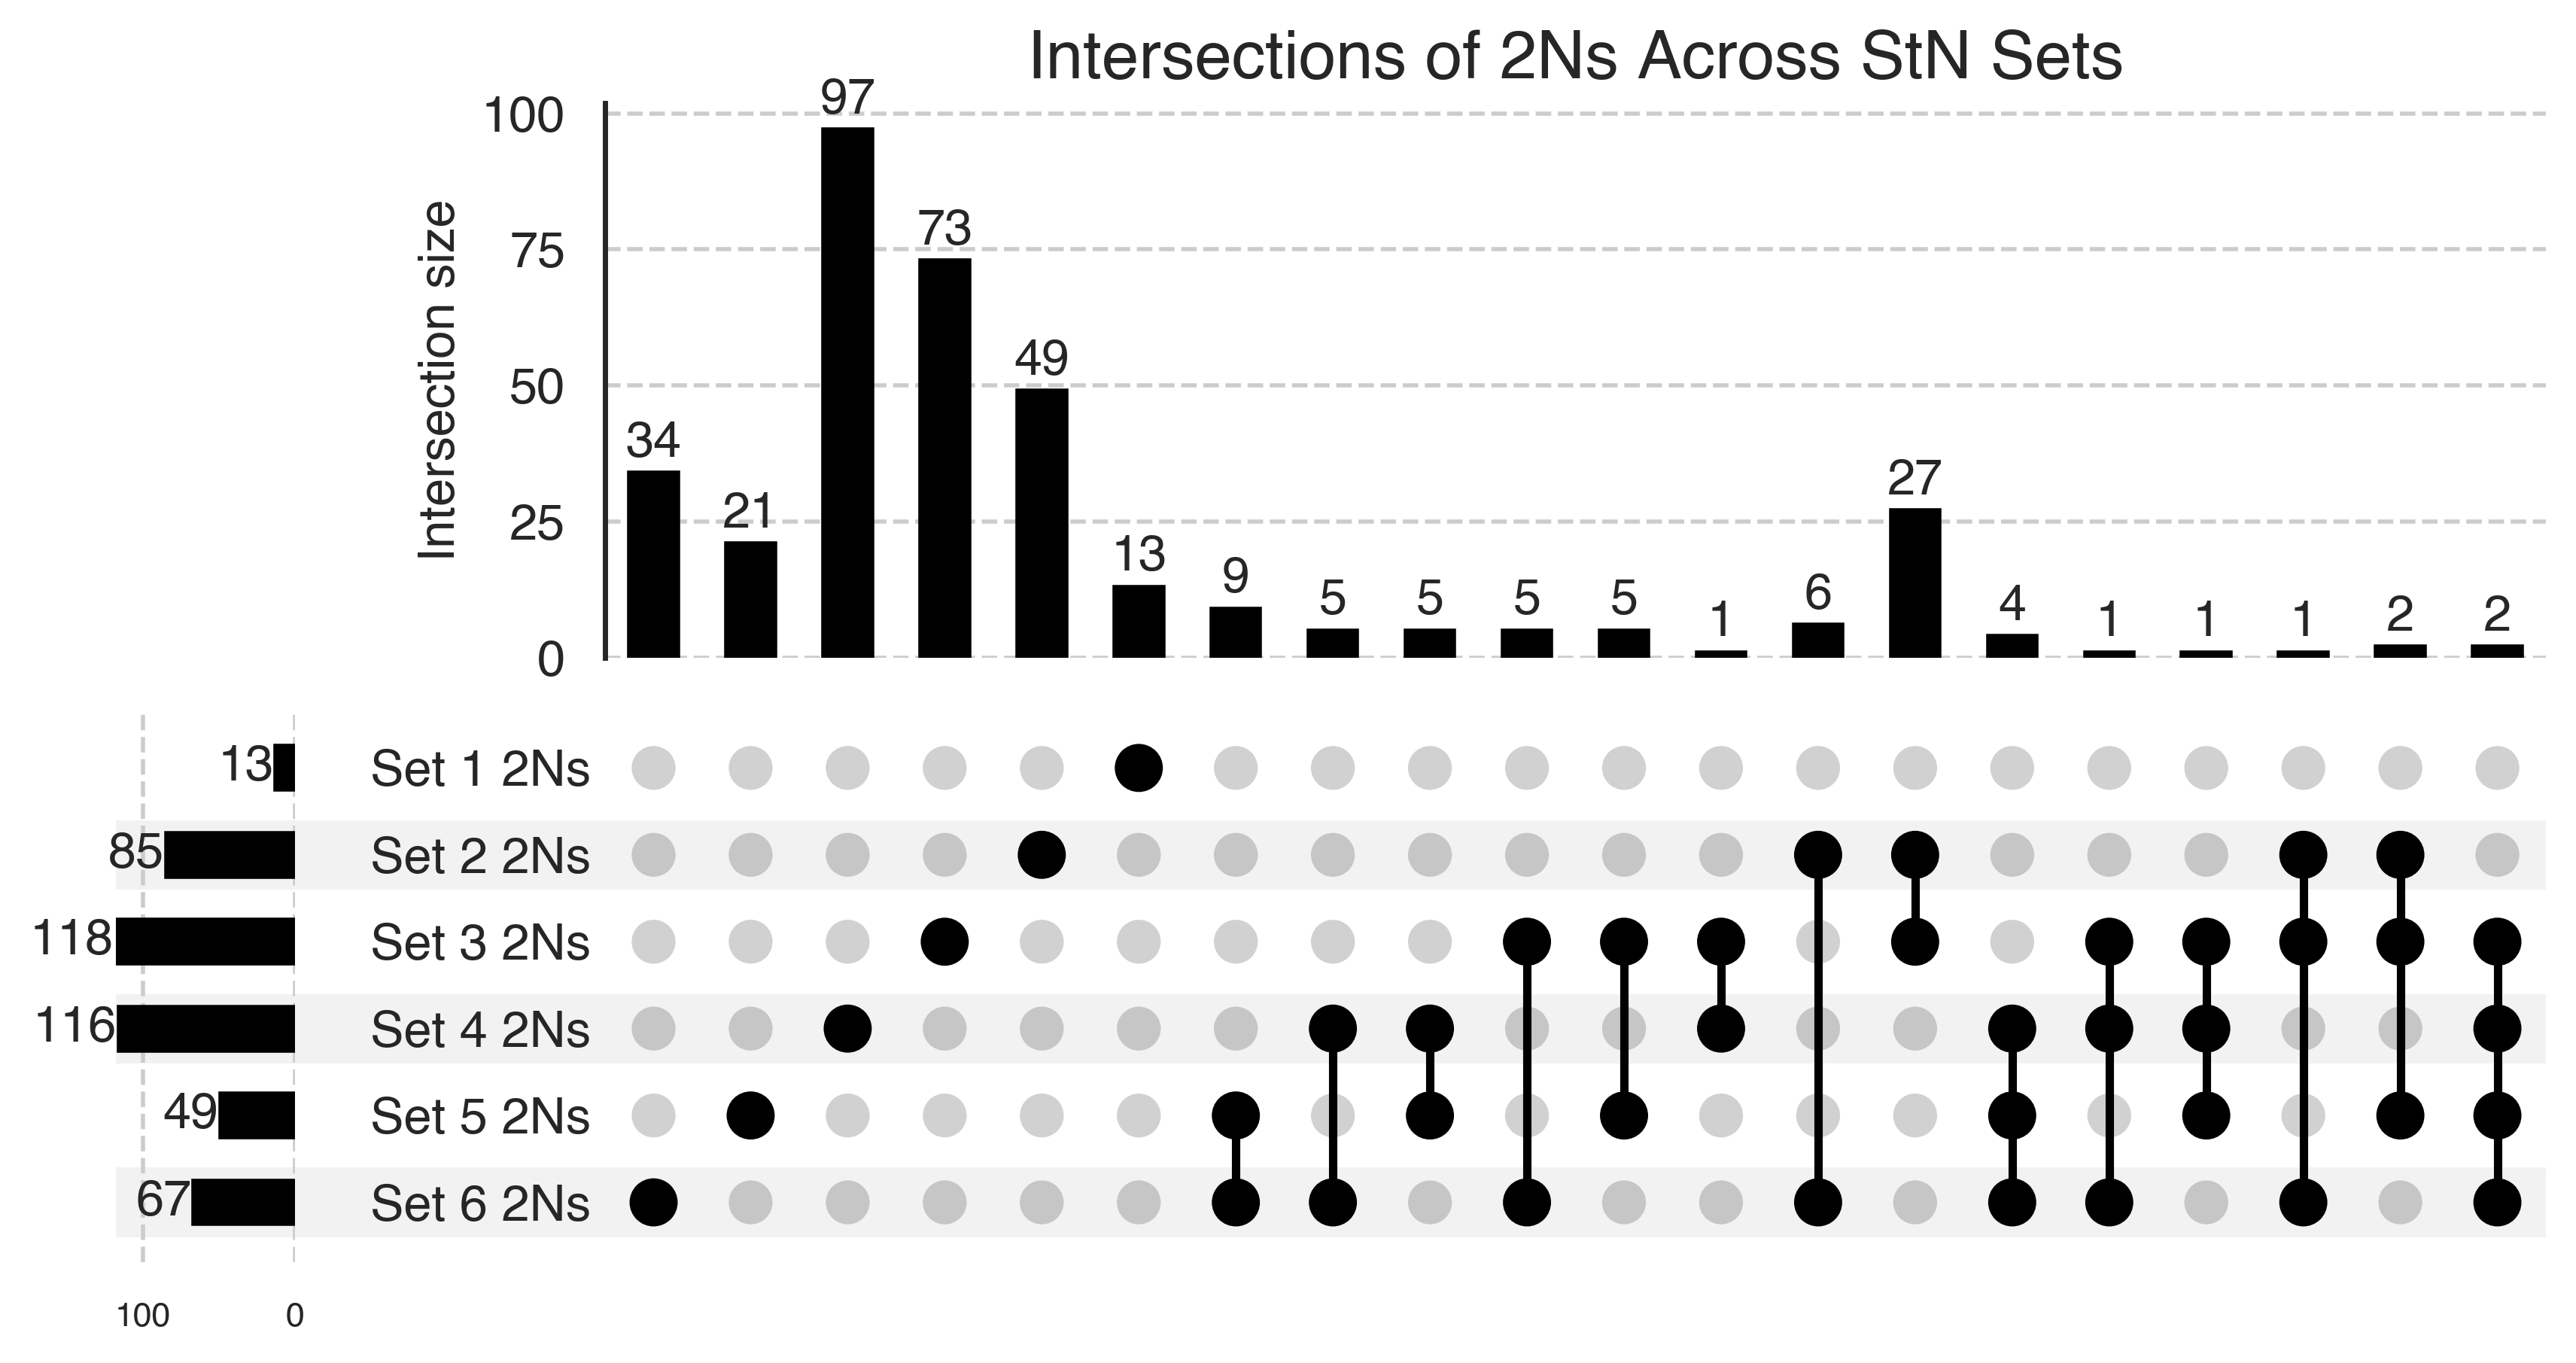

In [26]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, module='upsetplot')


# your palette for recoloring bars

# 1) Build the contents dict in Set1toSet6 order
contents = {
    f'Set {i} 2Ns': {str(x) for x in globals()[f'set_{i}_2Ns']['root_id'].unique()}
    for i in range(1,7)
}
upset_data = from_contents(contents)

# 2) Create figure and UpSet, sorting intersections ascending by size
fig = plt.figure(figsize=(10,6), dpi=400)
up = UpSet(
    upset_data,
    subset_size='count',
    show_counts=True,
    element_size=30,
    #sort_by='cardinality',    # smallesttolargest :contentReference[oaicite:0]{index=0}
    sort_categories_by='-input' # preserves Set1toSet6
)
up.plot(fig=fig)


# remove the x‐axis ticks and labels on every axes in the figure
for ax in fig.axes:
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(
        axis='y',
        which='major',
        labelsize=12,
        bottom=False,    # no tick marks
        labelbottom=False,  # no tick labels

    )


# 3) Hide the x-axis of the intersection‐size plot only
#intersection_ax = fig.axes[0]
#intersection_ax.xaxis.set_visible(False)
#intersection_ax.spines['bottom'].set_visible(False)

plt.title("Intersections of 2Ns Across StN Sets")
plt.savefig('/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/General - YaoLabUF/SVG_figs/Fig3/upset2n.svg', format='svg', bbox_inches='tight')
#plt.tight_layout()
plt.show()


In [27]:
 # matplotlib infers format from extension

In [28]:
# Set seaborn theme to white
sns.set_theme(style='white')

# set up matplot lib theme
andy_theme = {'axes.grid': False,
              'grid.linestyle': '--',
              'legend.framealpha': 1,
              'legend.facecolor': 'white',
              'legend.shadow': False,
              'legend.fontsize': 14,
              'legend.title_fontsize': 14,
              'font.sans-serif':'Helvetica',
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'axes.labelsize': 12,
              'axes.titlesize': 16,
              'figure.dpi': 300}

plt.rcParams.update(andy_theme)

#Uncomment next 2 lines if matplotlib can not find Helvetica font
#plt.rcParams['font.family'] = 'DeJavu Serif'
#plt.rcParams['font.sans-serif'] = ['Arial']

### Get downstream connections of 2Ns in order to assess 2N-2N and 2N-StN_SA connectivity
- minimum of 5 synapses for a connection
- all connections are counted, even if they are connections to StN_SA or other 2Ns

In [29]:
# Get outputs of each 2N population using the same "neuronal_outputs" function defined earlier for Sets
# columns: pre_root_id, post_root_id, neuropil, syn_count, nt_type, location_of_connection
# Example: 2N outputs for each set

twoN_list = [globals()[f"set_{i}_2Ns"] for i in range(1, n+1)]

# 2) Compute and store the outputs for each 2N set
for i, df in enumerate(twoN_list, start=1):
    globals()[f"set_{i}_2N_outputs"] = neuronal_outputs(df)

# 3) Build the lists needed for downstream analyses
outputs_list = [globals()[f"set_{i}_2N_outputs"] for i in range(1, n+1)]
sets_list    = twoN_list

In [30]:
set_2_2N_outputs

pre_root_id        post_root_id  syn_count neuropil nt_type  \
0     720575940603944382  720575940603514141          8    FLA_L     ACH   
1     720575940603944382  720575940613845516          7    SMP_L     ACH   
2     720575940603944382  720575940617369117          9    SMP_L     ACH   
3     720575940603944382  720575940626449158         21    SMP_L     ACH   
4     720575940603944382  720575940626775824          9    SMP_L     ACH   
...                  ...                 ...        ...      ...     ...   
3081  720575940654057889  720575940640681680          5      PRW    GLUT   
3082  720575940654057889  720575940641417869         13      PRW    GLUT   
3083  720575940654057889  720575940642910152          9      PRW    GLUT   
3084  720575940654057889  720575940648601988          5      PRW    GLUT   
3085  720575940654057889  720575940648652921         15      PRW    GLUT   

     location_of_connection  
0                     local  
1               outside_SEZ  
2               outside_SEZ  
3               outside_SEZ  
4               outside_SEZ  
...                     ...  
3081                  local  
3082                  local  
3083                  local  
3084                  local  
3085                  local  

[3086 rows x 6 columns]

### Plot heatmap of all 2N to 2N synapses

In [31]:
# Define function to get data for heatmaps
def _2N_heatmap(twone_outputs, sets_list):
    """
    Given a DataFrame 'twone_outputs' containing 2N connectivity (e.g. from neuronal_outputs),
    merge with each set in 'sets_list' to find connections that end in that set's 2Ns.
    Returns the sum of 'syn_count' for each intersection.
    """
    # For each set in sets_list, compute total syn_count where post_root_id is in that set
    sums = []
    for target_set in sets_list:
        merged = pd.merge(
            twone_outputs,
            target_set,
            left_on='post_root_id',
            right_on='root_id',
            how='inner'
        )
        sums.append(merged['syn_count'].sum())
    return sums

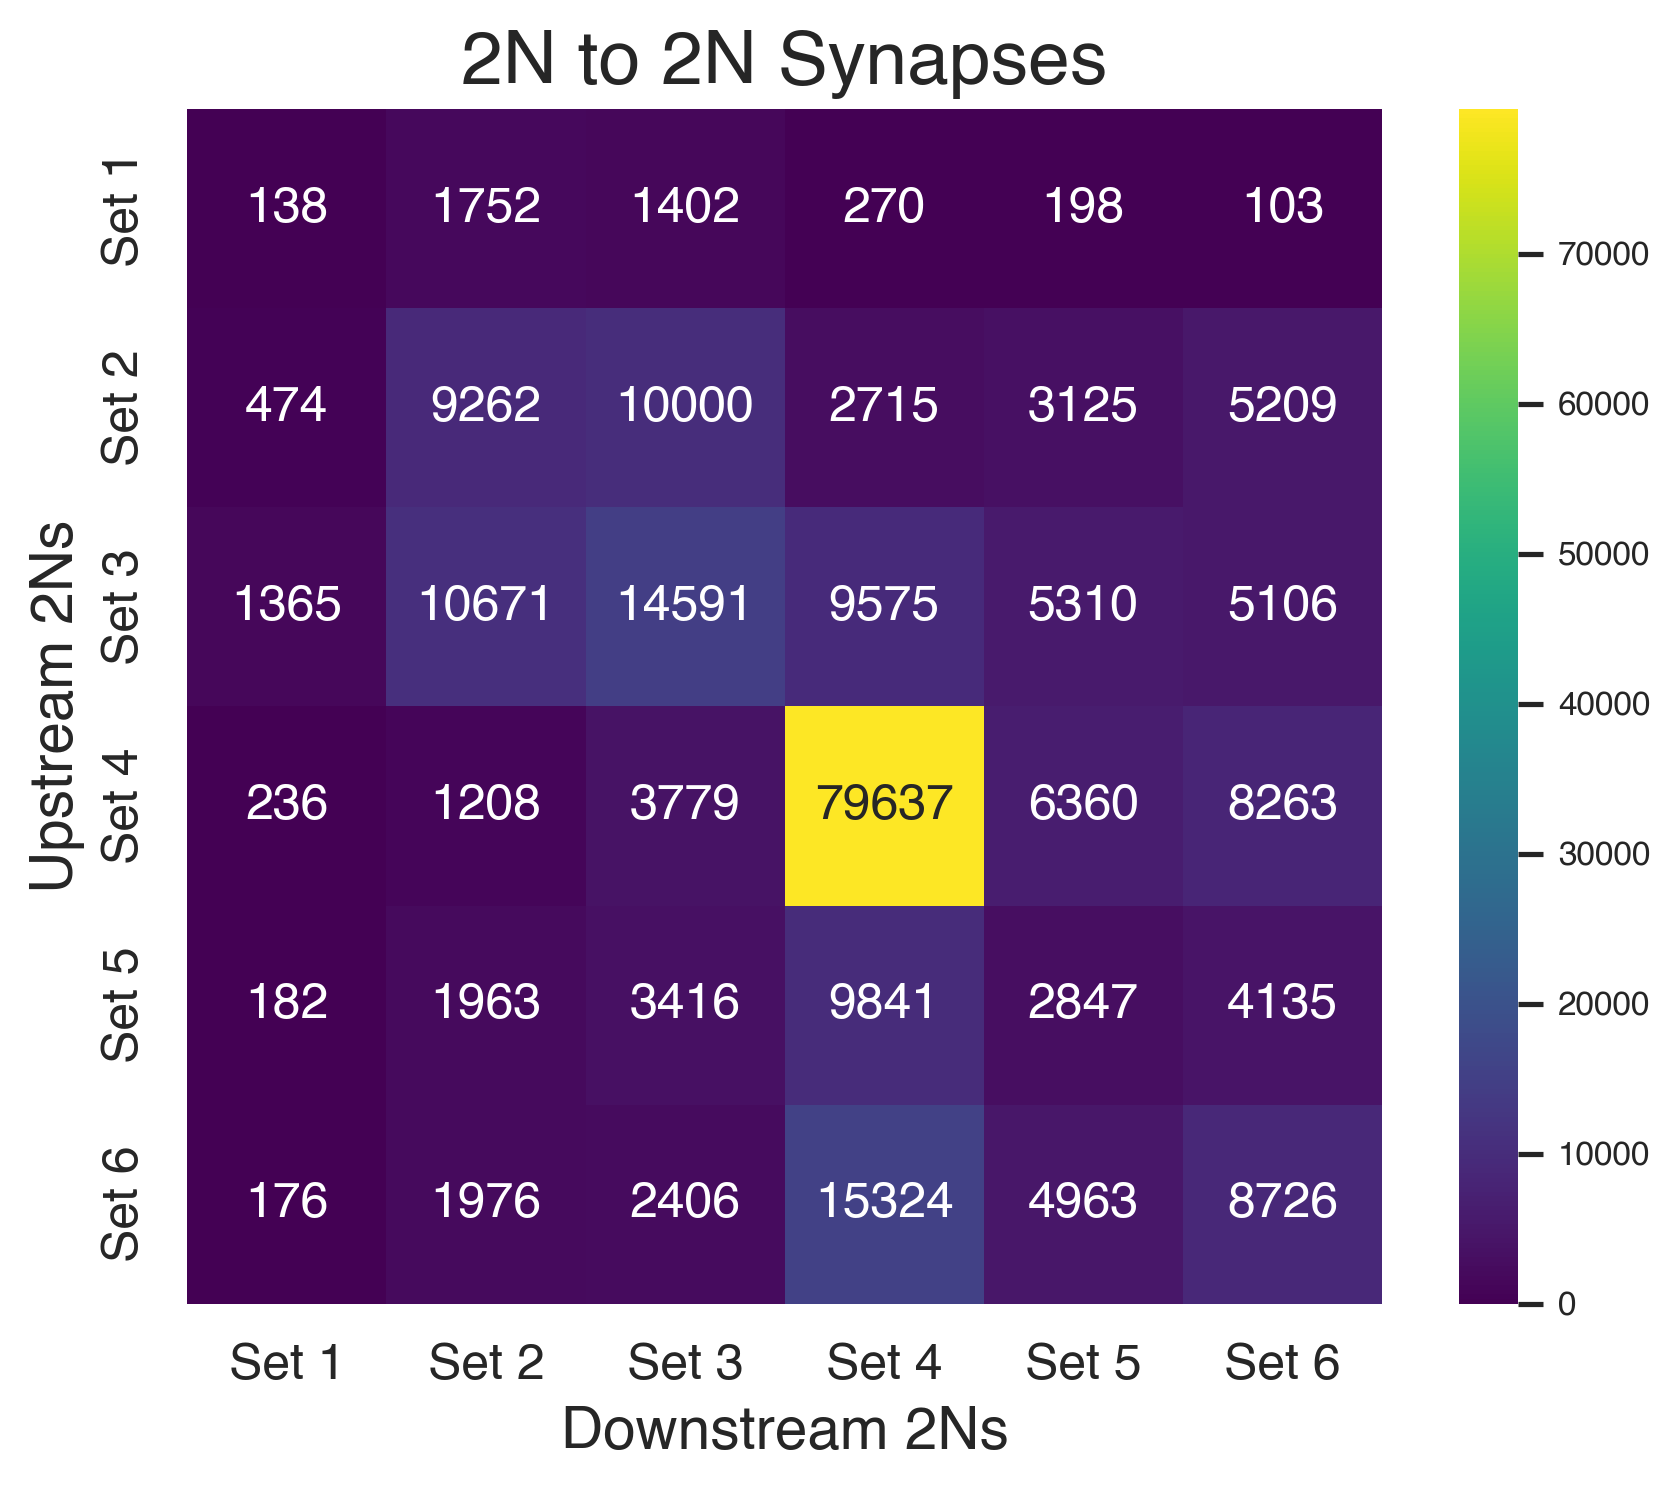

In [32]:
labels      = [f"Set {i}" for i in range(1, n+1)]
outputs_list = [globals()[f"set_{i}_2N_outputs"] for i in range(1, n+1)]

# 3) Build the matrix
matrix_2Ns = np.array([_2N_heatmap(out, sets_list) for out in outputs_list])

# 4) Plot with dynamic labels
plt.figure(figsize=(6,5))
sns.heatmap(
    matrix_2Ns,
    cmap="viridis",
    annot=True,
    fmt="d",
    xticklabels=labels,
    yticklabels=labels,
    square=True,
    vmin=0
)
plt.title("2N to 2N Synapses", fontsize=18)
plt.ylabel("Upstream 2Ns", fontsize=14)
plt.xlabel("Downstream 2Ns", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

### Make a heatmap to see connectivity from StN_SA to individual 2Ns

We will plot each individual 2N as a different column and each StN_SA modality as a different row, then make a heatmap where the color indicates the number of input synapses from each set of StN-SA onto each 2N.

/var/folders/vc/tg6mvd312zq8kcg7w10xlh3r0000gp/T/ipykernel_15196/4064654979.py:29: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_matrix = df_sorted.pivot_table(


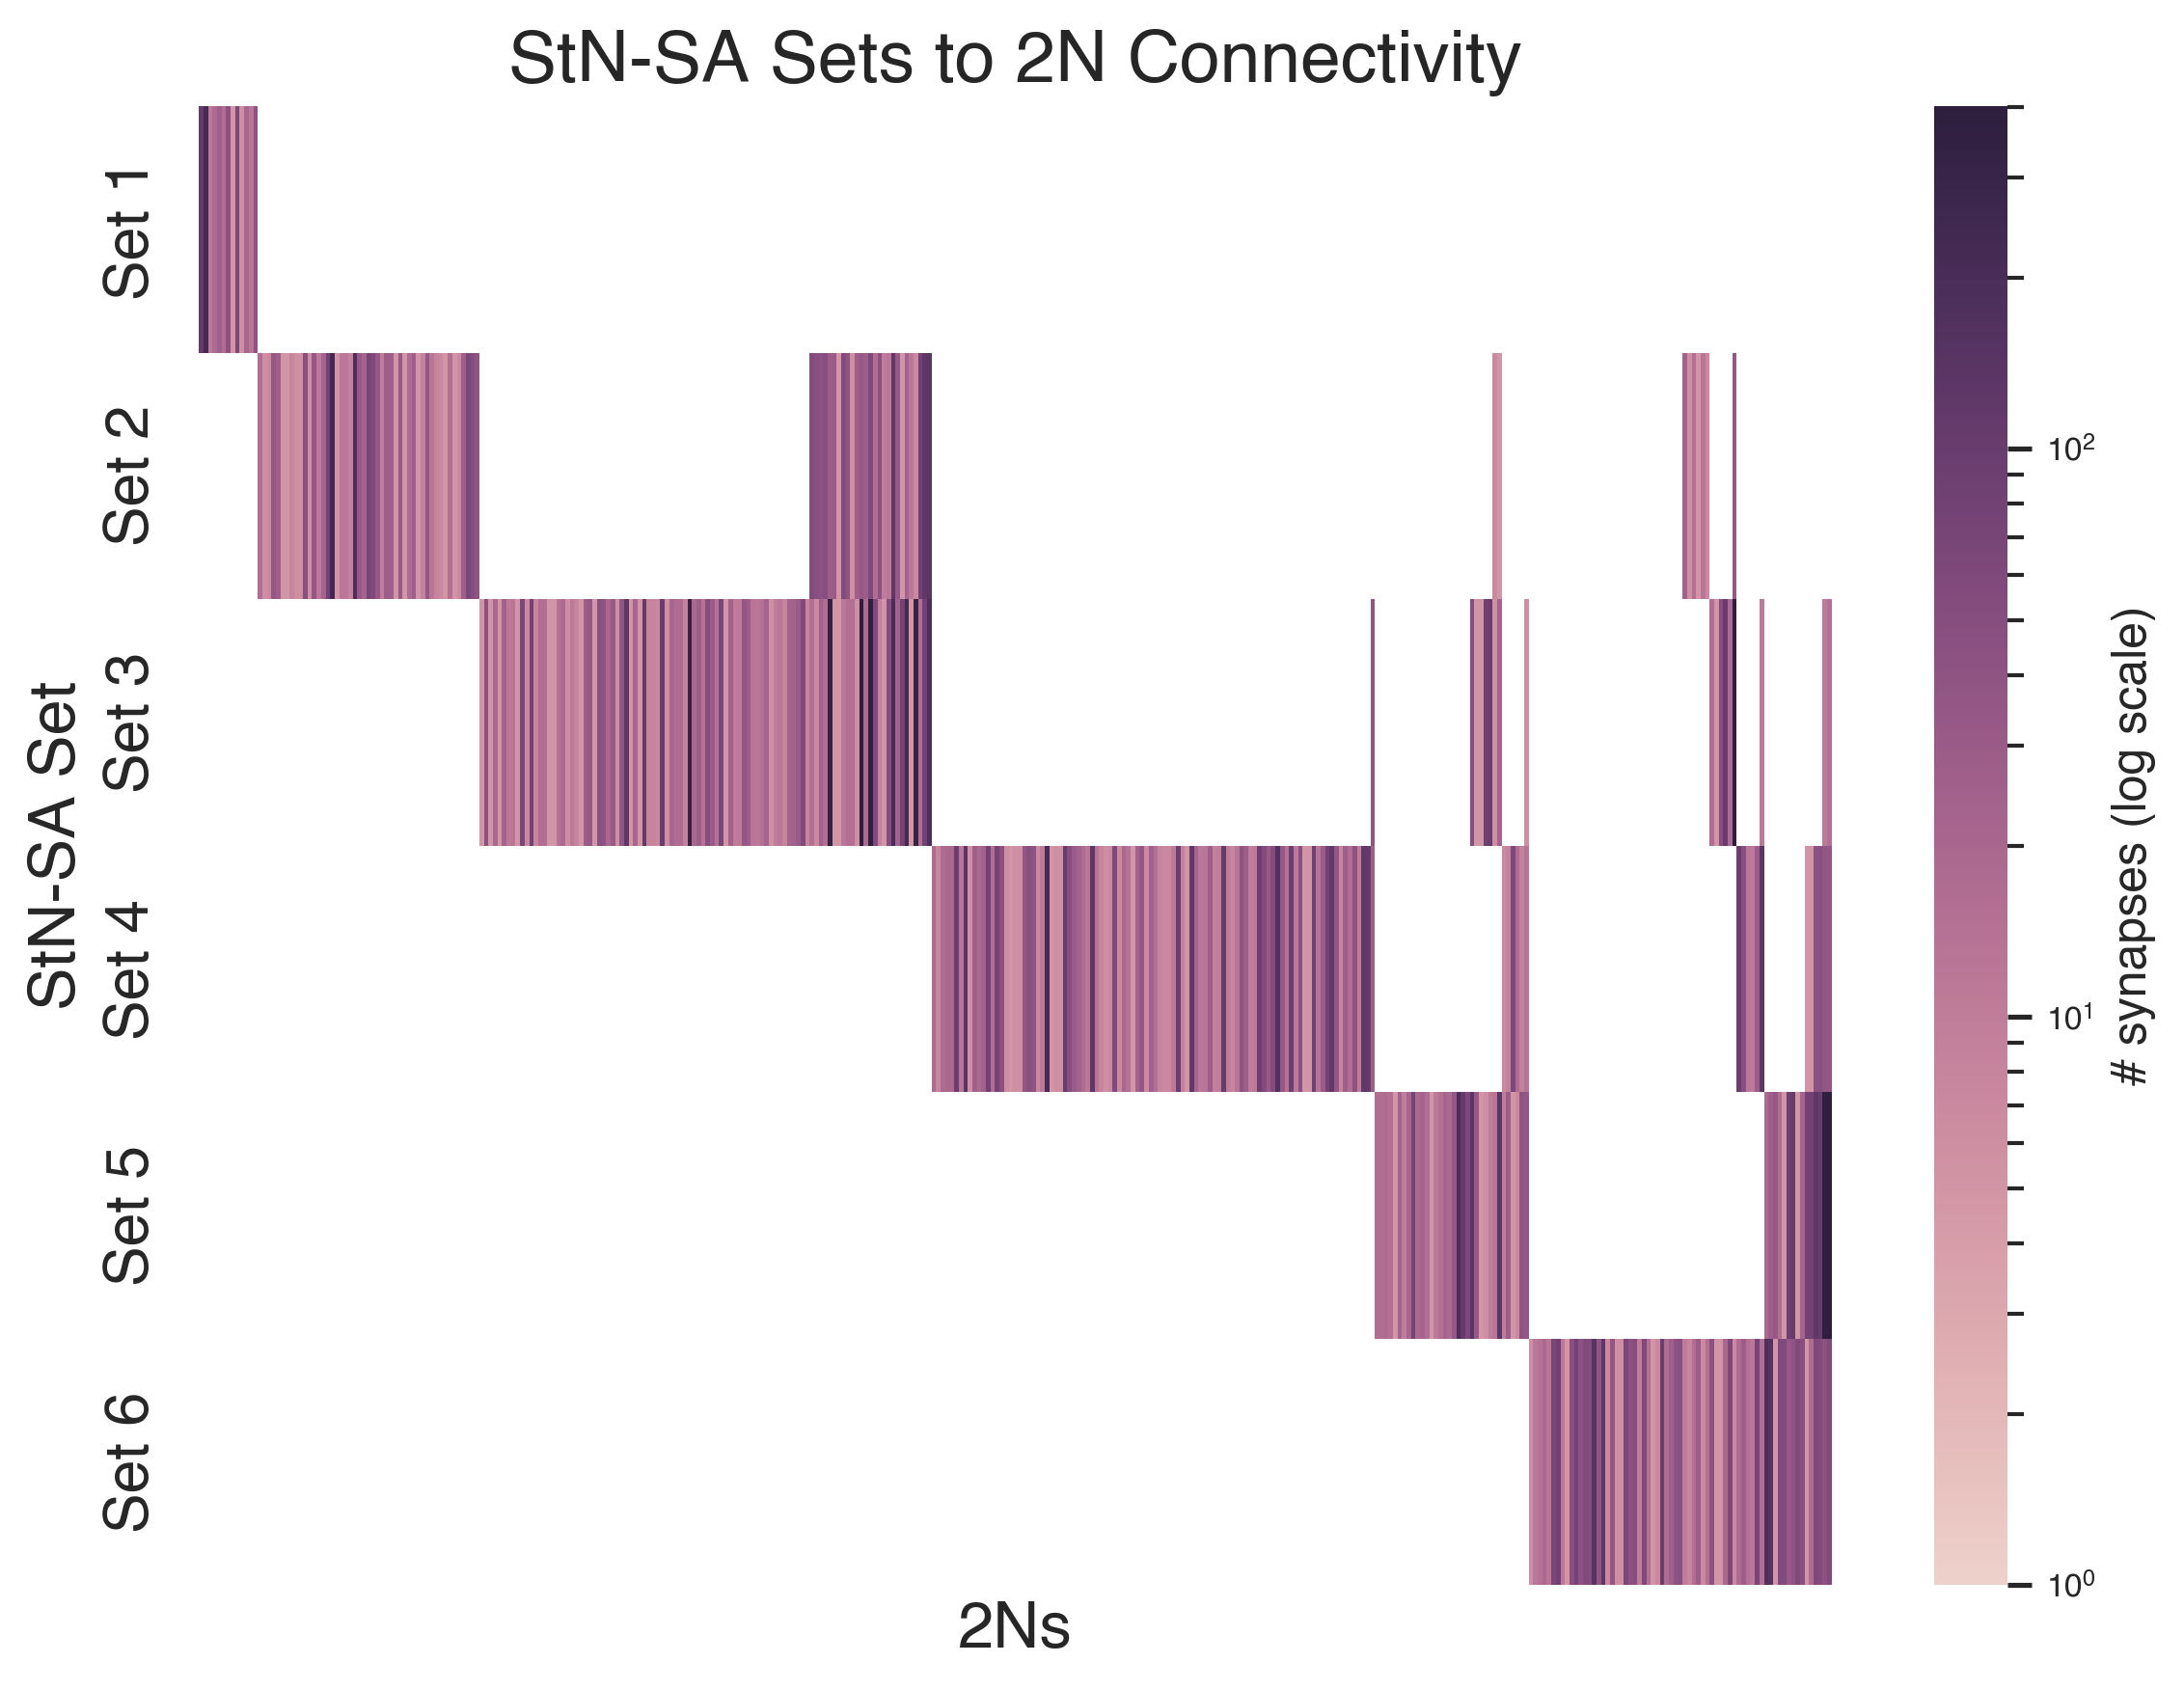

In [33]:
# Concatenate connectivity data from all StN_SA sets (second_order_connectivity)
n_sets = len([v for v in globals() if v.startswith("set_") and v.endswith("_2Ns")])
second_order_conns = [globals()[f"set_{i}_second_order_connectivity"] for i in range(1, n_sets + 1)]
all_2Ns_sets = [globals()[f"set_{i}_2Ns"] for i in range(1, n_sets + 1)]
all_1Ns_sets = [globals()[f"set_{i}"] for i in range(1, n_sets + 1)]

# Concatenate all second_order_connectivity DataFrames
heatmap_data = pd.concat(second_order_conns, axis=0)

# Assign post_root_id_group dynamically
heatmap_data['post_root_id_group'] = ""
for idx, set_2Ns in enumerate(all_2Ns_sets, start=1):
    mask = heatmap_data['post_root_id'].isin(set_2Ns['root_id'].values)
    heatmap_data.loc[mask, 'post_root_id_group'] += f"Set {idx}"

# Assign pre_root_id_group dynamically (each root belongs to only one set, else "other")
heatmap_data['pre_root_id_group'] = "other"
for idx, set_1Ns in enumerate(all_1Ns_sets, start=1):
    mask = heatmap_data['pre_root_id'].isin(set_1Ns['root_id'].values)
    heatmap_data.loc[mask, 'pre_root_id_group'] = f"Set {idx}"

# Define ordering
custom_order = [f"Set {i}" for i in range(1, n_sets + 1)]
heatmap_data['post_root_id_group'] = pd.Categorical(heatmap_data['post_root_id_group'], categories=custom_order, ordered=True)
heatmap_data['pre_root_id_group'] = pd.Categorical(heatmap_data['pre_root_id_group'], categories=custom_order, ordered=True)
df_sorted = heatmap_data.sort_values(by='post_root_id_group')

# Pivot table for visualization
heatmap_matrix = df_sorted.pivot_table(
    index='pre_root_id_group',
    columns='post_root_id',
    values='syn_count',
    aggfunc='sum',
    fill_value=0
)
# Fix row order
heatmap_matrix = heatmap_matrix.loc[custom_order, :]

# Compute which 2Ns are hit by how many sets
nonzero = heatmap_matrix.ne(0)

# Sort columns (2Ns) by how many different sets hit each one
display_order_2Ns = (
    nonzero.T
    .sort_values(
        by=custom_order[::-1],  # Reverse so Set 6..1
        ascending=True
    )
    .index
)
heatmap_matrix = heatmap_matrix[display_order_2Ns]

# LogNorm, avoiding issues with log(0) by setting vmin=1
vmin, vmax = 1, heatmap_matrix.values.max()
norm = LogNorm(vmin=vmin, vmax=vmax)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    heatmap_matrix,
    norm=norm,
    cmap=sns.cubehelix_palette(as_cmap=True),
    xticklabels=False,
    yticklabels=True,
    cbar_kws={'label':'# synapses (log scale)'},
    ax=ax
)
ax.tick_params(axis='y', labelsize=15)
ax.set_title('StN-SA Sets to 2N Connectivity', fontsize=18)
ax.set_xlabel('2Ns', fontsize=16)
ax.set_ylabel('StN-SA Set', fontsize=16)
plt.savefig('/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/General - YaoLabUF/SVG_figs/Fig3/StN-SA Sets to 2N Connectivity.svg', format='svg', bbox_inches='tight')
plt.tight_layout()
plt.show()


## 2e. Classifying 2Ns by their anatomical and functional properties

### First, we will define 2Ns as local vs. projection neurons.
- Local neurons have output connections only in the SEZ (defined as including GNG, PRW, SAD, FLA, CAN)
- Projection neurons have at least one output connection (comprising at least 5 synapses) in another brain region

## 2e. Classifying 2Ns by their anatomical and functional properties

### First, we will define 2Ns as local vs. projection neurons.
#  - Local neurons have *only* SEZ outputs
#  - Projection neurons have ≥1 output (≥5 synapses total) outside the SEZ


In [34]:
def classify_neurons(neurons):
    """
    Given a DataFrame `neurons` with a column 'root_id',
    returns a DataFrame with columns:
      - root_id
      - neuron_type: 'local' or 'projection'
      - #_projection_synapses: total syn_count outside the SEZ
    """
    # 1) get all pair-level, ≥5-synapse outputs for these neurons
    conn = neuronal_outputs(neurons)  # uses your groupby-sum threshold

    # 2) sum up syn_count *outside* the SEZ by each pre_root_id
    proj_syn = (
        conn
        .loc[conn['location_of_connection'] == 'outside_SEZ']
        .groupby('pre_root_id', as_index=False)['syn_count']
        .sum()
        .rename(columns={'pre_root_id':'root_id', 'syn_count':'#_projection_synapses'})
    )

    # 3) build the classification DataFrame
    df = pd.DataFrame({'root_id': neurons['root_id'].unique()})
    df = df.merge(proj_syn, on='root_id', how='left')
    df['#_projection_synapses'] = df['#_projection_synapses'].fillna(0).astype(int)
    df['neuron_type'] = np.where(df['#_projection_synapses'] > 0, 'projection', 'local')

    return df[['root_id','neuron_type','#_projection_synapses']]

# 4) Apply to each set
for i in range(1,7):
    df = globals()[f'set_{i}_2Ns']
    df = df.merge(classify_neurons(df), on='root_id', how='left')
    globals()[f'set_{i}_2Ns'] = df

# 5) (Optional) Save out
for i in range(1,7):
    globals()[f'set_{i}_2Ns'].to_csv(f'set_{i}_2Ns_classified.csv', index=False)


In [35]:
def classify_neurons(neurons):
    # Get 2Ns connectivity data from StN_SA inputs
    neurons_classified = pd.merge(neurons[['root_id']],
                                  connections[['pre_root_id', 'post_root_id', 'neuropil', 'syn_count', 'nt_type']],
                                  left_on='root_id', right_on='pre_root_id', how='inner').query("syn_count >= 5")

    # Define whether connections are only in the SEZ
    def projection(neuropil):
        if neuropil in ['GNG', 'PRW', 'SAD', 'FLA_L', 'FLA_R', 'CAN']:
            return 'local'
        else:
            return 'outside_SEZ'

    neurons_classified['location_of_connection'] = neurons_classified['neuropil'].apply(projection)
    classifications = []
    for entry in neurons_classified['pre_root_id'].unique():
        if entry in neurons_classified.query("location_of_connection != 'local'")['pre_root_id'].unique():
            classification = pd.DataFrame({
                'root_id': [entry],
                'neuron_type': ['projection'],
                '#_projection_synapses': [
                    neurons_classified.query(f"pre_root_id == {entry} & location_of_connection != 'local'")[
                        'syn_count'].sum()]
            })
            classifications.append(classification)
        else:
            classification = pd.DataFrame({
                'root_id': [entry],
                'neuron_type': ['local'],
                '#_projection_synapses': [
                    neurons_classified.query(f"pre_root_id == {entry} & location_of_connection != 'local'")[
                        'syn_count'].sum()]
            })
            classifications.append(classification)
    result = pd.concat(classifications, ignore_index=True)
    return result


In [36]:
for i in range(1,7):
    name = f'set_{i}_2Ns'
    df   = globals()[name]

    # 1) drop any old classification columns so we don't get duplicates
    df = df.drop(columns=['neuron_type', '#_projection_synapses'], errors='ignore')

    # 2) recompute the fresh classification
    cl = classify_neurons(df)   # only root_ids with ≥5-synapse outputs

    # 3) left‐join back so every root_id stays
    df = df.merge(cl, on='root_id', how='left')

    # 4) fill the ones that never appeared in `cl` as local, zero projections
    df['neuron_type']           = df['neuron_type'].fillna('local')
    df['#_projection_synapses'] = df['#_projection_synapses'].fillna(0).astype(int)

    globals()[name] = df


In [37]:
# collect the six 2N DataFrames into a real list
sets_2Ns = [globals()[f"set_{i}_2Ns"] for i in range(1,7)]

In [38]:
local_counts = [(df['neuron_type']=='local').sum()      for df in sets_2Ns]
proj_counts  = [(df['neuron_type']=='projection').sum() for df in sets_2Ns]
total_counts = [l+p for (l,p) in zip(local_counts, proj_counts)]

print("Totals per set:", total_counts)


Totals per set: [13, 85, 118, 116, 49, 67]


### Comparing the number of 2N output synapses within versus outside the SEZ across modalities

We are using the "2N_outputs" lists that were defined earlier, which could include synapses to StN_SA or other 2Ns.

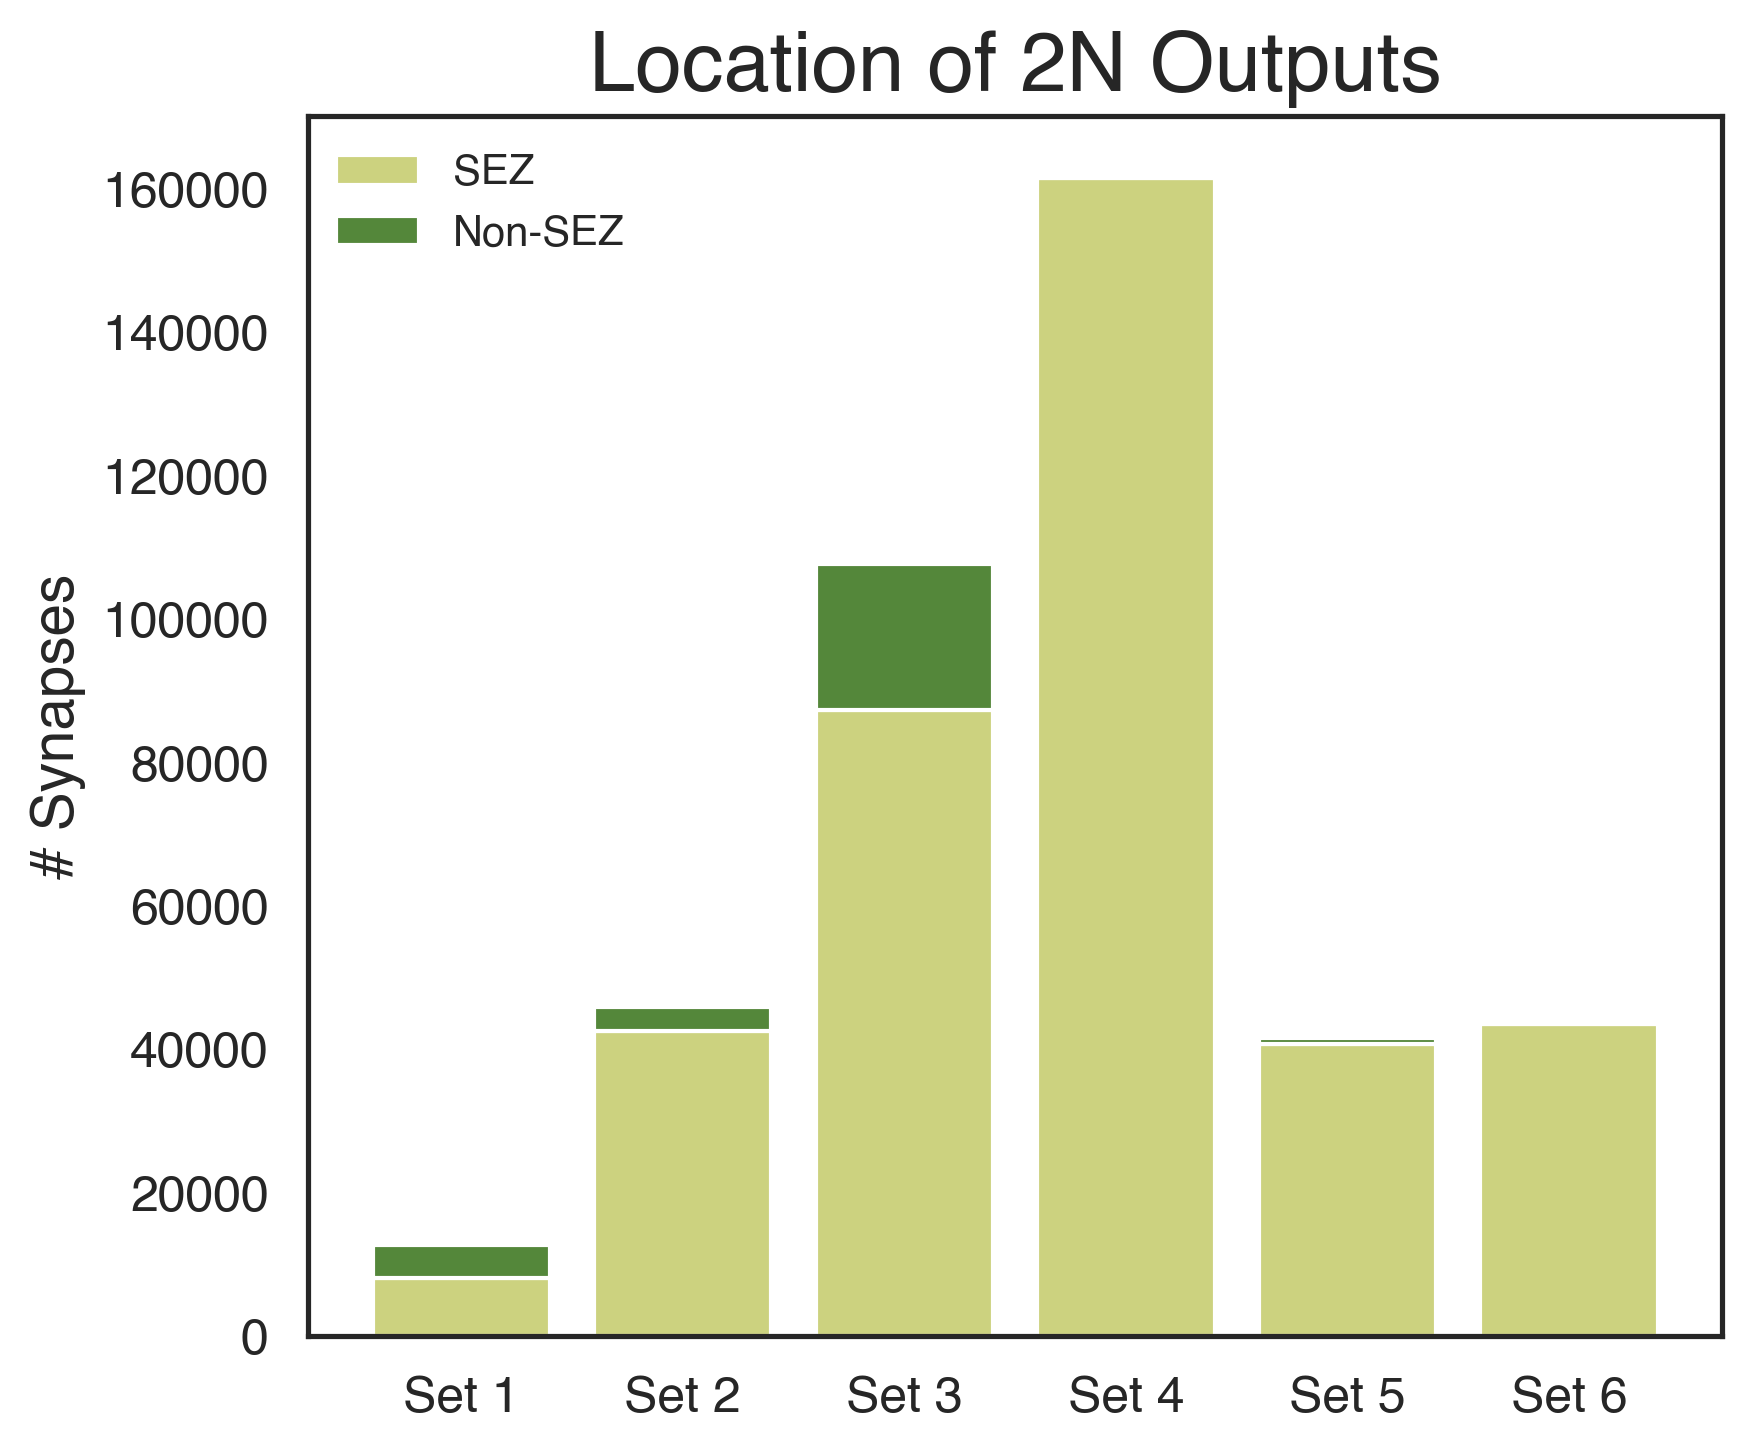

In [39]:
### Location of 2N Outputs (SEZ vs. non-SEZ)

# 1) Number of sets and their labels
n = len(outputs_list)  # outputs_list should already be [set_1_2N_outputs, ..., set_n_2N_outputs]
labels = [f"Set {i}" for i in range(1, n + 1)]

# 2) Compute synapse sums for each dataset
local_synapses = [ds.query("location_of_connection=='local'")['syn_count'].sum() for ds in outputs_list]
projection_synapses = [ds.query("location_of_connection=='outside_SEZ'")['syn_count'].sum() for ds in outputs_list]

# 3) Define bar positions & width
bar_positions = np.arange(n)
bar_width = 0.8

# 4) Plot stacked bar chart
fig, ax = plt.subplots(figsize=(6, 5))
ax.bar(
    bar_positions,
    local_synapses,
    width=bar_width,
    color='#CCD27F',
    label='SEZ'
)
ax.bar(
    bar_positions,
    projection_synapses,
    width=bar_width,
    bottom=local_synapses,
    color='#54873A',
    label='Non-SEZ'
)

# 5) Labels & legend
ax.set_xticks(bar_positions)
ax.set_xticklabels(labels, fontsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_ylabel('# Synapses', fontsize=14)
ax.set_title('Location of 2N Outputs', fontsize=20)
ax.legend(frameon=False, fontsize=10, bbox_to_anchor=(0.25, 1))

# 6) Tidy up & save
plt.tight_layout()
plt.savefig('/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/General - YaoLabUF/SVG_figs/Fig3/Location_of_2N_Outputs.svg', format='svg', bbox_inches='tight')
plt.show()


In [40]:
# Show numbers of local and projection outputs
print(local_synapses)
print(projection_synapses)

[8207, 42533, 87317, 161562, 40796, 43550]
[4511, 3365, 20356, 474, 795, 143]


### Identify 2N superclasses

There are 9 superclasses defined in the connectome, based on gross anatomy. These include neurons that are intrinsic to the brain (central brain neurons, optic lobe neurons, and neurons connecting the optic lobes and central brain), neurons that have connections outside the brain (sensory, motor, ascending, descending), and endocrine neurons. See connectome papers (Dorkenwald et al. and Schlegel et al., 2024) for specific definitions.

In [41]:
# 1) Number of 2N‐sets and their labels
n      = len(twoN_list)
labels = [f"Set {i}" for i in range(1, n+1)]

# 2) Merge each 2N‐set with its superclass
for i, df in enumerate(twoN_list, start=1):
    uniq = df[['root_id']].drop_duplicates()
    cls  = pd.merge(uniq,
                    classification_other[['root_id','super_class']],
                    on='root_id',
                    how='left')
    globals()[f'set_{i}_2Ns_classified'] = cls

In [42]:
# 3) Build counts matrix
supercats = [
    'sensory','ascending','central',
    'descending','motor','endocrine',
    'optic','visual_projection','visual_centrifugal'
]

counts_df = pd.DataFrame(index=supercats, columns=labels, dtype=int)
for i, label in enumerate(labels, start=1):
    vc = globals()[f"set_{i}_2Ns_classified"]['super_class'].value_counts()
    counts_df[label] = vc.reindex(supercats, fill_value=0)


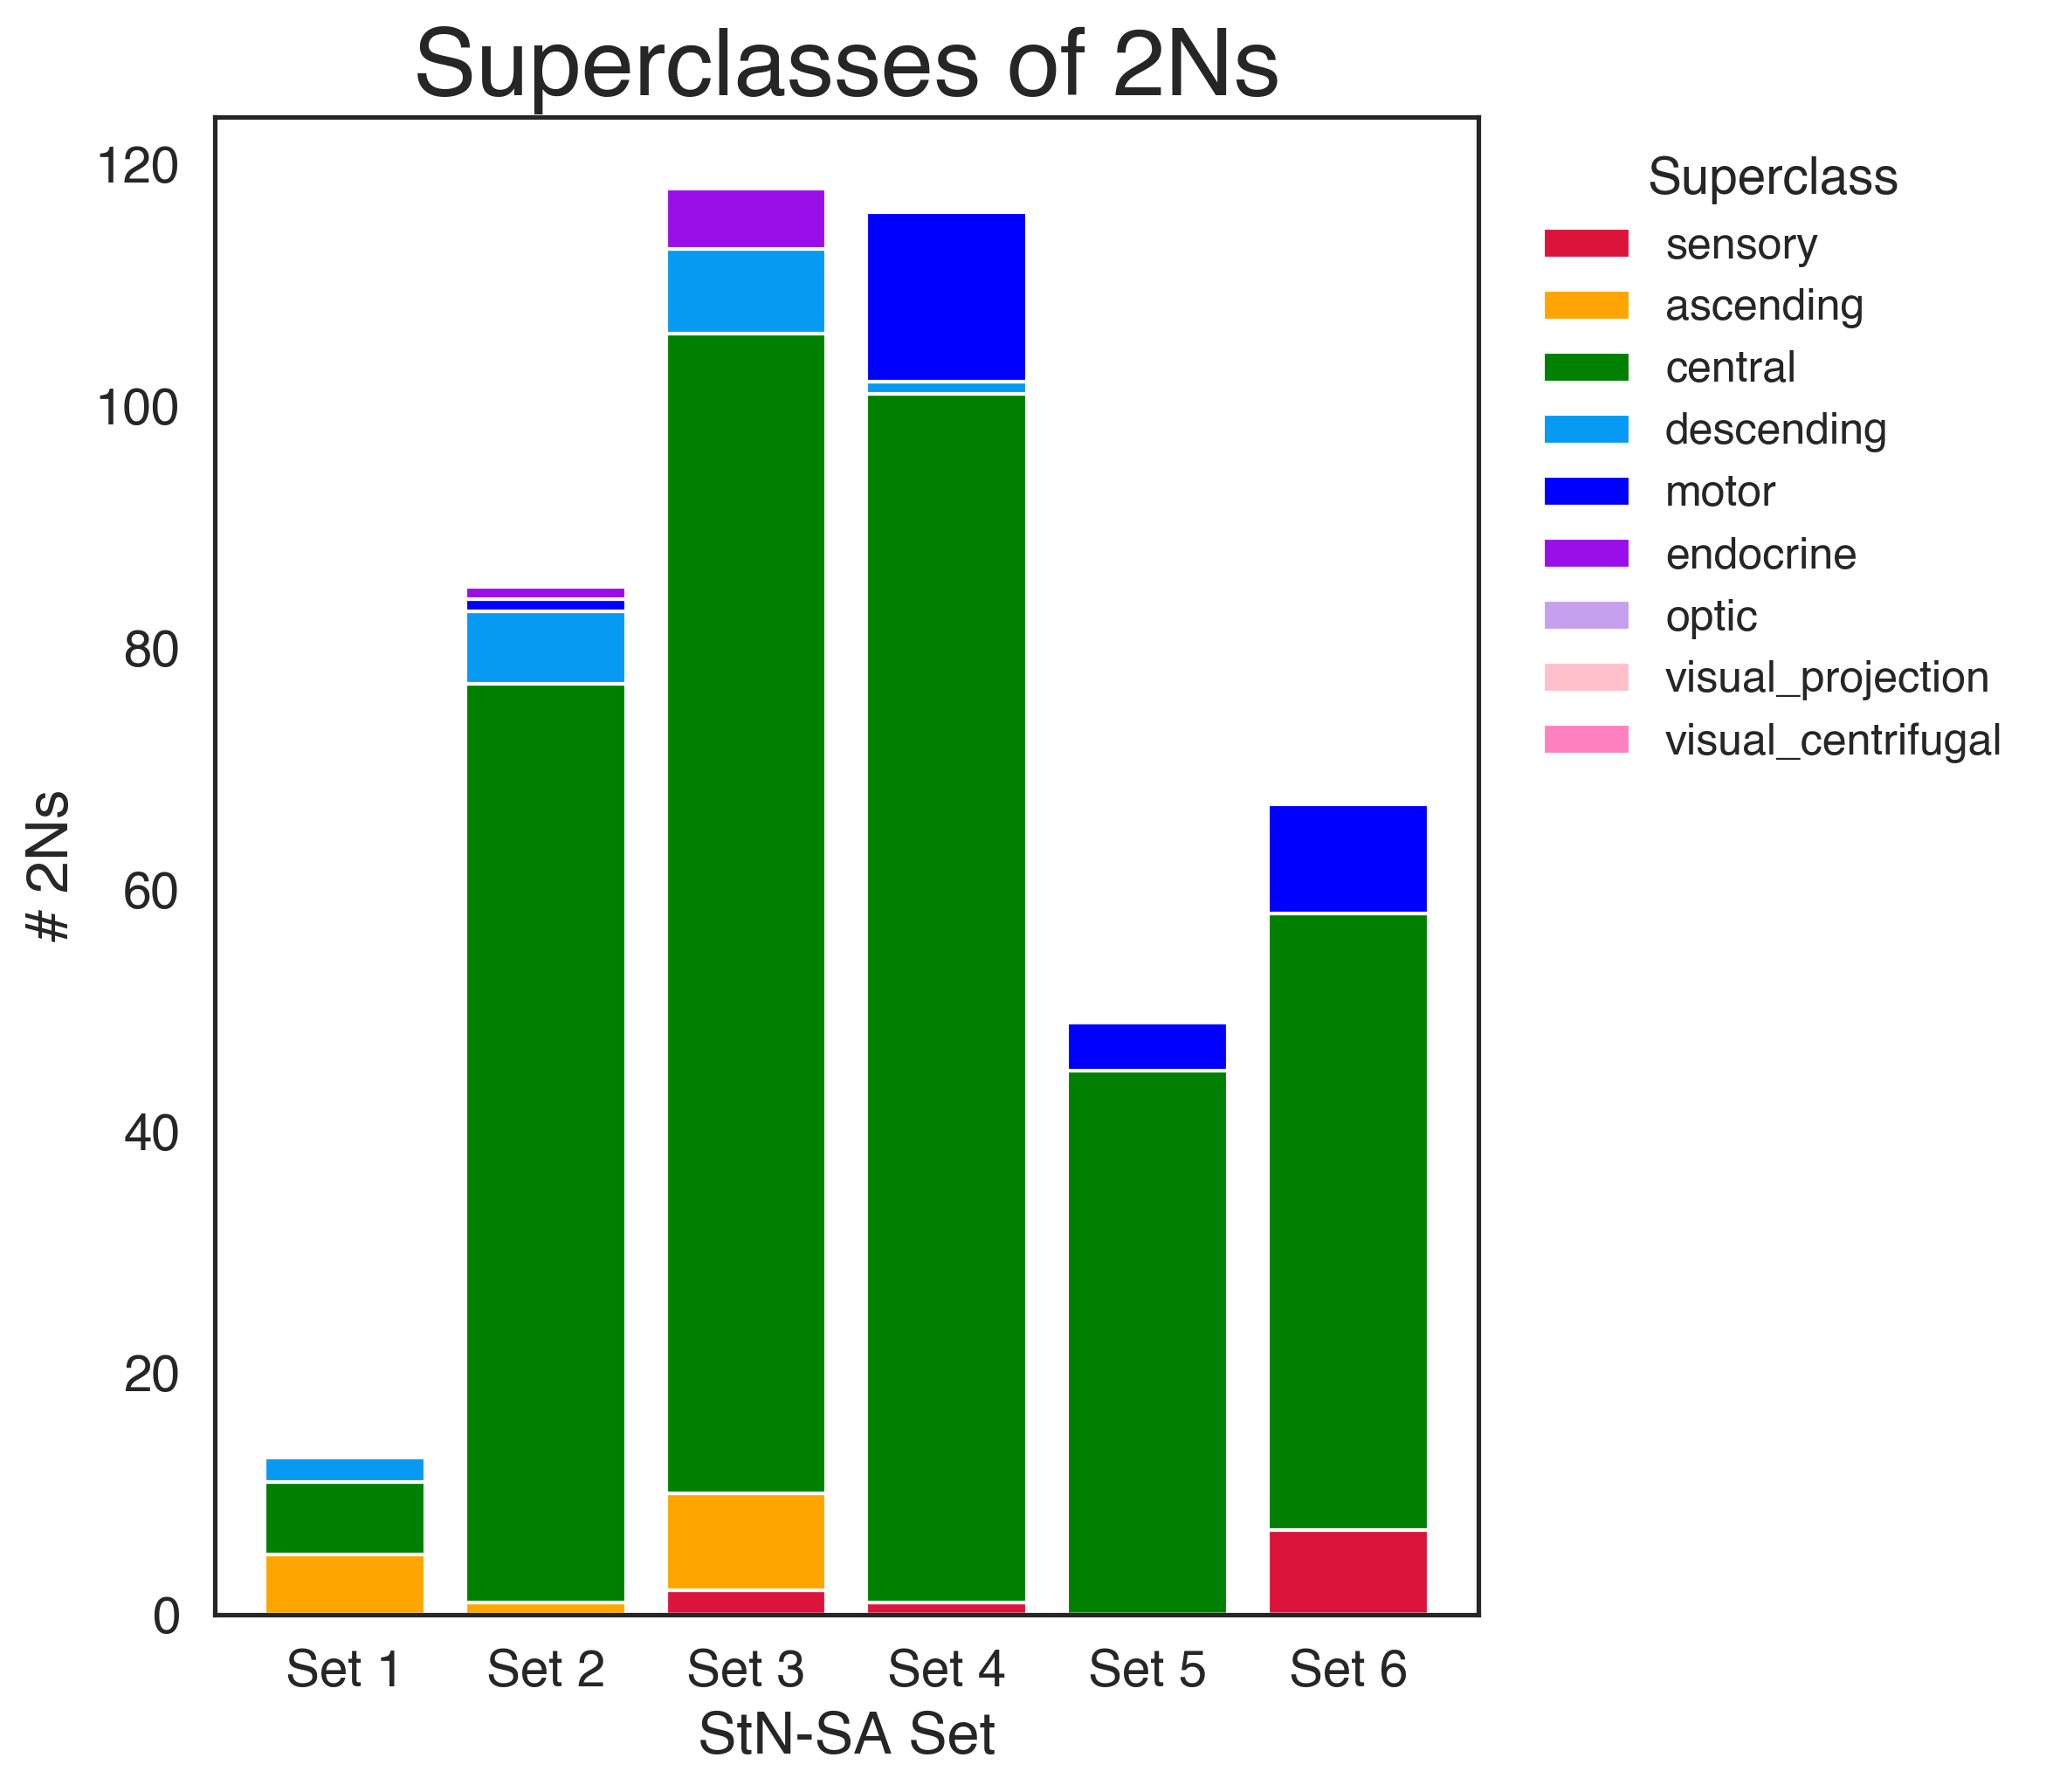

In [43]:
# 4) Plot stacked‐bar
palette = [
    '#dc143c','#ffa500','green','#069af3',
    '#0000ff','#9a0eea','#c79fef','#ffc0cb','#ff81c0'
]
ax = counts_df.T.plot(
    kind='bar',
    stacked=True,
    figsize=(8,7),
    color=palette,
    width=0.8,
    legend=False
)
ax.set_title('Superclasses of 2Ns', fontsize=26)
ax.set_ylabel('# 2Ns', fontsize=16)
ax.set_xlabel('StN-SA Set', fontsize=16)
ax.tick_params(axis='x', labelrotation=0, labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.legend(
    title='Superclass',
    labels=supercats,
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    frameon=False,
    fontsize=12
)
plt.tight_layout()
plt.savefig('/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/General - YaoLabUF/SVG_figs/Fig3/Superclasses_of_2Ns.svg', format='svg', bbox_inches='tight')
plt.show()

In [44]:
### Convert superclass counts to proportions

# Assuming you have `counts_df` from the previous cell,
# where rows = superclasses, cols = sets

# 1) Compute column‐wise proportions (in %)
prop_df = counts_df.divide(counts_df.sum(axis=0), axis=1) * 100

# 2) Display
print("Raw counts (counts_df):")
print(counts_df)
print("\nProportions (% of 2Ns in each set by superclass):")
print(prop_df)

# 3) If you want a NumPy array of proportions (supercats × sets), you can do:
array_plot_prop = prop_df.values


Raw counts (counts_df):
                    Set 1  Set 2  Set 3  Set 4  Set 5  Set 6
sensory                 0      0      2      1      0      7
ascending               5      1      8      0      0      0
central                 6     76     96    100     45     51
descending              2      6      7      1      0      0
motor                   0      1      0     14      4      9
endocrine               0      1      5      0      0      0
optic                   0      0      0      0      0      0
visual_projection       0      0      0      0      0      0
visual_centrifugal      0      0      0      0      0      0

Proportions (% of 2Ns in each set by superclass):
                        Set 1      Set 2      Set 3      Set 4      Set 5  \
sensory              0.000000   0.000000   1.694915   0.862069   0.000000   
ascending           38.461538   1.176471   6.779661   0.000000   0.000000   
central             46.153846  89.411765  81.355932  86.206897  91.836735   
descend

In [45]:
### Inspect raw counts and proportions

# Raw counts array (shape: #superclasses × #sets)
raw_counts = counts_df.values
print("raw_counts:\n", raw_counts)

# Proportions array
print("\narray_plot_prop (%):\n", array_plot_prop)


raw_counts:
 [[  0   0   2   1   0   7]
 [  5   1   8   0   0   0]
 [  6  76  96 100  45  51]
 [  2   6   7   1   0   0]
 [  0   1   0  14   4   9]
 [  0   1   5   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]]

array_plot_prop (%):
 [[ 0.          0.          1.69491525  0.86206897  0.         10.44776119]
 [38.46153846  1.17647059  6.77966102  0.          0.          0.        ]
 [46.15384615 89.41176471 81.3559322  86.20689655 91.83673469 76.11940299]
 [15.38461538  7.05882353  5.93220339  0.86206897  0.          0.        ]
 [ 0.          1.17647059  0.         12.06896552  8.16326531 13.43283582]
 [ 0.          1.17647059  4.23728814  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]]


In [46]:
### Alternative: get proportions directly from the NumPy counts array

# If for some reason you still want to use the old `array_plot`,
# but generalized to dynamic number of sets, you can rebuild it:

# array_plot: shape (n_superclasses, n_sets)
array_plot = counts_df.values

# proportions for each superclass across sets
array_plot_prop = (array_plot / array_plot.sum(axis=0, keepdims=True)) * 100

print("array_plot_prop (NumPy %):\n", array_plot_prop)


array_plot_prop (NumPy %):
 [[ 0.          0.          1.69491525  0.86206897  0.         10.44776119]
 [38.46153846  1.17647059  6.77966102  0.          0.          0.        ]
 [46.15384615 89.41176471 81.3559322  86.20689655 91.83673469 76.11940299]
 [15.38461538  7.05882353  5.93220339  0.86206897  0.          0.        ]
 [ 0.          1.17647059  0.         12.06896552  8.16326531 13.43283582]
 [ 0.          1.17647059  4.23728814  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]]


### Quantify the neurotransmitter types for local and projection 2N outputs across modalities

We are only including ACH, GABA, GLUT neurotransmitter types here, which represent the vast majority of 2N synapses.

Note that this analysis quantifies 2N outputs by the number of connections, not synapses.

In [47]:
def count_NTs_local(datasets, NTs):
    """
    Returns a dict mapping each nt to an array of # of *connections*
    in local outputs for each dataset.
    """
    counts = {nt: [] for nt in NTs}
    for ds in datasets:
        local = ds.query("location_of_connection == 'local'")
        for nt in NTs:
            counts[nt].append((local.nt_type == nt).sum())
    # convert each list to a NumPy array
    return {nt: np.array(v) for nt, v in counts.items()}


def count_neurons_local(datasets, NTs):
    """
    Returns a dict mapping each nt to an array of # of *unique neurons*
    in local outputs for each dataset.
    """
    neurons = {nt: [] for nt in NTs}
    for ds in datasets:
        local = ds.query("location_of_connection == 'local'")
        for nt in NTs:
            neurons[nt].append(local.query("nt_type == @nt")['pre_root_id'].nunique())
    return {nt: np.array(v) for nt, v in neurons.items()}


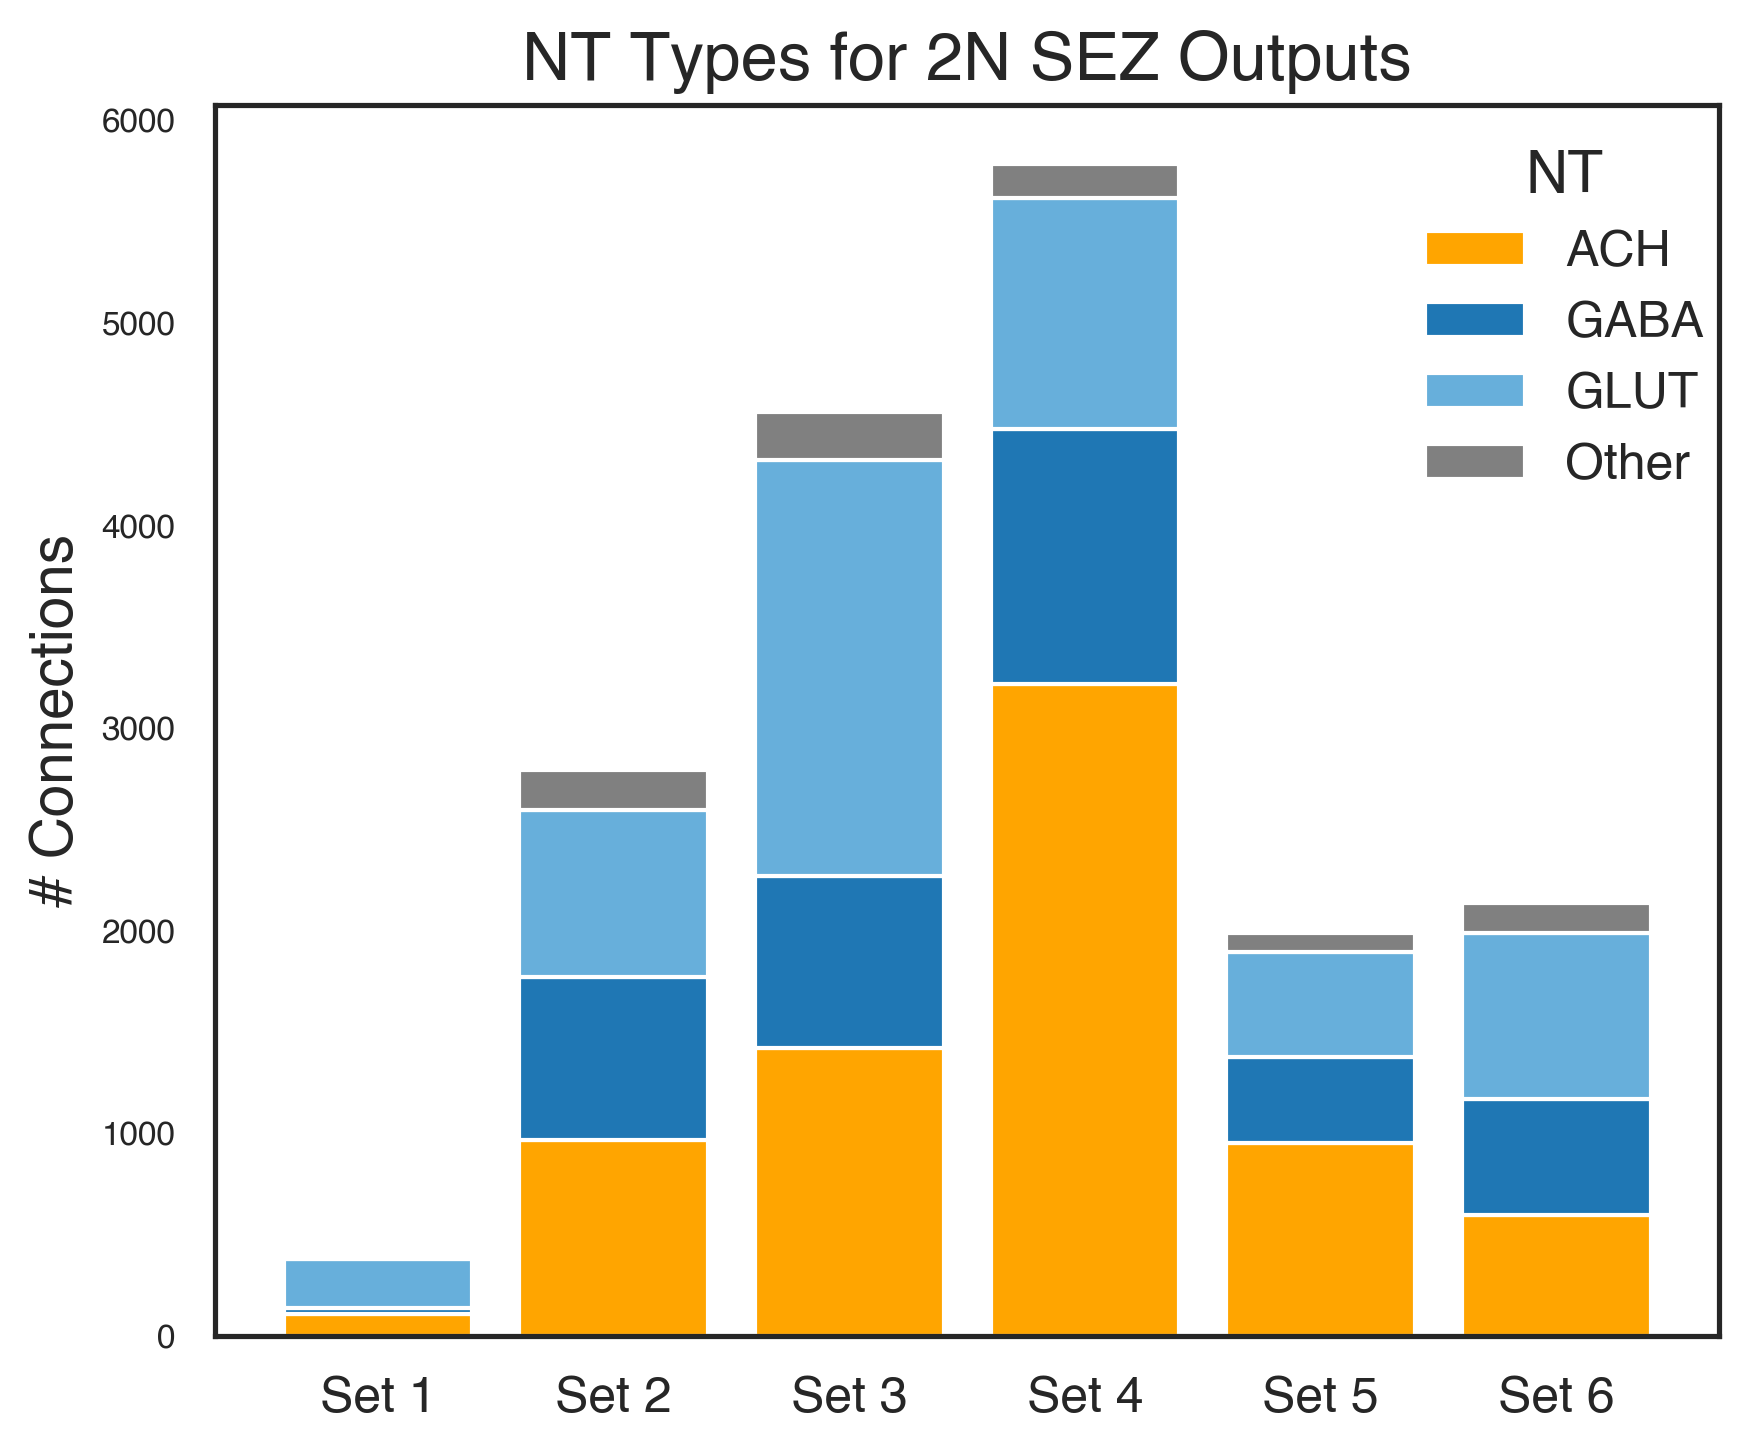

In [48]:
### Quantify neurotransmitter types for local 2N outputs across sets

# 1) Define neurotransmitter categories
NT_primary = ['ACH', 'GABA', 'GLUT']
NT_other = ['SER', 'DA']

# 2) Gather your dynamic list of 2N‐output DataFrames
#    (assumes you already built `outputs_list = [set_1_2N_outputs, …, set_n_2N_outputs]`)
datasets = outputs_list

# 3) Build dynamic labels
n = len(datasets)
modalities = [f"Set {i}" for i in range(1, n + 1)]


# 4) Counting functions (same as before)
def count_NTs_local_with_other(dsets, primaries, others):
    """
    Returns four arrays for [ACH, GABA, GLUT, Other=SER+DA] counts of *connections*
    in SEZ (local) outputs for each dataset.
    """
    counts = {nt: [] for nt in primaries + ['Other']}
    for ds in dsets:
        # primary NT counts
        for nt in primaries:
            counts[nt].append(
                ds.query("location_of_connection=='local' and nt_type==@nt").shape[0]
            )
        # Other = SER or DA
        counts['Other'].append(
            ds.query("location_of_connection=='local' and nt_type in @others").shape[0]
        )
    return [np.array(counts[nt]) for nt in primaries + ['Other']]


def count_neurons_local_with_other(dsets, primaries, others):
    """
    Returns four arrays for [ACH, GABA, GLUT, Other] counts of *unique neurons*
    driving SEZ outputs for each dataset.
    """
    uniq = {nt: [] for nt in primaries + ['Other']}
    for ds in dsets:
        for nt in primaries:
            uniq[nt].append(
                ds.query("location_of_connection=='local' and nt_type==@nt")['pre_root_id'].nunique()
            )
        uniq['Other'].append(
            ds.query("location_of_connection=='local' and nt_type in @others")['pre_root_id'].nunique()
        )
    return [np.array(uniq[nt]) for nt in primaries + ['Other']]


# 5) Compute synapse‐counts and neuron‐counts
syn_counts = count_NTs_local_with_other(datasets, NT_primary, NT_other)
cell_counts = count_neurons_local_with_other(datasets, NT_primary, NT_other)

# 6) Plot stacked bars
fig, ax = plt.subplots(figsize=(6, 5))
bar_pos = np.arange(n)
width = 0.8
colors = ['orange', '#1f77b4', '#67afdb', 'gray']  # last for Other

bottom = np.zeros(n, dtype=int)
for arr, col in zip(syn_counts, colors):
    ax.bar(bar_pos, arr, width=width, bottom=bottom, color=col)
    bottom += arr

# 7) Labels & legend
ax.set_xticks(bar_pos)
ax.set_xticklabels(modalities, fontsize=12)
ax.set_ylabel('# Connections', fontsize=14)
ax.set_title('NT Types for 2N SEZ Outputs', fontsize=16)
ax.legend(NT_primary + ['Other'], title='NT', frameon=False, bbox_to_anchor=(1.02, 1), fontsize=12)

plt.tight_layout()
plt.savefig('/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/General - YaoLabUF/SVG_figs/Fig3/NT_Types_2N_SEZ_Outputs.svg', format='svg', bbox_inches='tight')
plt.show()


In [49]:
### Summary of local NT outputs & unique neurons for each set

# 1) Make sure these are defined from the previous analysis:
#    - `syn_counts`  = [ACH_counts, GABA_counts, GLUT_counts, Other_counts]
#    - `cell_counts` = [ACH_neuron_counts, GABA_neuron_counts, GLUT_neuron_counts, Other_neuron_counts]
#    - `NT_primary`  = ['ACH','GABA','GLUT']
#    - `NT_other`    = ['SER','DA']
#    - `outputs_list` = [set_1_2N_outputs, …, set_n_2N_outputs]

# 2) Build dynamic labels and NT list
n = len(outputs_list)
modalities = [f"Set {i}" for i in range(1, n + 1)]
NTs = NT_primary + ['Other']
variables = syn_counts  # list of 4 arrays: [ACH, GABA, GLUT, Other]
neurons = cell_counts  # list of 4 arrays: same order

# 3) Print summary table
for idx, label in enumerate(modalities):
    print(f"{label}:")
    for nt_idx, nt in enumerate(NTs):
        out_count = variables[nt_idx][idx]
        neu_count = neurons[nt_idx][idx]
        print(f"  {nt}: outputs = {out_count}, unique neurons = {neu_count}")
    print()

### Detailed neuron IDs for each NT and set

for idx, label in enumerate(modalities):
    ds = outputs_list[idx]
    print(f"{label}:")
    for nt in NT_primary:
        df_nt = ds.query("location_of_connection=='local' and nt_type==@nt")
        n_out = len(df_nt)
        n_neu = df_nt['pre_root_id'].nunique()
        ids = df_nt['pre_root_id'].unique()
        print(f"  NT = {nt}: outputs={n_out}, unique neurons={n_neu}, IDs={ids}")
    # handle Other (SER+DA)
    df_other = ds.query("location_of_connection=='local' and nt_type in @NT_other")
    n_out = len(df_other)
    n_neu = df_other['pre_root_id'].nunique()
    ids = df_other['pre_root_id'].unique()
    print(f"  NT = Other (SER+DA): outputs={n_out}, unique neurons={n_neu}, IDs={ids}\n")

### Total number of 2Ns per set

for i, label in enumerate(modalities, start=1):
    df2n = globals()[f"set_{i}_2Ns"]
    total = df2n['root_id'].nunique()
    print(f"{label} total 2Ns: {total}")


Set 1:
  ACH: outputs = 110, unique neurons = 9
  GABA: outputs = 31, unique neurons = 1
  GLUT: outputs = 242, unique neurons = 9
  Other: outputs = 10, unique neurons = 5

Set 2:
  ACH: outputs = 968, unique neurons = 63
  GABA: outputs = 806, unique neurons = 28
  GLUT: outputs = 825, unique neurons = 39
  Other: outputs = 199, unique neurons = 34

Set 3:
  ACH: outputs = 1424, unique neurons = 77
  GABA: outputs = 851, unique neurons = 21
  GLUT: outputs = 2049, unique neurons = 55
  Other: outputs = 240, unique neurons = 51

Set 4:
  ACH: outputs = 3222, unique neurons = 95
  GABA: outputs = 1256, unique neurons = 33
  GLUT: outputs = 1143, unique neurons = 40
  Other: outputs = 168, unique neurons = 20

Set 5:
  ACH: outputs = 956, unique neurons = 34
  GABA: outputs = 421, unique neurons = 8
  GLUT: outputs = 522, unique neurons = 15
  Other: outputs = 91, unique neurons = 16

Set 6:
  ACH: outputs = 598, unique neurons = 21
  GABA: outputs = 575, unique neurons = 20
  GLUT: out

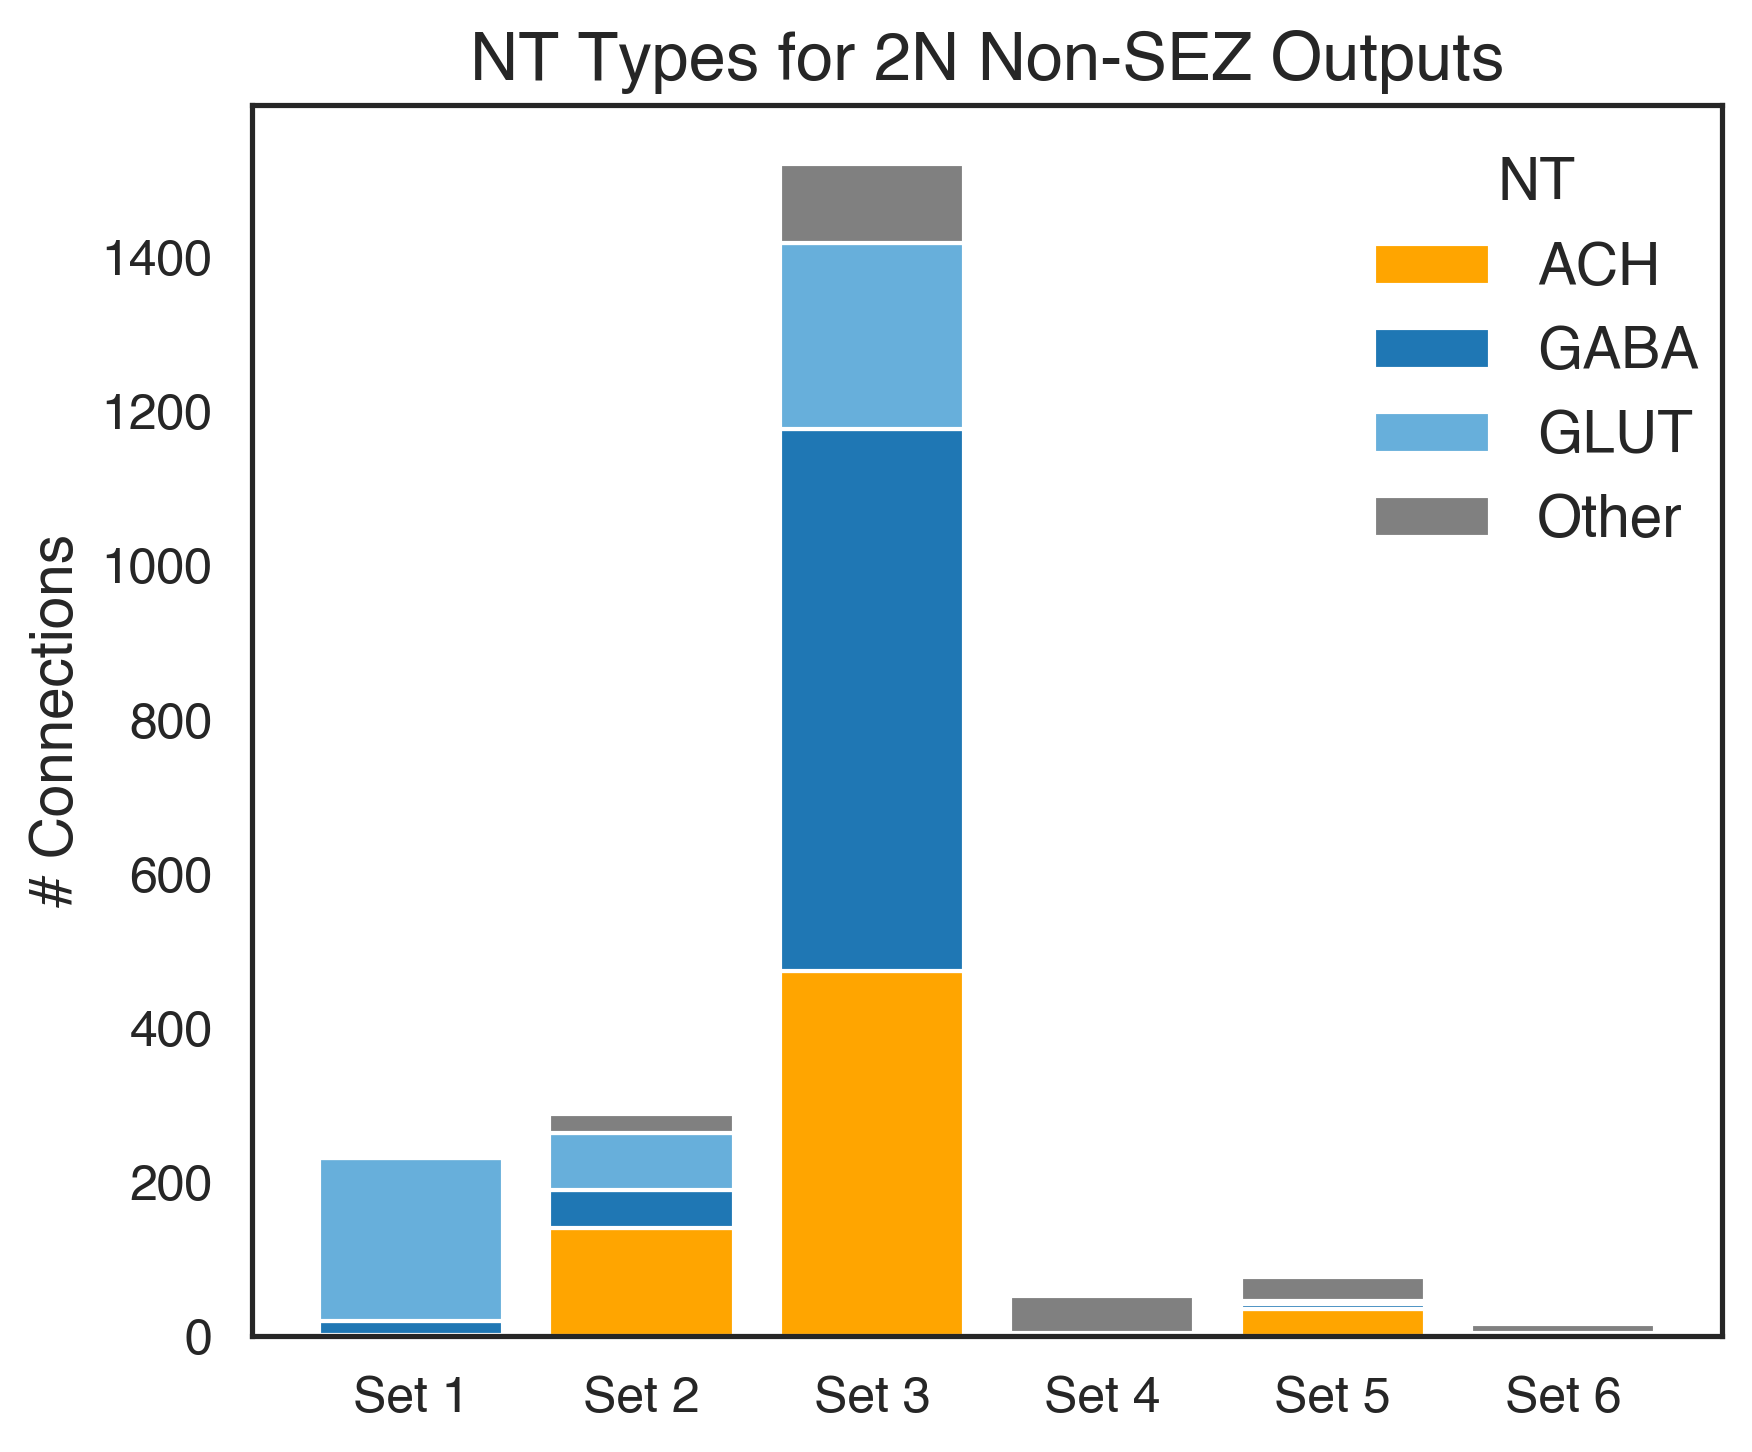

In [50]:
### NT types for 2N non-SEZ outputs (stacked bar, dynamic for any number of sets)

# 1) Define all NTs (we'll merge DA+SER into "Other")
all_NTs = ['ACH', 'GABA', 'GLUT', 'DA', 'SER']


# 2) Function to count projection‐side connections by NT
def count_NTs_proj(dsets, nts):
    counts = {nt: [] for nt in nts}
    for ds in dsets:
        proj = ds.query("location_of_connection=='outside_SEZ'")
        for nt in nts:
            counts[nt].append((proj['nt_type'] == nt).sum())
    return {nt: np.array(v) for nt, v in counts.items()}


# 3) Use your dynamic list of 2N-output DataFrames
datasets = outputs_list  # e.g. [set_1_2N_outputs, set_2_2N_outputs, …]
n = len(datasets)
labels = [f"Set {i}" for i in range(1, n + 1)]

# 4) Compute raw counts
conn_proj = count_NTs_proj(datasets, all_NTs)

# 5) Merge DA+SER into "Other"
other_proj = conn_proj['DA'] + conn_proj['SER']

# 6) Prepare for plotting
plot_NTs = ['ACH', 'GABA', 'GLUT', 'Other']
plot_conn_proj = {
    'ACH': conn_proj['ACH'],
    'GABA': conn_proj['GABA'],
    'GLUT': conn_proj['GLUT'],
    'Other': other_proj
}
color_map = {
    'ACH': 'orange',
    'GABA': '#1f77b4',
    'GLUT': '#67afdb',
    'Other': 'gray'
}

# 7) Draw the stacked-bar chart
fig, ax = plt.subplots(figsize=(6, 5))
bar_x = np.arange(n)
bottom = np.zeros(n, dtype=int)

for nt in plot_NTs:
    vals = plot_conn_proj[nt]
    ax.bar(
        bar_x, vals, 0.8,
        bottom=bottom,
        label=nt,
        color=color_map[nt]
    )
    bottom += vals

# 8) Final formatting
ax.set_xticks(bar_x)
ax.set_xticklabels(labels, fontsize=12)
ax.set_ylabel('# Connections', fontsize=14)
ax.set_title('NT Types for 2N Non-SEZ Outputs', fontsize=16)
ax.tick_params(axis='y', labelsize=12)
ax.legend(title='NT', frameon=False, bbox_to_anchor=(1.02, 1))

plt.tight_layout()
plt.savefig('/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/General - YaoLabUF/SVG_figs/Fig3/NT_Types_2N_NonSEZ_Outputs.svg', format='svg', bbox_inches='tight')
plt.show()


In [51]:
# Show numbers of outputs for each NT type
variables

[array([ 110,  968, 1424, 3222,  956,  598]),
 array([  31,  806,  851, 1256,  421,  575]),
 array([ 242,  825, 2049, 1143,  522,  816]),
 array([ 10, 199, 240, 168,  91, 151])]

### Quantify 2N projections to each brain region

Start by consolidating bilateral brain regions for second order outputs.

In [52]:
# Creates a new column with region names excluding side
original_neuropil_list = connections['neuropil'].unique()
region_mapping = {}
for neuropil in original_neuropil_list:
    if neuropil.endswith('_L') or neuropil.endswith('_R'):
        prefix = neuropil[:-2]
        region_mapping[neuropil] = prefix
    else:
        region_mapping[neuropil] = neuropil

In [53]:
# Apply neuropil remapping for all sets in outputs_list
for df in outputs_list:
    df['neuropil_remap'] = df['neuropil'].map(lambda x: region_mapping.get(x, x))


### Create bar graphs of non-SEZ brain regions with 2N outputs

In [54]:
# Get the top 12 non-SEZ brain regions for 2N outputs for each set

def get_top12_regions(outputs):
    # Sum over neuropil_remap
    synapses_by_region = outputs.groupby('neuropil_remap')['syn_count'].sum()
    # Exclude SEZ regions
    synapses_by_region = synapses_by_region.drop(['GNG', 'PRW', 'SAD', 'FLA', 'CAN'], errors='ignore')
    # Top 12 regions
    top12 = list(synapses_by_region.sort_values().index[-12:])
    return top12

# Use a list comprehension for all sets
top12_per_set = [get_top12_regions(df) for df in outputs_list]

# Print results
for i, top12 in enumerate(top12_per_set, start=1):
    print(f"Set {i} top12: {top12}")


Set 1 top12: ['MB_VL', 'SMP']
Set 2 top12: ['SLP', 'MB_ML', 'AL', 'SMP']
Set 3 top12: ['LH', 'VES', 'SCL', 'PVLP', 'IB', 'AVLP', 'PLP', 'SPS', 'GOR', 'SLP', 'ICL', 'SMP']
Set 4 top12: ['AL', 'ICL', 'SMP']
Set 5 top12: ['AL', 'MB_ML', 'VES', 'SMP']
Set 6 top12: ['AL', 'SMP']


In [55]:
# Get all regions that appear in the "top 6" of any set
all_regions_StNSA = set()
for top12 in top12_per_set:
    all_regions_StNSA.update(top12[-6:])  # last 6 elements (highest counts)
all_regions_StNSA = list(all_regions_StNSA)
print(all_regions_StNSA)


['SPS', 'MB_ML', 'AL', 'MB_VL', 'ICL', 'SLP', 'SMP', 'PLP', 'VES', 'GOR']


In [56]:
categories_StNSA = ['MB_VL', 'AL', 'MB_ML', 'SMP']
NTs_StNSA = ['ACH','GABA','GLUT','DA','SER']


In [57]:
def count_NTs_StNSA_brainregions(datasets_array, NTs_array):
    ACH_connections   = []
    GABA_connections  = []
    GLUT_connections  = []
    Other_connections = []
    for dataset in datasets_array:
        ACH_connections.append(dataset.query("nt_type == @NTs_array[0]")['syn_count'].sum())
        GABA_connections.append(dataset.query("nt_type == @NTs_array[1]")['syn_count'].sum())
        GLUT_connections.append(dataset.query("nt_type == @NTs_array[2]")['syn_count'].sum())
        Other_connections.append(
            dataset.query("nt_type == @NTs_array[3]")['syn_count'].sum() +
            dataset.query("nt_type == @NTs_array[4]")['syn_count'].sum()
        )
    return (
        np.array(ACH_connections),
        np.array(GABA_connections),
        np.array(GLUT_connections),
        np.array(Other_connections)
    )


In [58]:
# Example: capture fraction of non-SEZ outputs in the last set
total_proj_synapses = outputs_list[-1][outputs_list[-1]['location_of_connection'] == 'outside_SEZ']['syn_count'].sum()
captured_projection_synapses = sum(sum(variables)) / total_proj_synapses
print("Captured projection synapses fraction:", captured_projection_synapses)


Captured projection synapses fraction: 123.5944055944056


In [59]:
# Concatenate all 2N outputs (all sets)
all_2N = pd.concat(outputs_list, ignore_index=True)
# Apply neuropil remap
all_2N['neuropil_remap'] = all_2N['neuropil'].map(lambda x: region_mapping.get(x, x))
# Top 12 non-SEZ
syn_by_region = all_2N.groupby('neuropil_remap')['syn_count'].sum().drop(['GNG', 'PRW', 'SAD', 'FLA', 'CAN'], errors='ignore')
top12_regions = syn_by_region.sort_values(ascending=False).index[:12].tolist()
print("Global top-12 non-SEZ regions:", top12_regions)


Global top-12 non-SEZ regions: ['SMP', 'ICL', 'SLP', 'GOR', 'SPS', 'PLP', 'AVLP', 'IB', 'PVLP', 'VES', 'SCL', 'LH']


In [60]:
def count_NTs_region_list(df, regions):
    ach, gaba, glut, da, ser = [], [], [], [], []
    for r in regions:
        sub = df[df.neuropil_remap == r]
        ach.append(sub.query("nt_type=='ACH'")['syn_count'].sum())
        gaba.append(sub.query("nt_type=='GABA'")['syn_count'].sum())
        glut.append(sub.query("nt_type=='GLUT'")['syn_count'].sum())
        da.append(sub.query("nt_type=='DA'")['syn_count'].sum())
        ser.append(sub.query("nt_type=='SER'")['syn_count'].sum())
    ach, gaba, glut, da, ser = map(np.array, (ach, gaba, glut, da, ser))
    other = da + ser
    return ach, gaba, glut, other


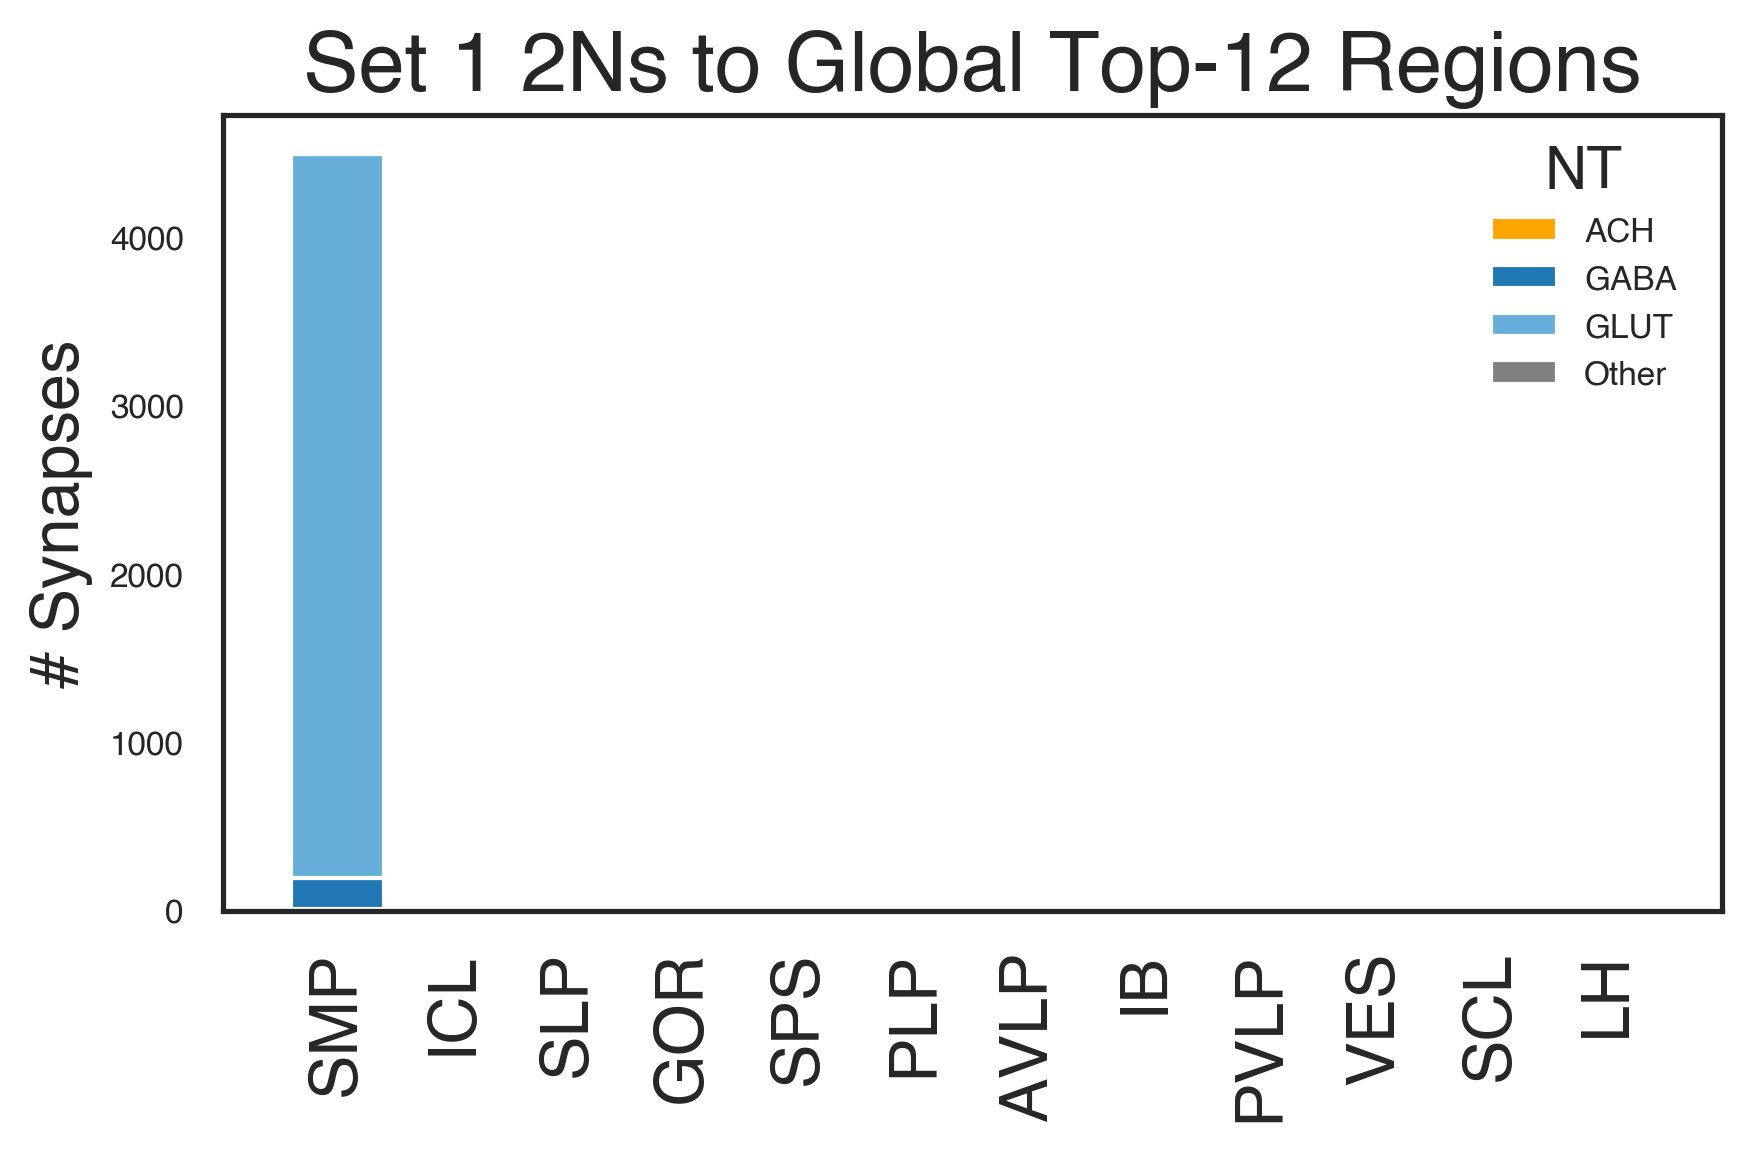

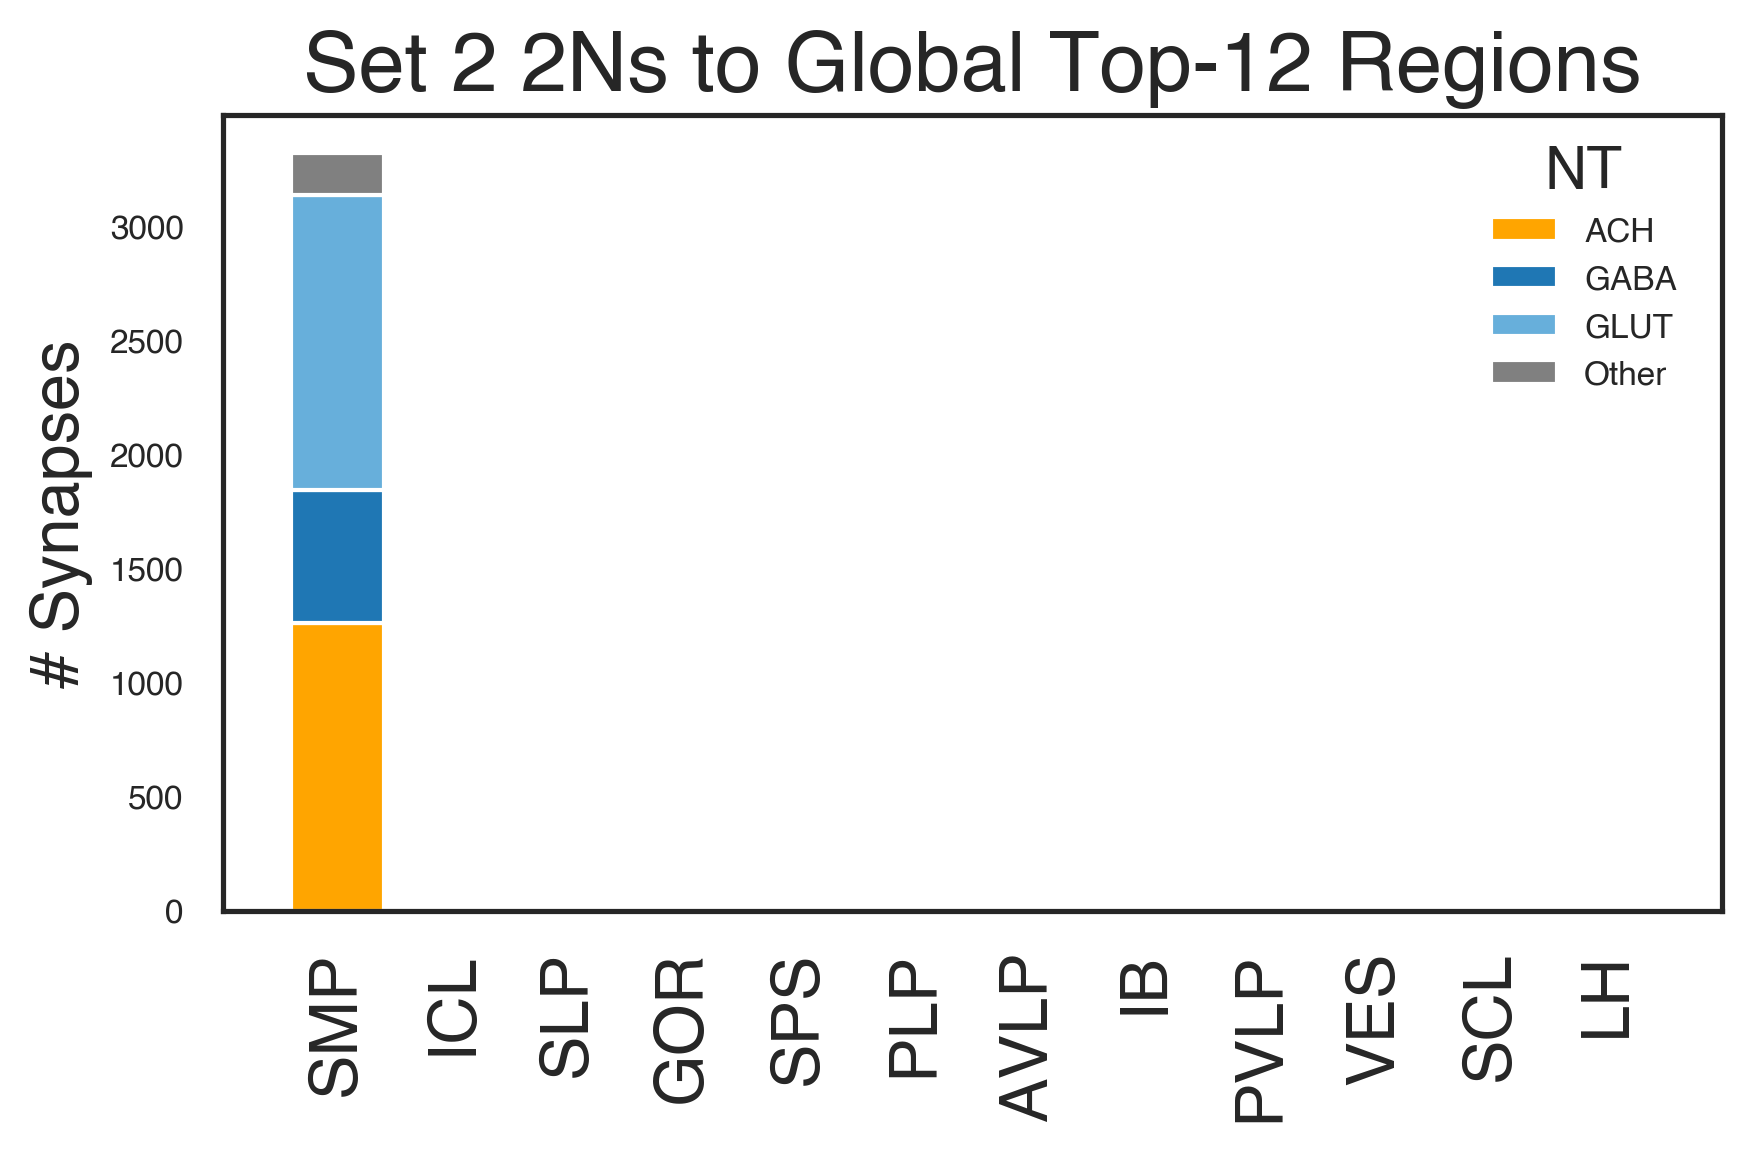

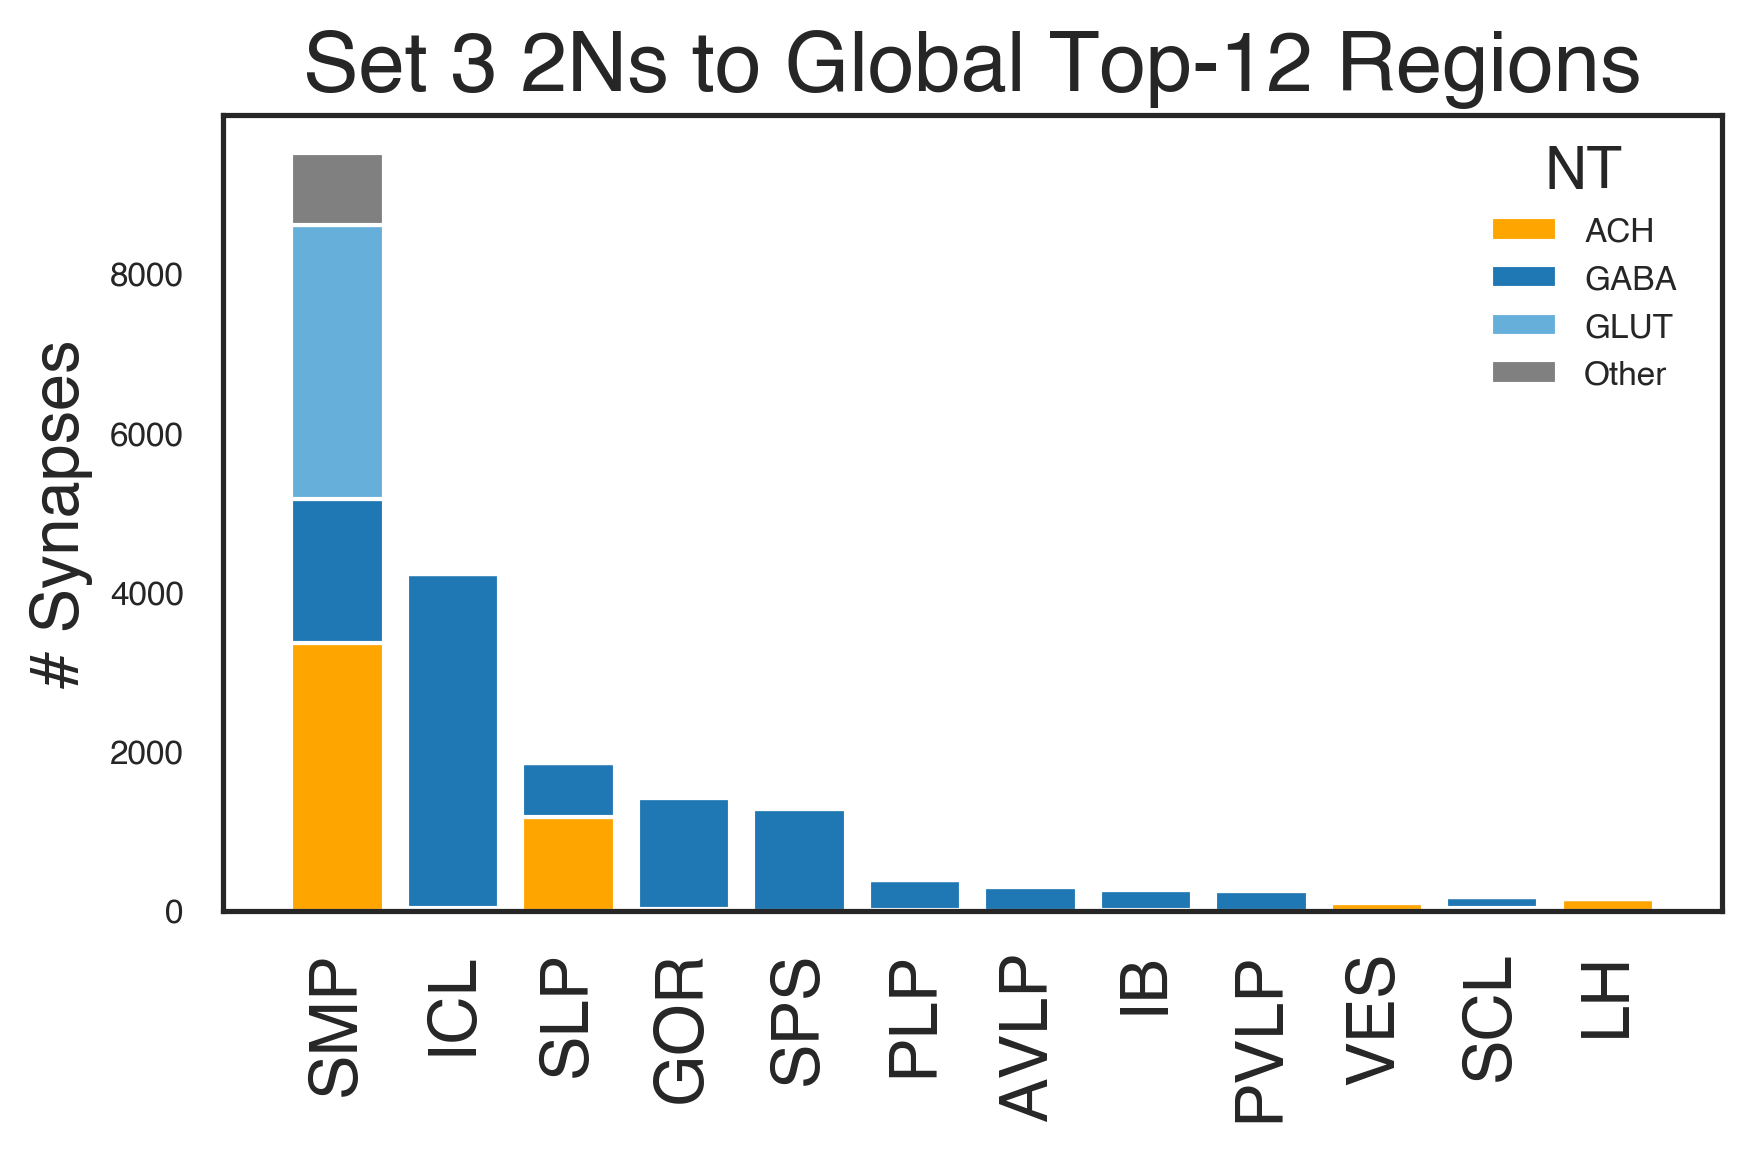

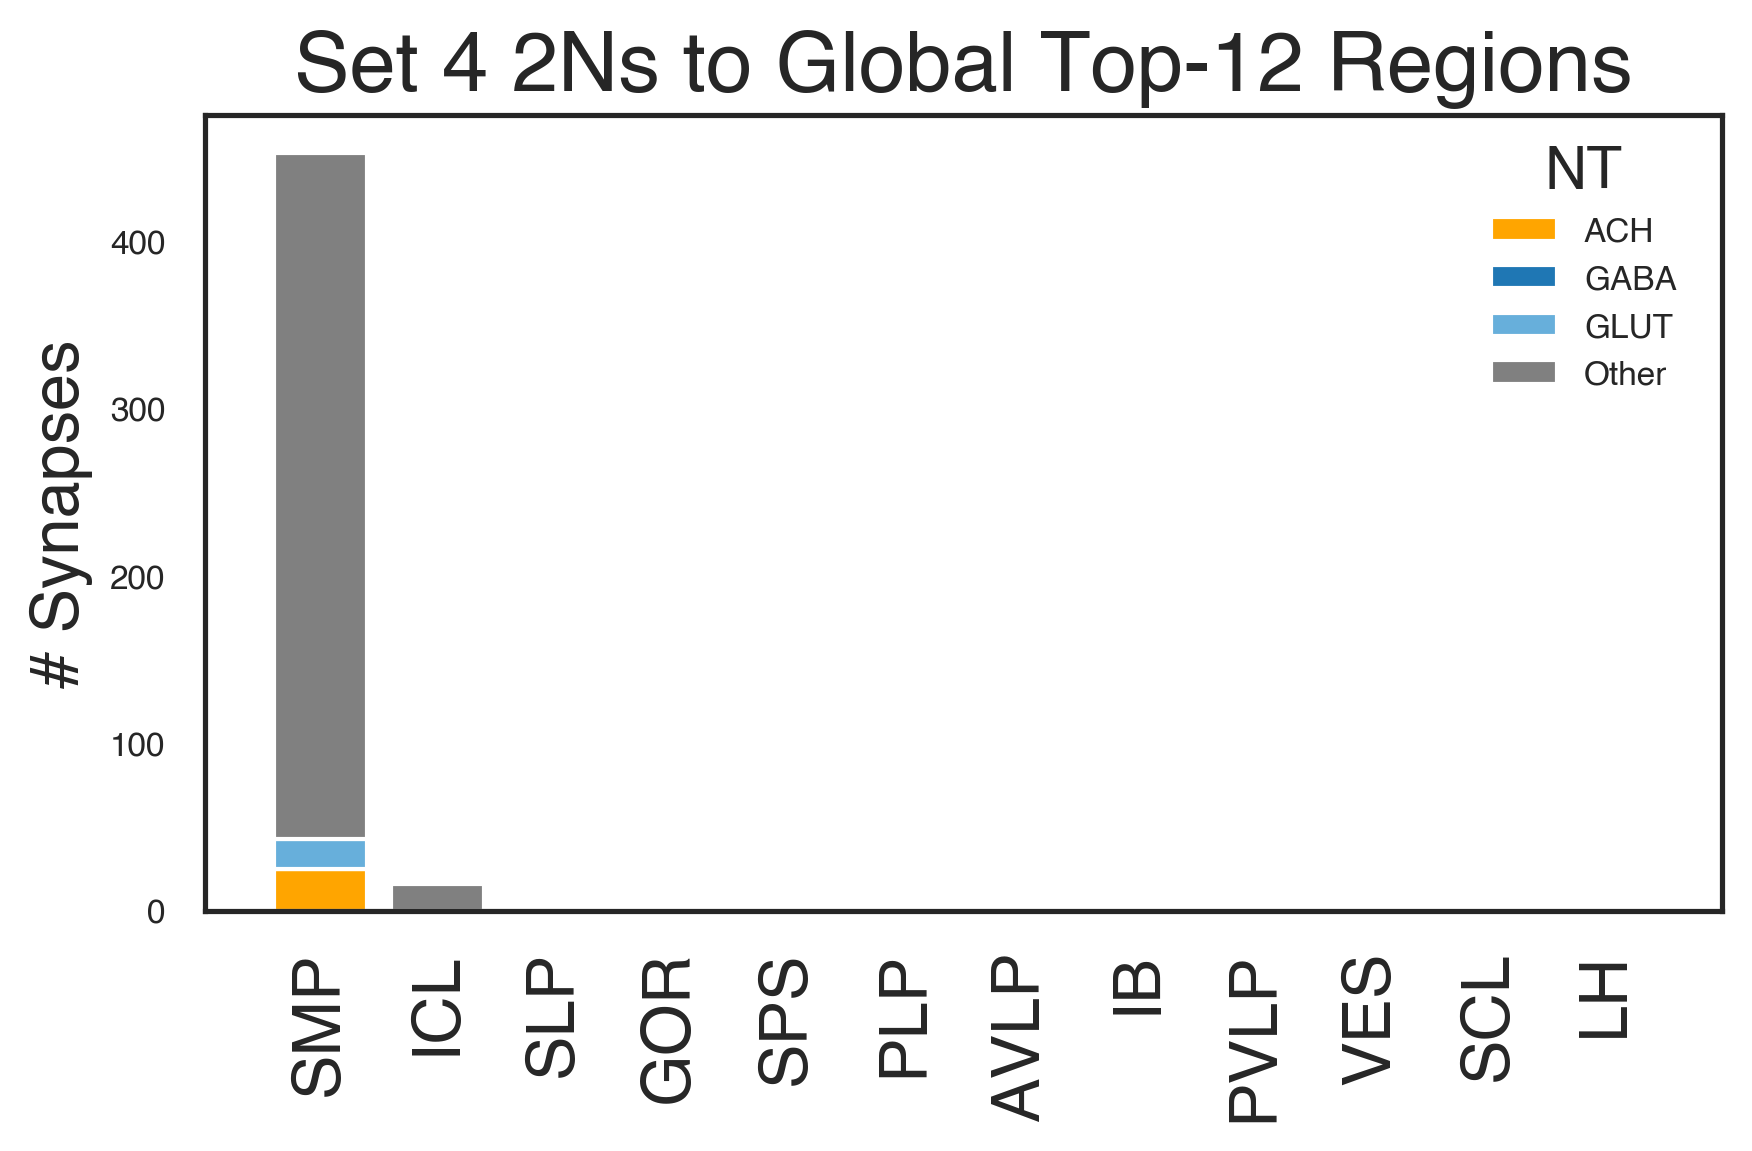

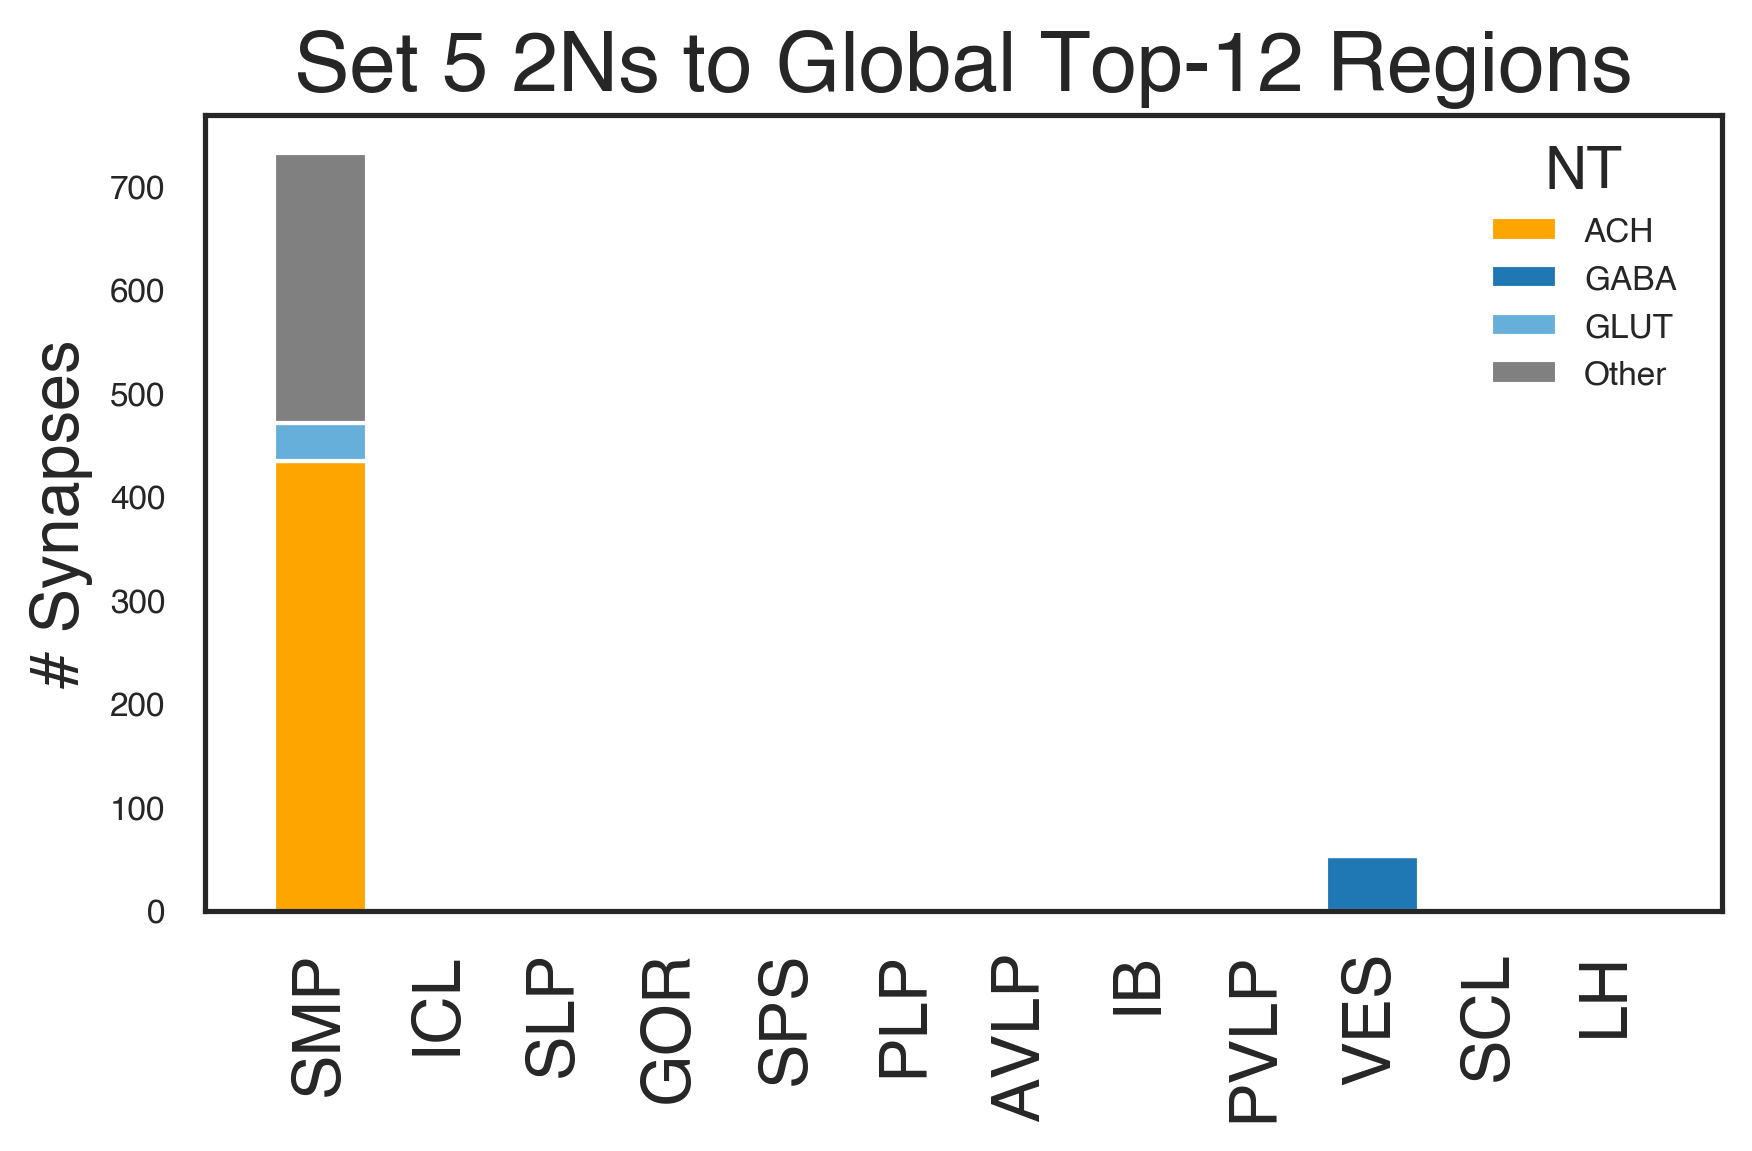

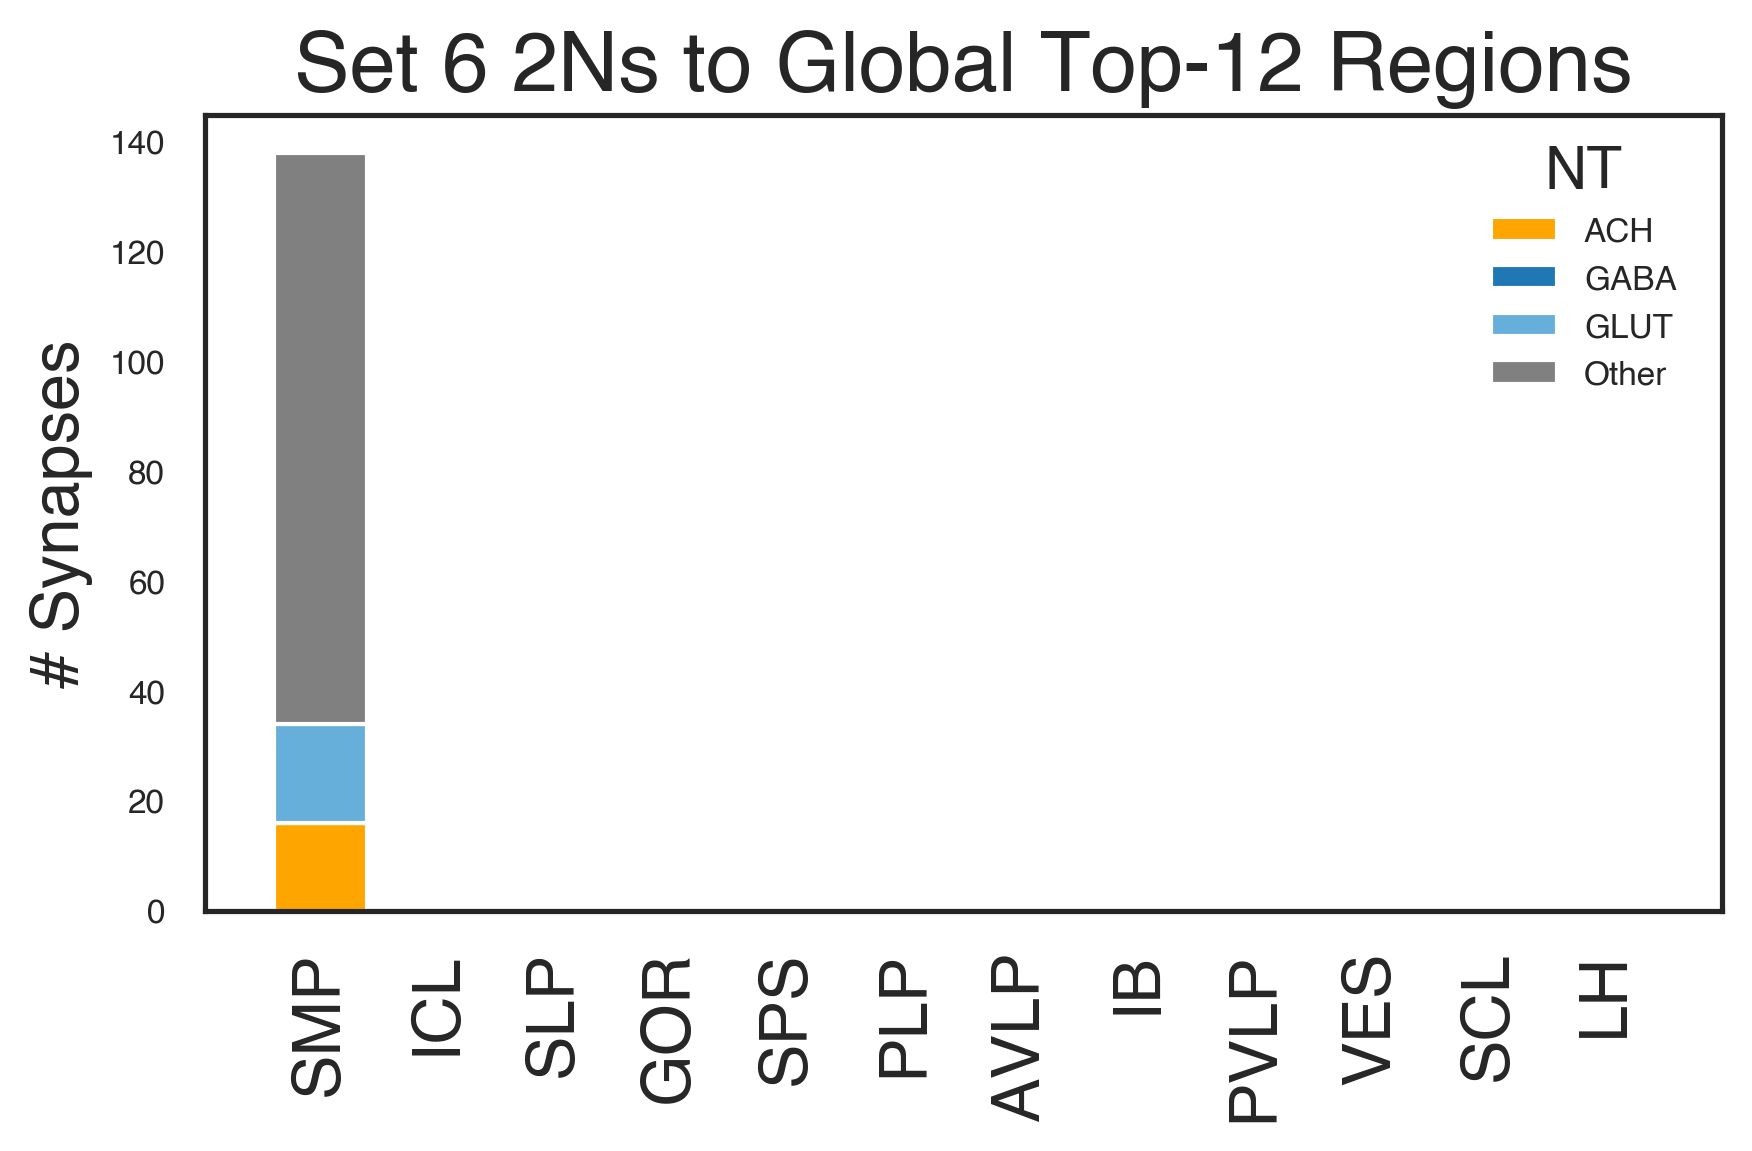

In [61]:
N = 12
colors = {'ACH':'orange','GABA':'#1f77b4','GLUT':'#67afdb','Other':'gray'}
labels  = [f"Set {i}" for i in range(1, len(outputs_list)+1)]

for df, label in zip(outputs_list, labels):
    # ensure remap applied
    df['neuropil_remap'] = df['neuropil'].map(lambda x: region_mapping.get(x, x))

    # get counts for those global top12
    ach, gaba, glut, other = count_NTs_region_list(df, top12_regions)

    # plot
    x = np.arange(len(top12_regions))
    bottom = np.zeros_like(x)
    fig, ax = plt.subplots(figsize=(6,4))
    for nt, vals in zip(['ACH','GABA','GLUT','Other'], [ach, gaba, glut, other]):
        ax.bar(x, vals, 0.8, bottom=bottom, color=colors[nt], label=nt)
        bottom += vals
    ax.set_xticks(x)
    ax.set_xticklabels(top12_regions, rotation=90, fontsize=16)
    ax.set_ylabel('# Synapses', fontsize=16)
    ax.set_title(f"{label} 2Ns to Global Top-{N} Regions", fontsize=20)
    ax.legend(title='NT', frameon=False, bbox_to_anchor=(0.99 ,1), fontsize=8)
    plt.tight_layout()
    # save as SVG (one file per set)
    svg_name = f"{label}_2N_to_top{N}_regions.svg"
    fig.savefig(svg_name, format='svg', bbox_inches='tight')
    plt.show()


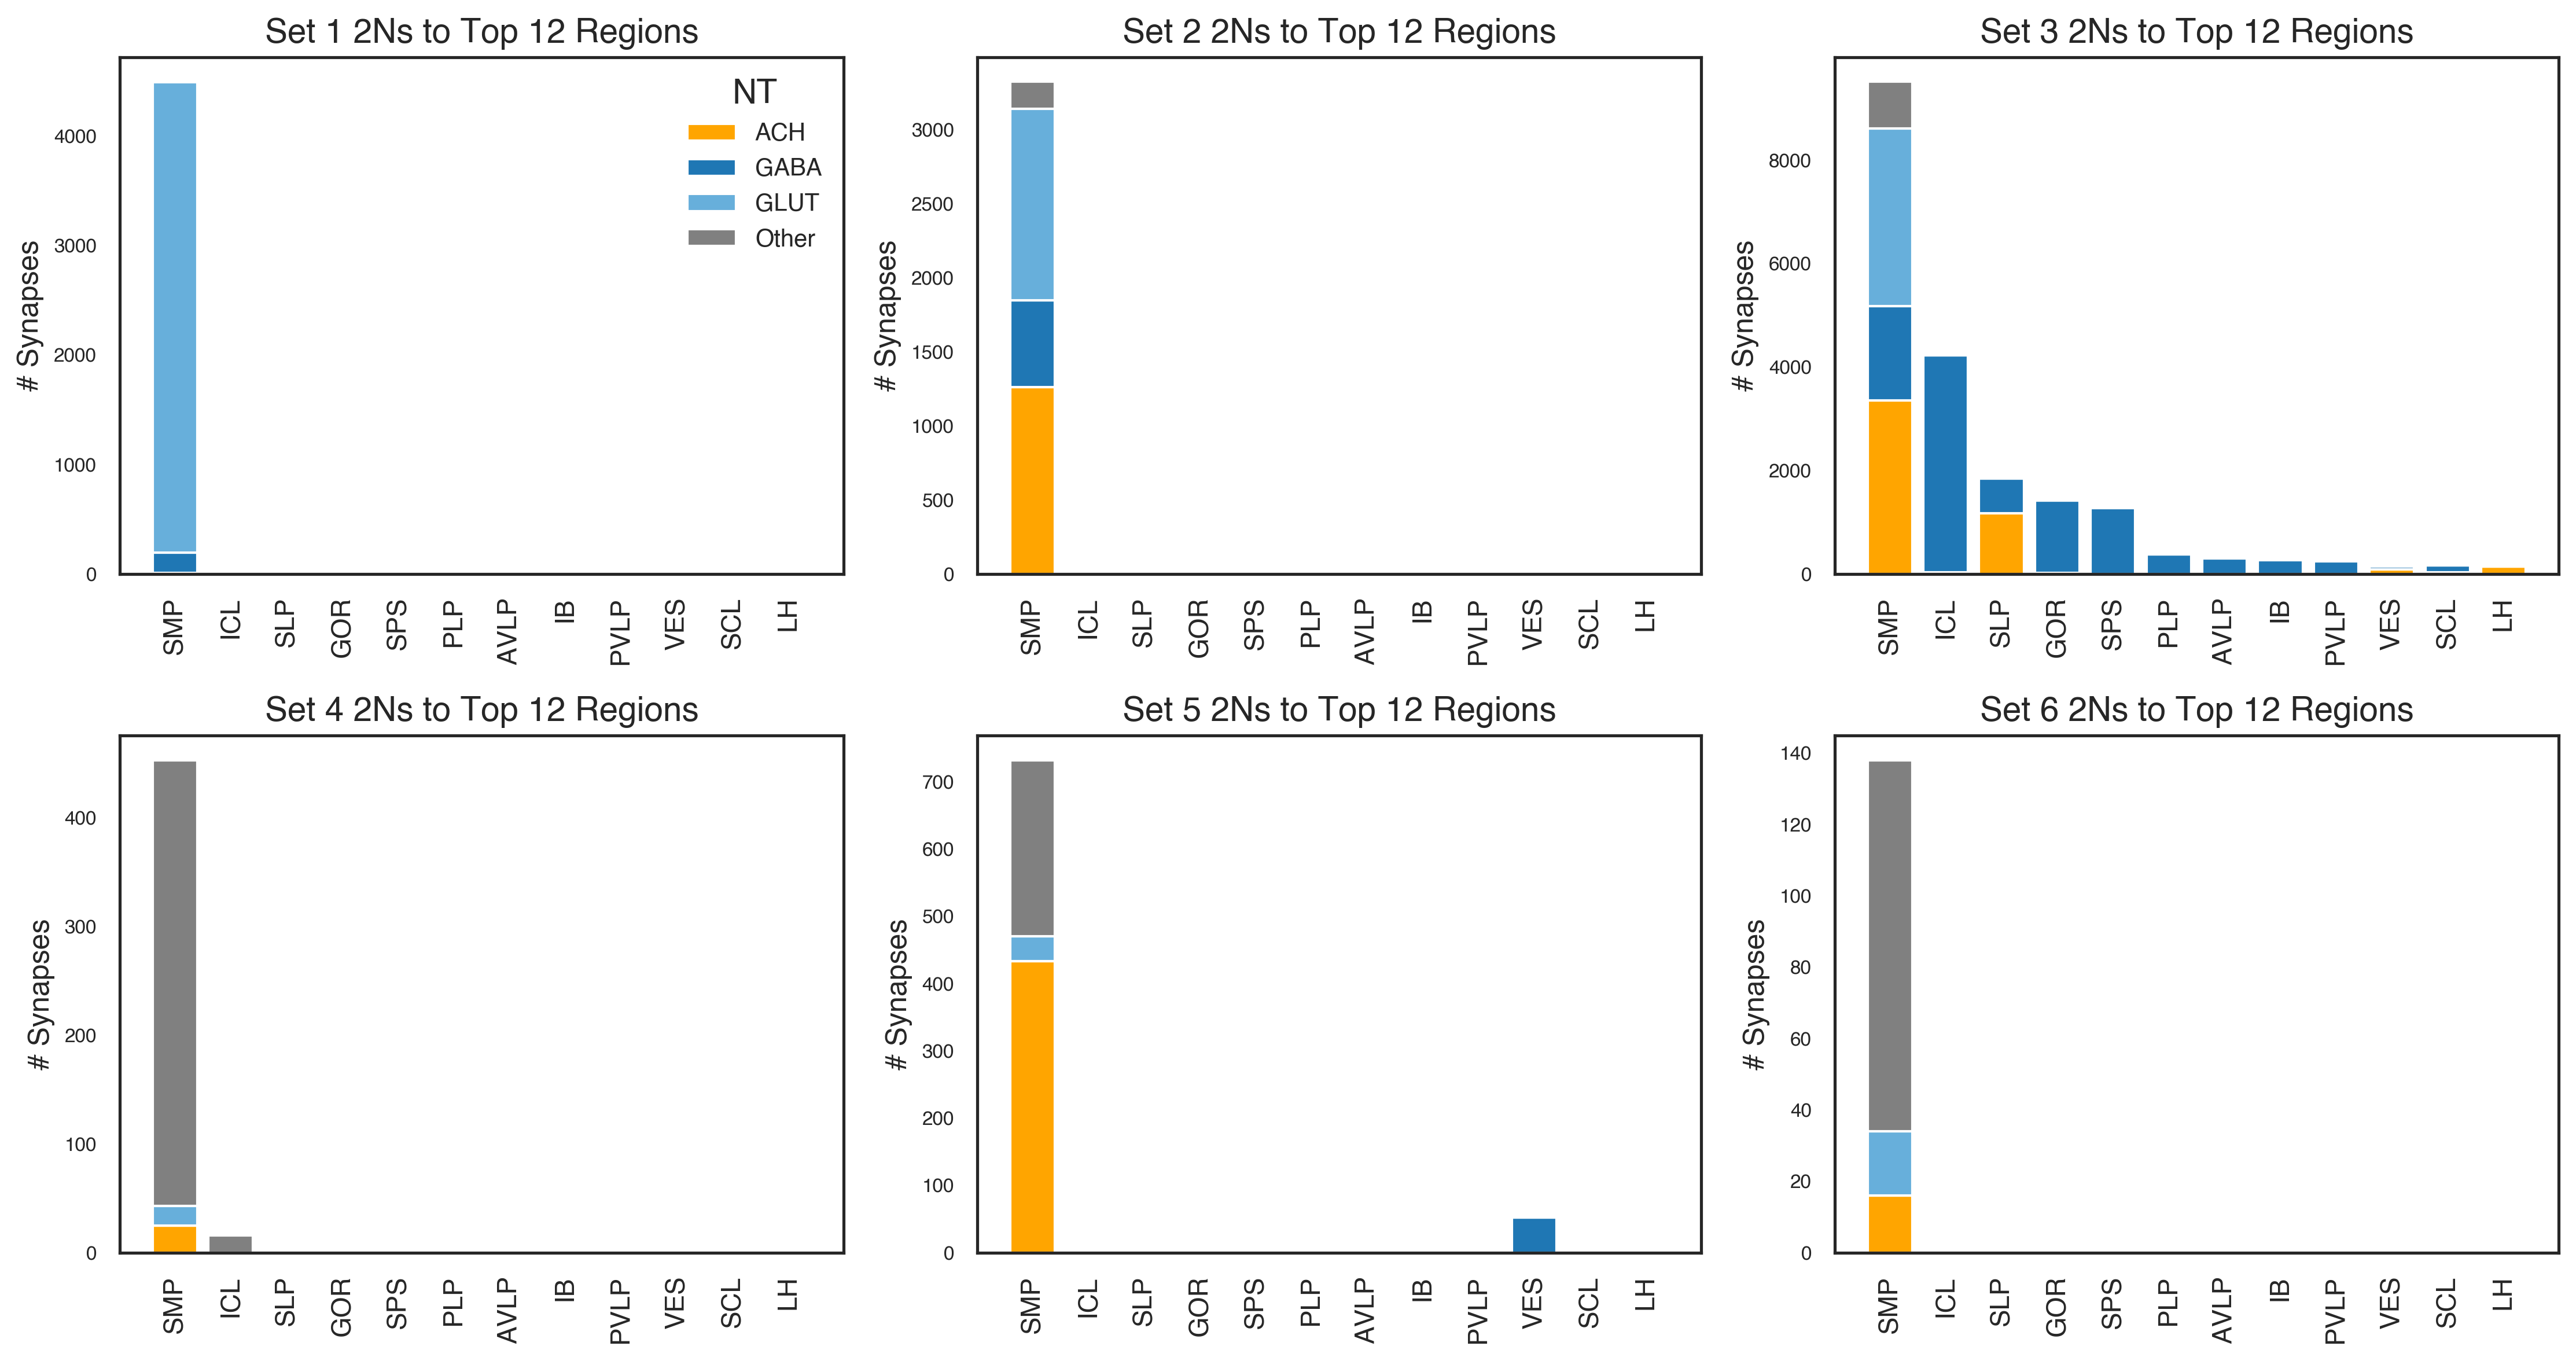

In [62]:
# Number of sets and regions
n_sets = len(outputs_list)    # or len(sets_2N)
n_regions = len(top12_regions)
ncols = 3
nrows = int(np.ceil(n_sets / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows))
axes = axes.flatten()

for i, (df, label) in enumerate(zip(outputs_list, labels)):
    ax = axes[i]

    # Apply region remap if not already present
    if 'neuropil_remap' not in df.columns:
        df['neuropil_remap'] = df['neuropil'].map(lambda x: region_mapping.get(x, x))

    # Count NTs in top 12 regions
    ach, gaba, glut, other = count_NTs_region_list(df, top12_regions)

    x = np.arange(n_regions)
    bottom = np.zeros_like(x)

    # Plot each NT type as a stacked bar
    for nt, vals in zip(['ACH', 'GABA', 'GLUT', 'Other'], [ach, gaba, glut, other]):
        ax.bar(x, vals, 0.8, bottom=bottom, color=colors[nt], label=nt)
        bottom += vals

    ax.set_xticks(x)
    ax.set_xticklabels(top12_regions, rotation=90, fontsize=11)
    ax.set_ylabel('# Synapses', fontsize=12)
    ax.set_title(f"{label} 2Ns to Top {n_regions} Regions", fontsize=14)

    if i == 0:
        ax.legend(title='NT', frameon=False, fontsize=10)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/General - YaoLabUF/SVG_figs/Fig3/All_2N_to_top12_regions.svg", format='svg', bbox_inches='tight')
plt.show()


## 3. THIRD ORDER NEURON ANALYSES

StN_SA## 3a. Identify 3Ns and their connections and organize the data

### Define a function to identify third order neurons (3Ns)
- must be downstream of 2Ns and not a
- minimum of 5 synapses from StN_SA to 2N
- minimum of 5 synapses from 2N to 3N

Note that Walker et. al. use a more stringent threshold (10 synapses) for 2N to 3N

In [63]:
# 3a. Identify 3Ns and their connections and organize the data

# Build StN_SA roots (first-order) for all sets
all_set_roots = pd.concat([df['root_id'] for df in sets_list]).astype(str).unique()
StN_SA_roots = set(all_set_roots)

# Define a streamlined 3N-finder function
def third_order_streamlined(fly2n_conn, set_name, twoN_df, thr_ph2n=5, thr_2n3n=5):
    """
    Identify third-order neurons (3Ns) downstream of 2Ns with thresholds on synapse counts.
    """
    # a) select valid 2Ns (StN_SA→2N synapses ≥ thr_ph2n)
    valid2 = (fly2n_conn
                .query(f"syn_count >= {thr_ph2n}")
                [['post_root_id']]
                .rename(columns={'post_root_id':'root_id'}))

    # b) raw 2N→3N (all connections from valid 2Ns)
    raw23 = (connections
             [['pre_root_id','post_root_id','neuropil','syn_count','nt_type']]
             .merge(valid2, left_on='pre_root_id', right_on='root_id', how='inner')
             .drop(columns='root_id'))

    # c) sum & threshold for 3Ns (2N→3N synapses ≥ thr_2n3n)
    summed = (raw23
              .groupby(['pre_root_id','post_root_id'], as_index=False)
              .agg({'syn_count':'sum'})
              .query(f"syn_count >= {thr_2n3n}"))

    # d) strongest neuropil/nt_type per pair
    strongest = raw23.loc[
        raw23.groupby(['pre_root_id','post_root_id'])['syn_count'].idxmax(),
        ['pre_root_id','post_root_id','neuropil','nt_type']]

    conn3 = summed.merge(strongest, on=['pre_root_id','post_root_id'], how='left')

    # e) drop same-set 2Ns as 3Ns
    twoN_ids = set(twoN_df['root_id'].astype(str))
    conn3 = conn3.loc[~conn3['post_root_id'].astype(str).isin(twoN_ids)].copy()

    # f) tag local vs outside_SEZ
    sez = {'GNG','PRW','SAD','FLA_L','FLA_R','CAN'}
    conn3['location_of_connection'] = (
        conn3['neuropil'].map(lambda x: 'local' if x in sez else 'outside_SEZ')
    )

    # g) summarize per 3N
    third = (conn3
             .groupby('post_root_id', as_index=False)
             .agg(
                upstream_2N_count=('pre_root_id','nunique'),
                syn_count         =('syn_count','sum')
             )
             .rename(columns={
                'post_root_id':'root_id',
                'upstream_2N_count':f'upstream_{set_name}_2Ns',
                'syn_count':         f'{set_name}_syn_count'
             }))
    third['const'] = 1
    return conn3, third


In [64]:
# Assuming you have variables named set_1_second_order_connectivity, ..., set_6_second_order_connectivity
# and set_1_2Ns, ..., set_6_2Ns

# Define these lists before your loop
second_order_connectivity_list = [
    set_1_second_order_connectivity,
    set_2_second_order_connectivity,
    set_3_second_order_connectivity,
    set_4_second_order_connectivity,
    set_5_second_order_connectivity,
    set_6_second_order_connectivity,
]

twoN_list = [
    set_1_2Ns,
    set_2_2Ns,
    set_3_2Ns,
    set_4_2Ns,
    set_5_2Ns,
    set_6_2Ns,
]

In [65]:
# Run for all sets
for i, (so, twoN) in enumerate(zip(second_order_connectivity_list, twoN_list), start=1):
    conn3, third = third_order_streamlined(
        fly2n_conn=so,
        set_name  = f"set_{i}",
        twoN_df   = twoN,
        thr_ph2n  = 5,
        thr_2n3n  = 5
    )
    globals()[f"set_{i}_third_conn"] = conn3
    globals()[f"set_{i}_3Ns"]        = third
    print(f"Set_{i}: {len(third)} 3Ns identified")

# Record summary for each set
records = []
for i, (so, twoN) in enumerate(zip(second_order_connectivity_list, twoN_list), start=1):
    # 1) valid 2Ns
    valid2n = so.query("syn_count >= 5")['post_root_id'].nunique()
    # 2) raw 2Nto3N candidates
    raw23 = (connections[['pre_root_id','post_root_id']]
             .merge(
                 so.query("syn_count >= 5")[['post_root_id']]
                   .rename(columns={'post_root_id':'root_id'}),
                 left_on='pre_root_id', right_on='root_id', how='inner'
             ))
    raw3n = raw23['post_root_id'].nunique()
    # 3) final thresholded 3Ns
    _, third = third_order_streamlined(
        fly2n_conn=so, set_name=f"set_{i}", twoN_df=twoN,
        thr_ph2n=5, thr_2n3n=5
    )
    final3n = len(third)
    # 4) dropped
    dropped = raw3n - final3n
    records.append({
        'set': f"set_{i}",
        'valid_2Ns': valid2n,
        'raw_3N_cand': raw3n,
        'dropped': dropped,
        'final_3Ns': final3n
    })
df_summary = pd.DataFrame(records)
print(df_summary)



Set_1: 466 3Ns identified
Set_2: 989 3Ns identified
Set_3: 2648 3Ns identified
Set_4: 926 3Ns identified
Set_5: 960 3Ns identified
Set_6: 680 3Ns identified
     set  valid_2Ns  raw_3N_cand  dropped  final_3Ns
0  set_1         13          472        6        466
1  set_2         85         1069       80        989
2  set_3        118         2752      104       2648
3  set_4        116         1040      114        926
4  set_5         49          993       33        960
5  set_6         67          744       64        680


In [66]:
# 4) Identify and Label Dropped 3Ns by Origin
def dropped_3Ns_labeled(set_idx, StN_SA_roots, connections):
    """
    Returns DataFrame of dropped post_root_id values with an origin column.
    """
    so       = second_order_connectivity_list[set_idx-1]
    twoN_ids = set(twoN_list[set_idx-1]["root_id"])

    valid2 = so.query("syn_count >= 5")[['post_root_id']].rename(columns={'post_root_id':'root_id'})
    raw23  = (connections[['pre_root_id','post_root_id','neuropil','syn_count','nt_type']]
              .merge(valid2, left_on='pre_root_id', right_on='root_id', how='inner')
              .drop(columns='root_id'))
    summed = (raw23.groupby(['pre_root_id','post_root_id'], as_index=False)
                .agg({'syn_count':'sum'}).query("syn_count >= 5"))

    before_set = set(summed['post_root_id'])
    after      = set(summed.loc[~summed['post_root_id'].isin(twoN_ids) &
                                ~summed['post_root_id'].isin(StN_SA_roots),
                                'post_root_id'])
    dropped    = before_set - after

    rows = []
    for rid in sorted(dropped):
        origin = ('second_order' if rid in twoN_ids else 'first_order' if rid in StN_SA_roots else 'unknown')
        rows.append({'root_id':rid, 'origin':origin})
    return pd.DataFrame(rows)

# Loop and display
for i in range(1, len(twoN_list)+1):
    df_dropped = dropped_3Ns_labeled(i, StN_SA_roots, connections)
    print(f"Set {i} dropped {len(df_dropped)} IDs:")
    print(df_dropped)



Set 1 dropped 6 IDs:
              root_id        origin
0  720575940606746034  second_order
1  720575940616801622  second_order
2  720575940628071211  second_order
3  720575940628462927  second_order
4  720575940630672938  second_order
5  720575940630980559  second_order
Set 2 dropped 80 IDs:
               root_id        origin
0   720575940603944382  second_order
1   720575940607777628  second_order
2   720575940607877833  second_order
3   720575940609425874  second_order
4   720575940610708430  second_order
..                 ...           ...
75  720575940645056791  second_order
76  720575940646088068  second_order
77  720575940647471395  second_order
78  720575940648654468  second_order
79  720575940654057889  second_order

[80 rows x 2 columns]
Set 3 dropped 104 IDs:
                root_id        origin
0    720575940604934502  second_order
1    720575940606388146  second_order
2    720575940606720265  second_order
3    720575940606867145  second_order
4    720575940608157397  

Rationale: by limiting the filter at step (e) to 2N overlap only, we recover the 466 3Ns you verified manually for set_1, while preserving the same behavior for sets 2–6.

In [67]:
# (Optional) Merge metadata
for i in range(1, len(twoN_list)+1):
    key = f"set_{i}_3Ns"
    globals()[key] = globals()[key].merge(neurons_data, on='root_id', how='inner')

### Getting more information about 3Ns from Flywire's data repository
Again we are using files from snapshot 783.

In [68]:
for i in range(1, 7):
    df_name = f'set_{i}_3Ns'
    # pull the DataFrame, merge on root_id, and write it back
    globals()[df_name] = globals()[df_name].merge(
        neurons_data,
        on='root_id',
        how='inner'
    )

# inspect one of them
set_1_3Ns

root_id  upstream_set_1_2Ns  set_1_syn_count  const nt_type_x  \
0    720575940603765280                   1               90      1       NaN   
1    720575940603943648                   1               32      1       ACH   
2    720575940604332460                   1               10      1       ACH   
3    720575940604565350                   1               19      1      GLUT   
4    720575940604934502                   1               28      1       NaN   
..                  ...                 ...              ...    ...       ...   
461  720575940654057889                   4              162      1      GLUT   
462  720575940654185377                   2               82      1       ACH   
463  720575940655011489                   2              104      1       ACH   
464  720575940660223873                   2              242      1       ACH   
465  720575940661302657                   1               24      1       ACH   

    side_x  input_synapses_x  output_synapses_x nt_type_y side_y  \
0     left             346.0                0.0       NaN   left   
1    right              36.0               81.0       ACH  right   
2     left              56.0              256.0       ACH   left   
3     left             186.0              408.0      GLUT   left   
4     left             243.0                0.0       NaN   left   
..     ...               ...                ...       ...    ...   
461   left            2269.0             1416.0      GLUT   left   
462  right             120.0              199.0       ACH  right   
463   left            2219.0             1365.0       ACH   left   
464   left            1407.0             2354.0       ACH   left   
465  right            1391.0              897.0       ACH  right   

     input_synapses_y  output_synapses_y  
0               346.0                0.0  
1                36.0               81.0  
2                56.0              256.0  
3               186.0              408.0  
4               243.0                0.0  
..                ...                ...  
461            2269.0             1416.0  
462             120.0              199.0  
463            2219.0             1365.0  
464            1407.0             2354.0  
465            1391.0              897.0  

[466 rows x 12 columns]

## 3b. Analyzing convergence of excitatory vs. inhibitory 2N inputs onto 3Ns

We are comparing the observed proportion of excitatory or inhibitory convergence to the proportion expected by chance.

### Transform the 2N-3N connectivity data so that each row is a unique 2N-3N pair

This is necessary because the 2N-3N connectivity data may include the same 2N-3N pair multiple times if they connect in multiple regions.

We also want to label NT type for each 2N-3N synapse using the "neurons" dataset; otherwise the synapse labels for the same 2N-3N pair sometimes conflict. Note that this is different from other analyses that just use synapse labels.

## 3b. Convergence of excitatory vs inhibitory 2Nto3N inputs

In [69]:
set_1_3Ns

root_id  upstream_set_1_2Ns  set_1_syn_count  const nt_type_x  \
0    720575940603765280                   1               90      1       NaN   
1    720575940603943648                   1               32      1       ACH   
2    720575940604332460                   1               10      1       ACH   
3    720575940604565350                   1               19      1      GLUT   
4    720575940604934502                   1               28      1       NaN   
..                  ...                 ...              ...    ...       ...   
461  720575940654057889                   4              162      1      GLUT   
462  720575940654185377                   2               82      1       ACH   
463  720575940655011489                   2              104      1       ACH   
464  720575940660223873                   2              242      1       ACH   
465  720575940661302657                   1               24      1       ACH   

    side_x  input_synapses_x  output_synapses_x nt_type_y side_y  \
0     left             346.0                0.0       NaN   left   
1    right              36.0               81.0       ACH  right   
2     left              56.0              256.0       ACH   left   
3     left             186.0              408.0      GLUT   left   
4     left             243.0                0.0       NaN   left   
..     ...               ...                ...       ...    ...   
461   left            2269.0             1416.0      GLUT   left   
462  right             120.0              199.0       ACH  right   
463   left            2219.0             1365.0       ACH   left   
464   left            1407.0             2354.0       ACH   left   
465  right            1391.0              897.0       ACH  right   

     input_synapses_y  output_synapses_y  
0               346.0                0.0  
1                36.0               81.0  
2                56.0              256.0  
3               186.0              408.0  
4               243.0                0.0  
..                ...                ...  
461            2269.0             1416.0  
462             120.0              199.0  
463            2219.0             1365.0  
464            1407.0             2354.0  
465            1391.0              897.0  

[466 rows x 12 columns]

In [70]:
# 1) Build StN_SA roots (1Ns)
set_list = [set_1, set_2, set_3, set_4, set_5, set_6]
StN_SA_roots = set(pd.concat([df['root_id'] for df in set_list]).astype(str).unique())

# 2) List of variable names (as strings) for your 2N DataFrames
twoN_names = [f"set_{i}_2Ns" for i in range(1, 7)]

def clean_2Ns(StN_SA_roots, twoN_names):
    summary = []
    for i, name in enumerate(twoN_names, start=1):
        df2 = globals()[name].copy()
        raw_ids = set(df2['root_id'].astype(str))
        dropped_ids = raw_ids & StN_SA_roots
        clean_df = df2.loc[~df2['root_id'].astype(str).isin(StN_SA_roots)].reset_index(drop=True)
        # Overwrite global variable
        globals()[name] = clean_df
        # Print dropped root_ids for each set
        print(f"{name}: Dropped {len(dropped_ids)} root_ids: {sorted(dropped_ids) if dropped_ids else 'None'}")
        summary.append({
            'set': f"set_{i}",
            'raw_2Ns': len(raw_ids),
            'cleaned_2Ns': clean_df['root_id'].nunique(),
            'dropped_2Ns': len(dropped_ids)
        })
    return pd.DataFrame(summary)

df_2N_summary = clean_2Ns(StN_SA_roots, twoN_names)
print(df_2N_summary)


set_1_2Ns: Dropped 0 root_ids: None
set_2_2Ns: Dropped 0 root_ids: None
set_3_2Ns: Dropped 0 root_ids: None
set_4_2Ns: Dropped 0 root_ids: None
set_5_2Ns: Dropped 0 root_ids: None
set_6_2Ns: Dropped 0 root_ids: None
     set  raw_2Ns  cleaned_2Ns  dropped_2Ns
0  set_1       13           13            0
1  set_2       85           85            0
2  set_3      118          118            0
3  set_4      116          116            0
4  set_5       49           49            0
5  set_6       67           67            0


In [71]:
# 3) Define 3N‑finder (drops same-set 2Ns only)
def third_order_streamlined(fly2n_conn, set_name, twoN_df,
                             thr_ph2n=5, thr_2n3n=5):
    # a) valid 2Ns threshold
    valid2 = (
        fly2n_conn
        .query(f"syn_count >= {thr_ph2n}")
        [['post_root_id']]
        .rename(columns={'post_root_id':'root_id'})
    )
    # b) raw 2Nto3N edges
    raw23 = (
        connections[['pre_root_id','post_root_id','neuropil','syn_count','nt_type']]
        .merge(valid2, left_on='pre_root_id', right_on='root_id', how='inner')
        .drop(columns='root_id')
    )
    # c) sum & threshold for 3N
    summed = (
        raw23
        .groupby(['pre_root_id','post_root_id'], as_index=False)
        .agg({'syn_count':'sum'})
        .query(f"syn_count >= {thr_2n3n}")
    )
    # d) attach strongest neuropil/nt_type
    strongest = raw23.loc[
        raw23.groupby(['pre_root_id','post_root_id'])['syn_count'].idxmax(),
        ['pre_root_id','post_root_id','neuropil','nt_type']
    ]
    conn3 = summed.merge(strongest, on=['pre_root_id','post_root_id'], how='left')
    # e) drop same‑set 2Ns
    twoN_ids = set(twoN_df['root_id'].astype(str))
    conn3 = conn3.loc[~conn3['post_root_id'].astype(str).isin(twoN_ids)].copy()
    # f) tag locality
    sez = {'GNG','PRW','SAD','FLA_L','FLA_R','CAN'}
    conn3['location_of_connection'] = conn3['neuropil'].map(
        lambda x: 'local' if x in sez else 'outside_SEZ'
    )
    # g) summarize per 3N
    third = (
        conn3
        .groupby('post_root_id', as_index=False)
        .agg(
            upstream_2N_count=('pre_root_id','nunique'),
            syn_count         =('syn_count','sum')
        )
        .rename(columns={
            'post_root_id':'root_id',
            'upstream_2N_count':f'upstream_{set_name}_2Ns',
            'syn_count':         f'{set_name}_syn_count'
        })
    )
    third['const'] = 1
    return conn3, third

In [72]:
# 4) Generate cleaned 3N sets and summary
records_3N = []
for i in range(1,7):
    so   = globals()[f"set_{i}_second_order_connectivity"]
    twoN = globals()[f"set_{i}_2Ns"]
    raw_conn3, third = third_order_streamlined(
        fly2n_conn=so,
        set_name  = f"set_{i}",
        twoN_df   = twoN,
        thr_ph2n  = 5,
        thr_2n3n  = 5
    )
    raw3n = raw_conn3['post_root_id'].nunique()
    final3n = len(third)
    globals()[f"set_{i}_third_conn"] = raw_conn3
    globals()[f"set_{i}_3Ns"]        = third
    print(f"set_{i}: raw_3Ns={raw3n}, cleaned_3Ns={final3n}")
    records_3N.append({
        'set': f"set_{i}",
        'raw_3Ns': raw3n,
        'cleaned_3Ns': final3n,
        'dropped_3Ns': raw3n - final3n
    })

df_3N_summary = pd.DataFrame(records_3N)
print(df_3N_summary)

set_1: raw_3Ns=466, cleaned_3Ns=466
set_2: raw_3Ns=989, cleaned_3Ns=989
set_3: raw_3Ns=2648, cleaned_3Ns=2648
set_4: raw_3Ns=926, cleaned_3Ns=926
set_5: raw_3Ns=960, cleaned_3Ns=960
set_6: raw_3Ns=680, cleaned_3Ns=680
     set  raw_3Ns  cleaned_3Ns  dropped_3Ns
0  set_1      466          466            0
1  set_2      989          989            0
2  set_3     2648         2648            0
3  set_4      926          926            0
4  set_5      960          960            0
5  set_6      680          680            0


In [73]:
def get_3N_inputs(conn3, neurons_data):
    # a) select edges and merge canonical nt_type
    toc = conn3[['pre_root_id','post_root_id','syn_count']].merge(
        neurons_data[['root_id','nt_type']],
        left_on='pre_root_id', right_on='root_id', how='left'
    ).drop(columns='root_id')
    # b) filter NTs and map to E/I
    toc = toc[toc['nt_type'].isin(['GABA','ACH','GLUT'])]
    toc['ei'] = toc['nt_type'].map({'GABA':'I','GLUT':'I','ACH':'E'})
    # c) aggregate per pair & label
    toc = (toc.groupby(['pre_root_id','post_root_id','ei'], as_index=False)
           .agg({'syn_count':'sum'}))
    return toc

# 2) Apply to each set
for i in range(1,7):
    conn3 = globals()[f"set_{i}_third_conn"]
    toc   = get_3N_inputs(conn3, neurons_data)
    globals()[f"set_{i}_toc"] = toc
    print(f"set_{i}: edges={conn3.shape[0]}, toc_rows={toc.shape[0]}")

set_1: edges=616, toc_rows=543
set_2: edges=2560, toc_rows=2252
set_3: edges=5342, toc_rows=4885
set_4: edges=3835, toc_rows=3653
set_5: edges=1955, toc_rows=1758
set_6: edges=1753, toc_rows=1432


In [74]:
set_1_3Ns

root_id  upstream_set_1_2Ns  set_1_syn_count  const
0    720575940603765280                   1               90      1
1    720575940603943648                   1               32      1
2    720575940604332460                   1               10      1
3    720575940604565350                   1               19      1
4    720575940604934502                   1               28      1
..                  ...                 ...              ...    ...
461  720575940654057889                   4              162      1
462  720575940654185377                   2               82      1
463  720575940655011489                   2              104      1
464  720575940660223873                   2              242      1
465  720575940661302657                   1               24      1

[466 rows x 4 columns]

### Make a dataframe for all modalities

In [75]:
### Build & summarize the combined 3N table

# 1) Collect the six 3N DataFrames by name
threeN_dfs = [globals()[f"set_{i}_3Ns"] for i in range(1, 7)]

# 2) Concatenate into one DataFrame
all_3N = pd.concat(threeN_dfs, ignore_index=True)

# 3) Quick check
print(f"Total rows in all_3N: {len(all_3N)}")
display(all_3N.head())


Total rows in all_3N: 6669


root_id  upstream_set_1_2Ns  set_1_syn_count  const  \
0  720575940603765280                 1.0             90.0      1   
1  720575940603943648                 1.0             32.0      1   
2  720575940604332460                 1.0             10.0      1   
3  720575940604565350                 1.0             19.0      1   
4  720575940604934502                 1.0             28.0      1   

   upstream_set_2_2Ns  set_2_syn_count  upstream_set_3_2Ns  set_3_syn_count  \
0                 NaN              NaN                 NaN              NaN   
1                 NaN              NaN                 NaN              NaN   
2                 NaN              NaN                 NaN              NaN   
3                 NaN              NaN                 NaN              NaN   
4                 NaN              NaN                 NaN              NaN   

   upstream_set_4_2Ns  set_4_syn_count  upstream_set_5_2Ns  set_5_syn_count  \
0                 NaN              NaN                 NaN              NaN   
1                 NaN              NaN                 NaN              NaN   
2                 NaN              NaN                 NaN              NaN   
3                 NaN              NaN                 NaN              NaN   
4                 NaN              NaN                 NaN              NaN   

   upstream_set_6_2Ns  set_6_syn_count  
0                 NaN              NaN  
1                 NaN              NaN  
2                 NaN              NaN  
3                 NaN              NaN  
4                 NaN              NaN

In [76]:
# 4) Now sum across your six syn_count and upstream columns

# Explicitly list them from 1 to 6
cols_merge_syn_2N_input = [f"set_{i}_syn_count"       for i in range(1, 7)]
cols_2_merge_upstream_2N = [f"upstream_set_{i}_2Ns"    for i in range(1, 7)]

all_3N = all_3N.assign(
    _2N_syn_count = all_3N[cols_merge_syn_2N_input].sum(axis=1)
).drop(columns=cols_merge_syn_2N_input)

all_3N = all_3N.assign(
    upstream_2N    = all_3N[cols_2_merge_upstream_2N].sum(axis=1)
).drop(columns=cols_2_merge_upstream_2N)

# 5) Inspect final DataFrame
display(all_3N.head())

root_id  const  _2N_syn_count  upstream_2N
0  720575940603765280      1           90.0          1.0
1  720575940603943648      1           32.0          1.0
2  720575940604332460      1           10.0          1.0
3  720575940604565350      1           19.0          1.0
4  720575940604934502      1           28.0          1.0

In [77]:
# 6) And if you want a per-set count of unique 3Ns:
for i in range(1, 7):
    df3 = globals()[f"set_{i}_3Ns"]
    print(f"Set {i} 3Ns: {df3['root_id'].nunique()} unique neurons")

Set 1 3Ns: 466 unique neurons
Set 2 3Ns: 989 unique neurons
Set 3 3Ns: 2648 unique neurons
Set 4 3Ns: 926 unique neurons
Set 5 3Ns: 960 unique neurons
Set 6 3Ns: 680 unique neurons


In [78]:
set_1_3Ns.head()  # or just display(all_3N.head())

root_id  upstream_set_1_2Ns  set_1_syn_count  const
0  720575940603765280                   1               90      1
1  720575940603943648                   1               32      1
2  720575940604332460                   1               10      1
3  720575940604565350                   1               19      1
4  720575940604934502                   1               28      1

In [79]:
num_sets = 6

for i in range(1, num_sets + 1):
    # ───── run third_order_streamlined to get raw 3N connectivity ─────
    so   = globals()[f"set_{i}_second_order_connectivity"]
    twoN = globals()[f"set_{i}_2Ns"]
    conn3, third = third_order_streamlined(
        fly2n_conn=so,
        set_name  = f"set_{i}",
        twoN_df   = twoN,
        thr_ph2n  = 5,
        thr_2n3n  = 5
    )

    # ───── select only the three columns we need ─────
    df_edges = conn3[['pre_root_id', 'post_root_id', 'syn_count']].copy()

    # ───── tag which set this came from ─────
    df_edges['origin_set'] = f"set_{i}"

    # ───── write to CSV ─────
    df_edges.to_csv(f"set_{i}_third_order_edges.csv", index=False)


In [80]:
num_sets = 6

for i in range(1, num_sets + 1):
    # ─── run third_order_streamlined to get raw 3N connectivity ───
    so   = globals()[f"set_{i}_second_order_connectivity"]
    twoN = globals()[f"set_{i}_2Ns"]
    conn3, third = third_order_streamlined(
        fly2n_conn=so,
        set_name  = f"set_{i}",
        twoN_df   = twoN,
        thr_ph2n  = 5,
        thr_2n3n  = 5
    )

    # ─── extract unique pre_root_id and unique post_root_id ───
    unique_pre_ids  = conn3['pre_root_id'].unique()
    unique_post_ids = conn3['post_root_id'].unique()

    # ─── turn each into a one‐column DataFrame and save ───
    pd.DataFrame({'unique_root_id': unique_pre_ids}) \
      .to_csv(f"set_{i}_third_order_unique_pre_ids.csv", index=False)
    pd.DataFrame({'unique_root_id': unique_post_ids}) \
      .to_csv(f"set_{i}_third_order_unique_post_ids.csv", index=False)


## 3d. Analyze 3N inputs and convergence across modalities

### Venn diagram to visualize convergence of 2N modalities onto 3Ns

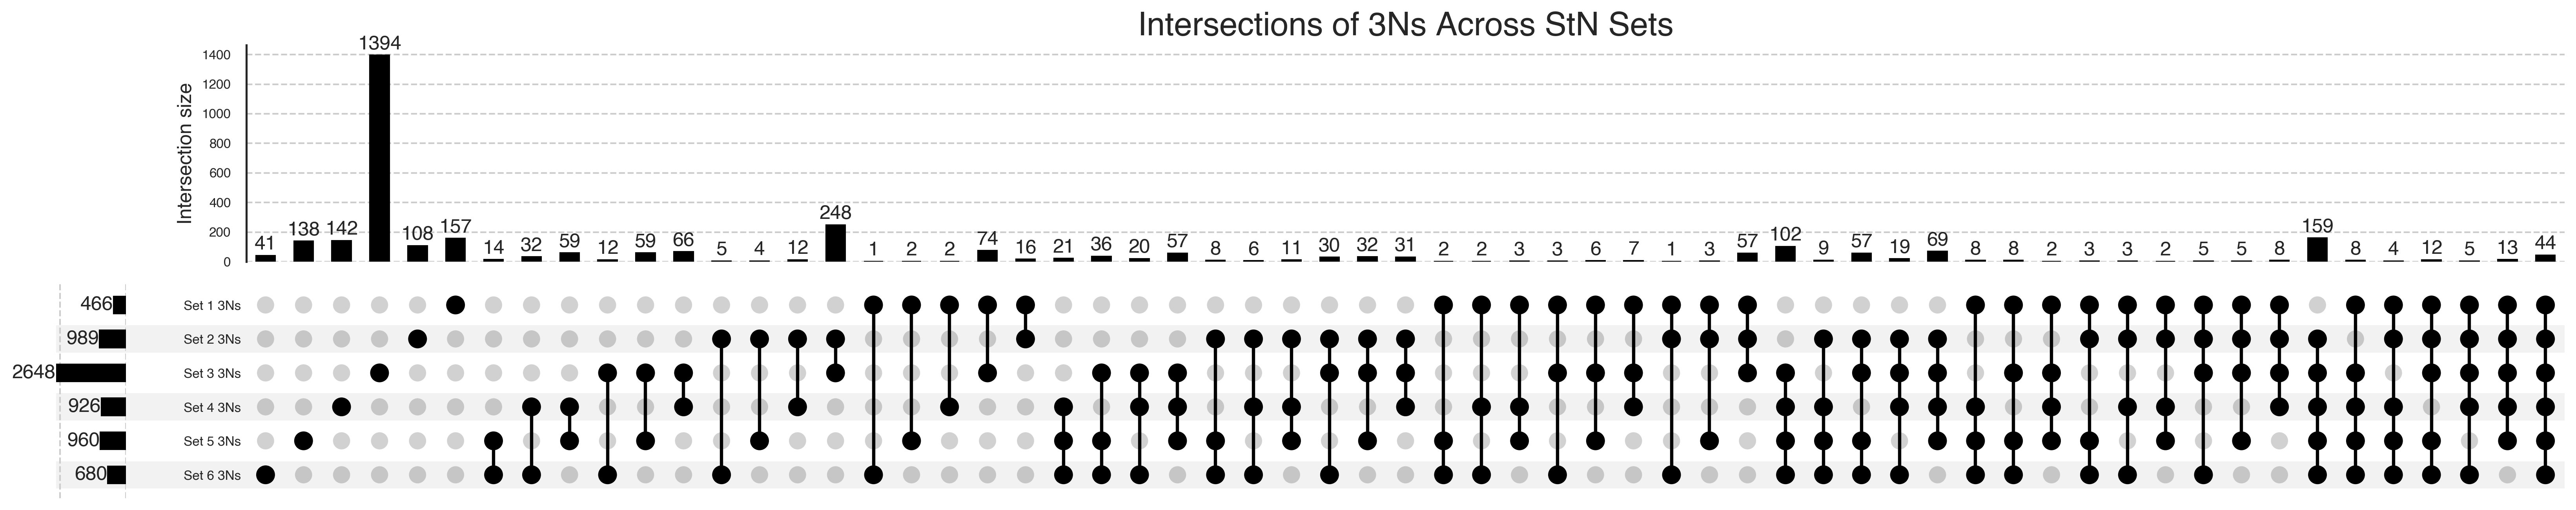

In [81]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# number of modalities/sets you have
num_sets = 6

# 1) Build the contents dict dynamically
contents = {}
for i in range(1, num_sets+1):
    df = globals().get(f"set_{i}_3Ns")
    if df is None:
        continue
    contents[f"Set {i} 3Ns"] = {str(x) for x in df['root_id'].unique()}

upset_data = from_contents(contents)

# 2) Create figure & plot the UpSet
fig = plt.figure(figsize=(10, 6))
upset = UpSet(
    upset_data,
    subset_size='count',
    show_counts=True,
    element_size=30,
    sort_categories_by='-input'
)
upset.plot(fig=fig)

# 3) Tidy up axes (hide x-axis ticks/labels/spines)
for ax in fig.axes:
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='x', which='both', labelbottom=False)

# 4) Final title, save, and show
plt.title("Intersections of 3Ns Across StN Sets", fontsize=20)
plt.savefig('/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/General - YaoLabUF/SVG_figs/Fig4/upset3n.svg', format='svg', bbox_inches='tight')
plt.show()


In [82]:
# Set seaborn theme to white
sns.set_theme(style='white')

# set up matplot lib theme
andy_theme = {'axes.grid': False,
              'grid.linestyle': '--',
              'legend.framealpha': 1,
              'legend.facecolor': 'white',
              'legend.shadow': False,
              'legend.fontsize': 14,
              'legend.title_fontsize': 14,
              'font.sans-serif':'Helvetica',
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'axes.labelsize': 12,
              'axes.titlesize': 16,
              'figure.dpi': 300}

plt.rcParams.update(andy_theme)

#Uncomment next 2 lines if matplotlib can not find Helvetica font
#plt.rcParams['font.family'] = 'DeJavu Serif'
#plt.rcParams['font.sans-serif'] = ['Arial']

### Make heatmap to see 2N-3N connectivity to individual 3Ns

We will plot each individual 3N as a different column and each 2N modality as a different row, then make a heatmap where the color indicates the number of input synapses from each set of 2Ns onto each 3N. Note that the same 2N cells may be represented in multiple categories (rows).

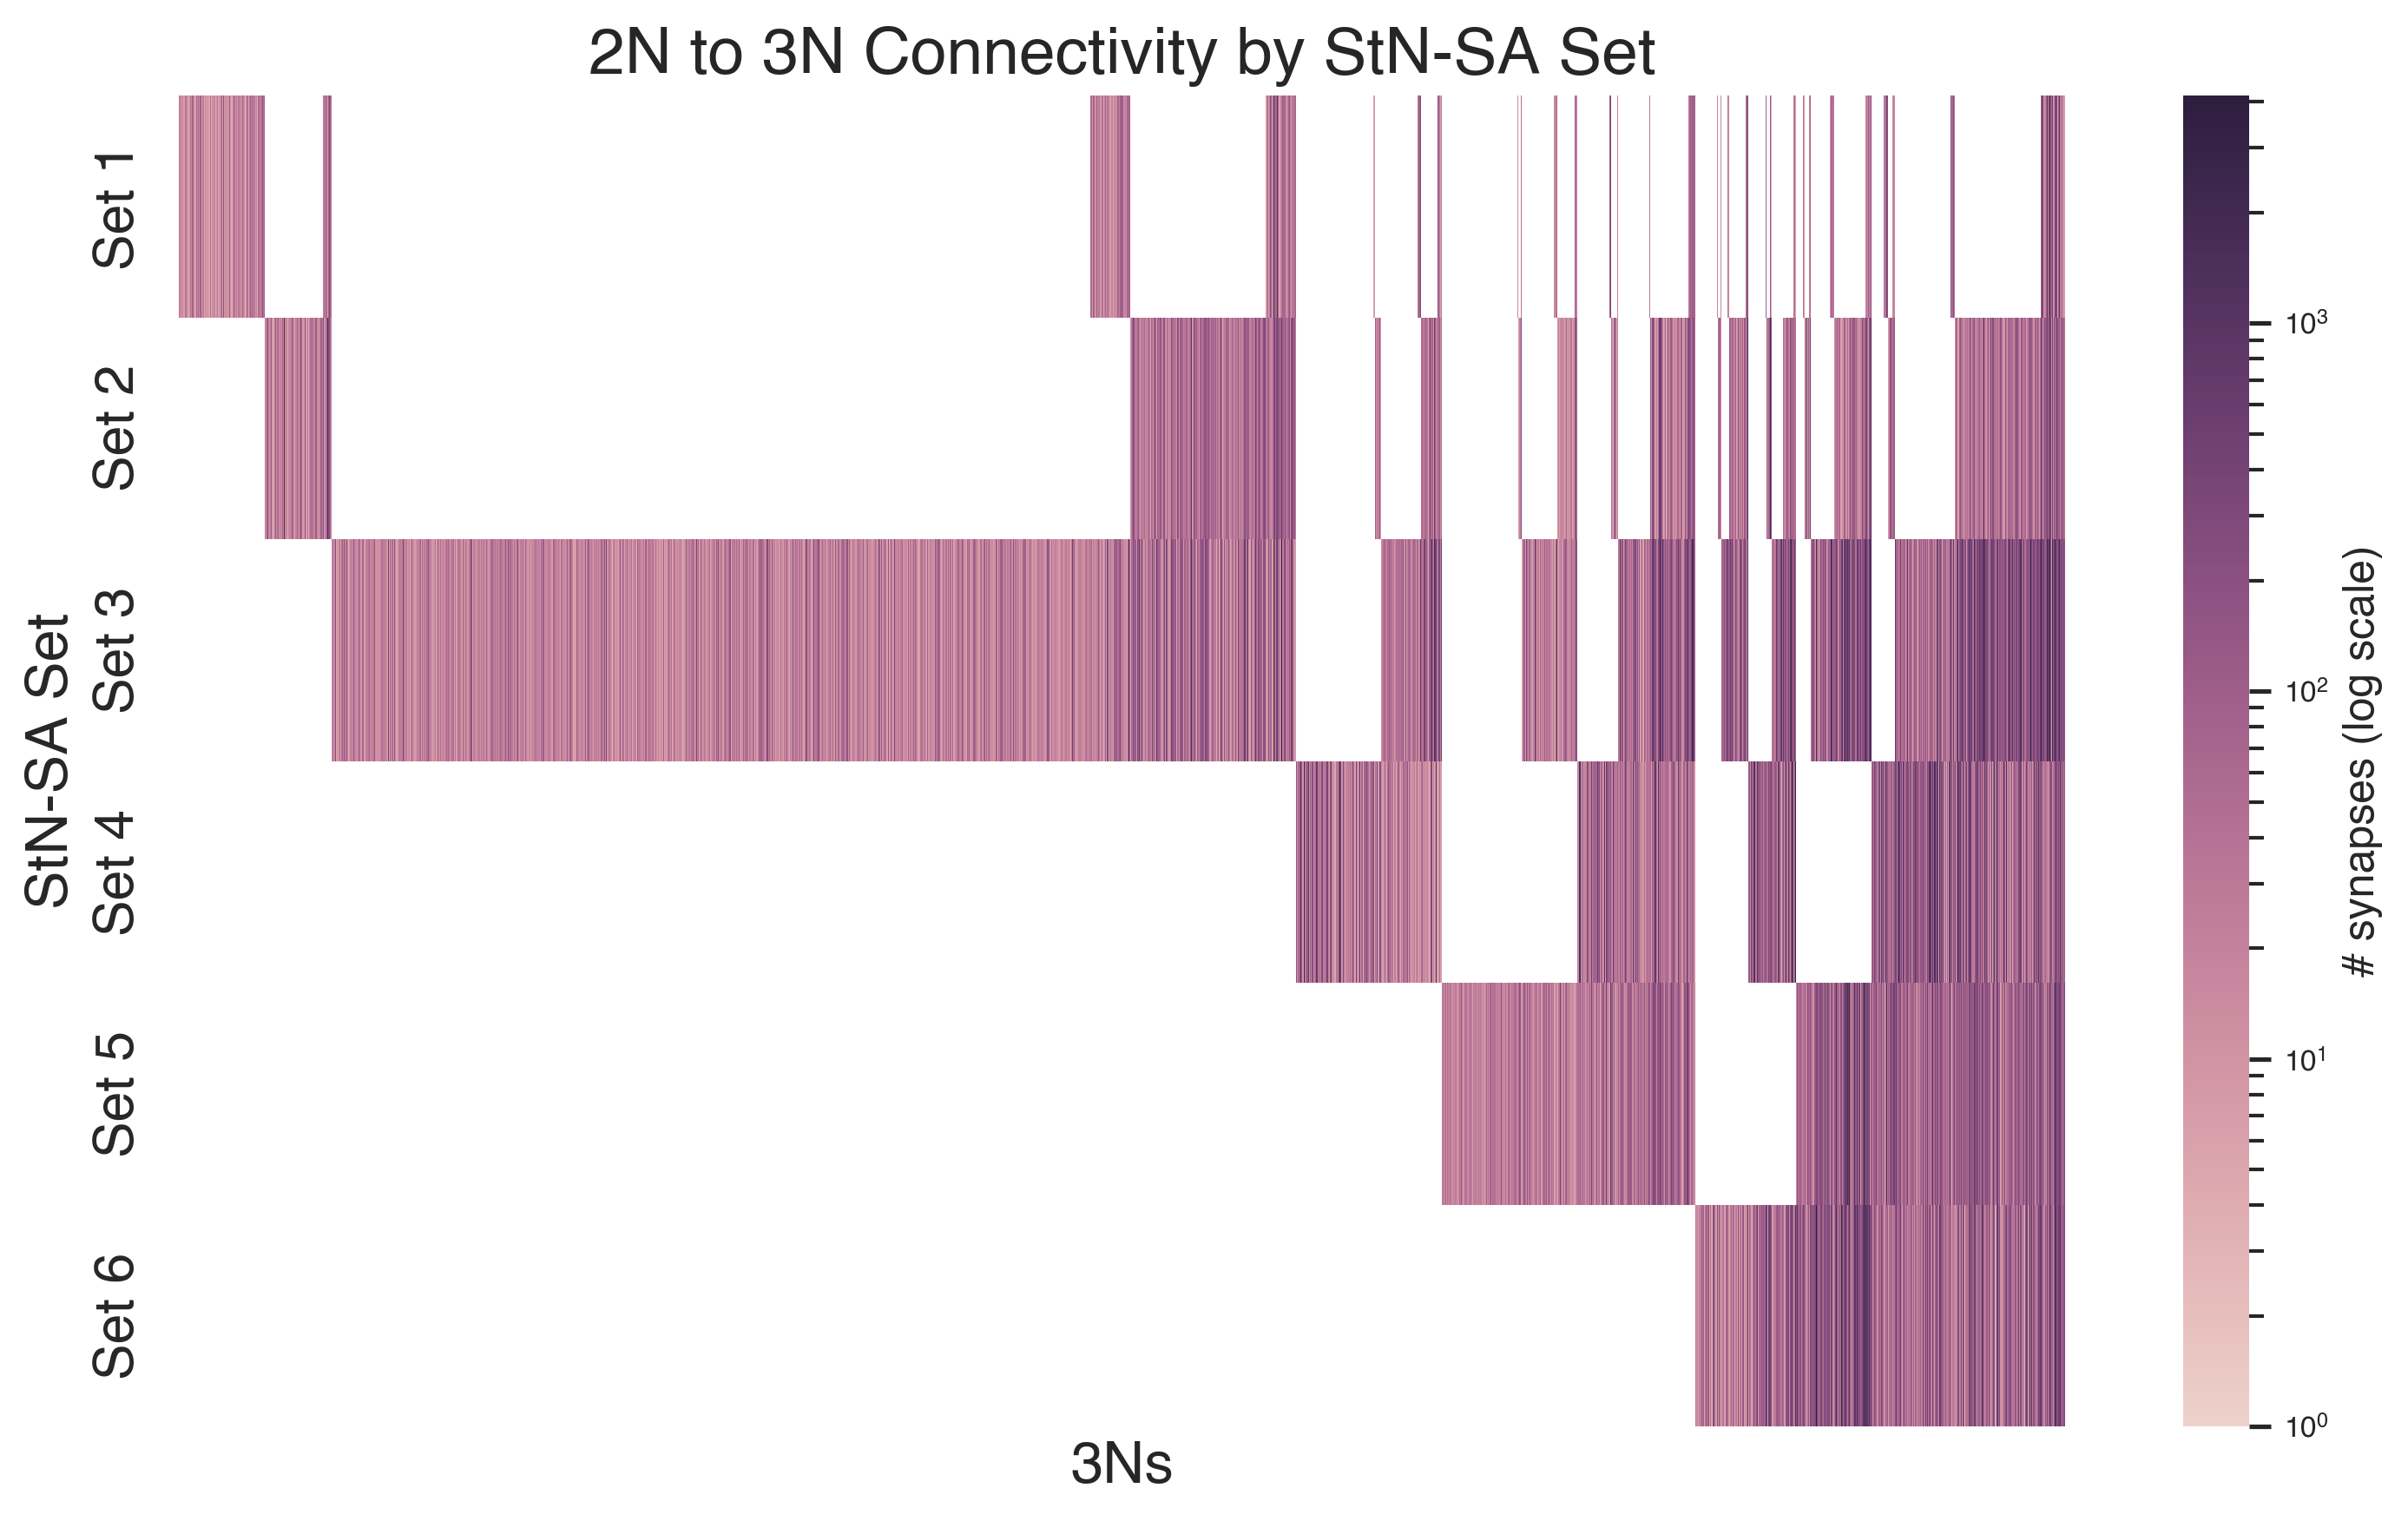

In [83]:
# Create set labels and gather the third_conn DataFrames dynamically
set_labels = [f'Set {i}' for i in range(1, num_sets+1)]
third_conn_list = []
for i, label in enumerate(set_labels, start=1):
    df = globals().get(f"set_{i}_third_conn")
    if df is not None:
        third_conn_list.append(df.assign(set_name=label))

# 1) Concatenate all DataFrames, each with set_name attached
heatmap_data = pd.concat(third_conn_list, axis=0, ignore_index=True)

# 2) Aggregate syn_count by (set_name, post_root_id) and pivot (rows=sets, cols=3Ns)
syn_count_by_set = (
    heatmap_data
    .groupby(['set_name','post_root_id'])['syn_count']
    .sum()
    .unstack(fill_value=0)
    .astype(int)
)

# 3) Sort columns (3Ns) by convergence across sets (most-broadly-hit columns to the left)
nonzero = syn_count_by_set.ne(0)
display_order_3Ns = (
    nonzero.T
    .sort_values(by=set_labels[::-1], ascending=True)  # reverse for left-most = most sets
    .index
)
syn_count_by_set = syn_count_by_set.loc[set_labels, display_order_3Ns]

# 4) Plot heatmap with log scale
plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    syn_count_by_set,
    norm=LogNorm(vmin=1, vmax=max(1, syn_count_by_set.values.max())),
    cmap=sns.cubehelix_palette(as_cmap=True),
    xticklabels=False,
    yticklabels=True,
    cbar_kws={'label': '# synapses (log scale)'}
)

ax.tick_params(axis='y', labelsize=15)
plt.title("2N to 3N Connectivity by StN-SA Set", fontsize=18)
plt.xlabel("3Ns", fontsize=16)
plt.ylabel("StN-SA Set", fontsize=16)
plt.tight_layout()
plt.savefig('/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/General - YaoLabUF/SVG_figs/Fig4/2N to 3N Connectivity by StN-SA Set.svg', format='svg', bbox_inches='tight')
plt.show()


The only thing that really changed between your two versions was how you told `LogNorm` what its bounds were:

1. **First version**

   ```python
   sns.heatmap(
       syn_count_by_set,
       norm=LogNorm(vmin=1, vmax=syn_count_by_set.values.max()),
       …
   )
   ```

   Here you explicitly said “map 1 → lowest color, max → highest color,” and you left all of your zero cells masked out (white).

2. **Second version**

   ```python
   sns.heatmap(
       syn_count_by_set,
       norm=LogNorm(),
       …
   )
   ```

   Now `LogNorm` figures out `vmin` and `vmax` for you from the data (including those zeros!).  By default it will take the *minimum* data value (which is 0) as `vmin` and the *maximum* as `vmax`.  Pushing `vmin` down to zero (which then gets masked) squashes the dynamic range of your non-zero values into a narrower slice of the color map—so things look darker (or lighter), even though the underlying numbers are the same.

---

### How to make them match

If you want the exact same “darkness” on both, just pick one strategy and stick with it:

```python
# compute once
vmin = 1
vmax = syn_count_by_set.values.max()
norm = LogNorm(vmin=vmin, vmax=vmax)

# then in both heatmaps:
sns.heatmap(
    syn_count_by_set,
    norm=norm,
    cmap=sns.cubehelix_palette(as_cmap=True),
    …
)
```

That way you guarantee that a count of 1 always lands at the bottom of the colormap, and your maximum always sits at the top.


## 3e. Analyze 2N-3N inputs within a modality

### Add a column for # 2N input synapses and % of total input coming from 2Ns

In [84]:
for i in range(1, 7):
    # grab the raw 2N→3N edges for this set
    conn3 = globals()[f"set_{i}_third_conn"]          # <-- note the name change here

    # 1) total input per 3N
    total_input = (
        conn3
        .groupby("post_root_id")["syn_count"]
        .sum()
        .reset_index()
        .rename(columns={
            "post_root_id": "root_id",
            "syn_count":    "input_synapses"
        })
    )

    # 2) merge into your 3N summary table
    df3 = globals()[f"set_{i}_3Ns"]
    df3 = df3.merge(total_input, on="root_id", how="left")

    # 3) compute percent from this set
    df3[f"%_set_{i}_input"] = df3[f"set_{i}_syn_count"] / df3["input_synapses"] * 100

    # 4) write it back to globals
    globals()[f"set_{i}_3Ns"] = df3

# quick sanity check
print(set_1_3Ns.head()[[
    "root_id", "set_1_syn_count", "input_synapses", "%_set_1_input"
]])


              root_id  set_1_syn_count  input_synapses  %_set_1_input
0  720575940603765280               90              90          100.0
1  720575940603943648               32              32          100.0
2  720575940604332460               10              10          100.0
3  720575940604565350               19              19          100.0
4  720575940604934502               28              28          100.0


In [85]:
for i in range(1, 7):
    # 1) grab the raw 2N→3N edges for this set
    conn3 = globals()[f"set_{i}_third_conn"]

    # 2) total input per 3N
    total_input = (
        conn3
        .groupby("post_root_id")["syn_count"]
        .sum()
        .reset_index()
        .rename(columns={
            "post_root_id": "root_id",
            "syn_count": "input_synapses"
        })
    )

    # 3) merge into your 3N summary table
    df3 = globals()[f"set_{i}_3Ns"].copy()
    df3 = df3.merge(total_input, on="root_id", how="left")

    # 4) ensure the column exists and fill missing with 0
    if "input_synapses" in df3.columns:
        df3["input_synapses"] = df3["input_synapses"].fillna(0).astype(int)
    else:
        df3["input_synapses"] = 0

    # 5) compute percent‐input (guard against divide‐by‐zero)
    pct_col = f"pct_set_{i}_input"
    df3[pct_col] = (
            df3[f"set_{i}_syn_count"]
            / df3["input_synapses"].replace(0, np.nan)
            * 100
    ).fillna(0)

    # 6) write it back to globals
    globals()[f"set_{i}_3Ns"] = df3

# quick sanity check on Set 1
print(set_1_3Ns[[
    "root_id",
    "set_1_syn_count",
    "input_synapses",
    "pct_set_1_input"
]].head())


              root_id  set_1_syn_count  input_synapses  pct_set_1_input
0  720575940603765280               90               0              0.0
1  720575940603943648               32               0              0.0
2  720575940604332460               10               0              0.0
3  720575940604565350               19               0              0.0
4  720575940604934502               28               0              0.0


In [86]:
# % input to each 3N from 2Ns (as a % of total input the 3N receives)
for i in range(1, 7):
    df = globals()[f"set_{i}_3Ns"].copy()

    # ---- percent‐input from this set ----
    pct_col = f"pct_set_{i}_input"
    df[pct_col] = (
        df[f"set_{i}_syn_count"]
        / df["input_synapses"].replace(0, np.nan)
        * 100
    ).fillna(0)

In [87]:
for i in range(1,7):
    df = globals()[f"set_{i}_3Ns"]
    syn_col      = f"set_{i}_syn_count"
    upstream_col = f"upstream_set_{i}_2Ns"
    avg_col      = "avg_upstream_synapses"

    # Replace 0toNaN in denominator so we don't divide by zero
    denom = df[upstream_col].replace(0, np.nan)

    # Compute average, then fill NaNs back to zero
    df[avg_col] = (df[syn_col] / denom).fillna(0)

    # Commit back to globals
    globals()[f"set_{i}_3Ns"] = df


In [88]:
# inspect dataframe
set_1_3Ns

root_id  upstream_set_1_2Ns  set_1_syn_count  const  \
0    720575940603765280                   1               90      1   
1    720575940603943648                   1               32      1   
2    720575940604332460                   1               10      1   
3    720575940604565350                   1               19      1   
4    720575940604934502                   1               28      1   
..                  ...                 ...              ...    ...   
461  720575940654057889                   4              162      1   
462  720575940654185377                   2               82      1   
463  720575940655011489                   2              104      1   
464  720575940660223873                   2              242      1   
465  720575940661302657                   1               24      1   

     input_synapses_x  %_set_1_input  input_synapses_y  input_synapses  \
0                  90          100.0                90               0   
1                  32          100.0                32               0   
2                  10          100.0                10               0   
3                  19          100.0                19               0   
4                  28          100.0                28               0   
..                ...            ...               ...             ...   
461               162          100.0               162               0   
462                82          100.0                82               0   
463               104          100.0               104               0   
464               242          100.0               242               0   
465                24          100.0                24               0   

     pct_set_1_input  avg_upstream_synapses  
0                0.0                   90.0  
1                0.0                   32.0  
2                0.0                   10.0  
3                0.0                   19.0  
4                0.0                   28.0  
..               ...                    ...  
461              0.0                   40.5  
462              0.0                   41.0  
463              0.0                   52.0  
464              0.0                  121.0  
465              0.0                   24.0  

[466 rows x 10 columns]

## 3f. Classifying 3Ns by their anatomical and functional properties

### Defining 3Ns as local vs. non-local neurons

Local refers to 3Ns whose output connections are entirely within the SEZ; non-local refers to 3Ns with at least one connection outside the SEZ. The code refers to non-local neurons as "projection neurons" but we changed the terminology in the paper because some non-local neurons may reside entirely outside of the SEZ rather than projecting from the SEZ to other regions.

In [89]:
# 1) Classify and merge for each set
for i in range(1, 7):
    df3 = globals()[f"set_{i}_3Ns"]
    df_cat = pd.merge(
        df3,
        classify_neurons(df3),
        on='root_id',
        how='inner'
    )
    globals()[f"set_{i}_3Ns_categorized"] = df_cat


In [90]:
# 2) Print how many got classified per set
for i in range(1, 7):
    n = globals()[f"set_{i}_3Ns_categorized"]['root_id'].nunique()
    print(f"Set {i}: {n} classified 3Ns")


Set 1: 424 classified 3Ns
Set 2: 924 classified 3Ns
Set 3: 2552 classified 3Ns
Set 4: 881 classified 3Ns
Set 5: 918 classified 3Ns
Set 6: 658 classified 3Ns


In [91]:
# 3) Save all the raw and categorized 3N tables
for i in range(1, 7):
    globals()[f"set_{i}_3Ns"] \
        .to_csv(f"set_{i}_3Ns.csv", index=False)
    globals()[f"set_{i}_3Ns_categorized"] \
        .to_csv(f"set_{i}_3Ns_categorized.csv", index=False)

### Get output synapses of 3Ns to analyze location and NT types
- includes any outputs of a 3N
- minimum of 5 synapses
- we are not filtering out postsynaptic targets that are also StN_SAs, 2Ns, or 3Ns

In [92]:
# Apply neuronal_outputs function to all six sets
# 4) Compute 3N outputs (≥5 synapses) for each set
for i in range(1, 7):
    globals()[f"set_{i}_3N_outputs"] = neuronal_outputs(
        globals()[f"set_{i}_3Ns"]
    )

### Comparing the number of 3N output synapses within vs. outside the SEZ across modalities

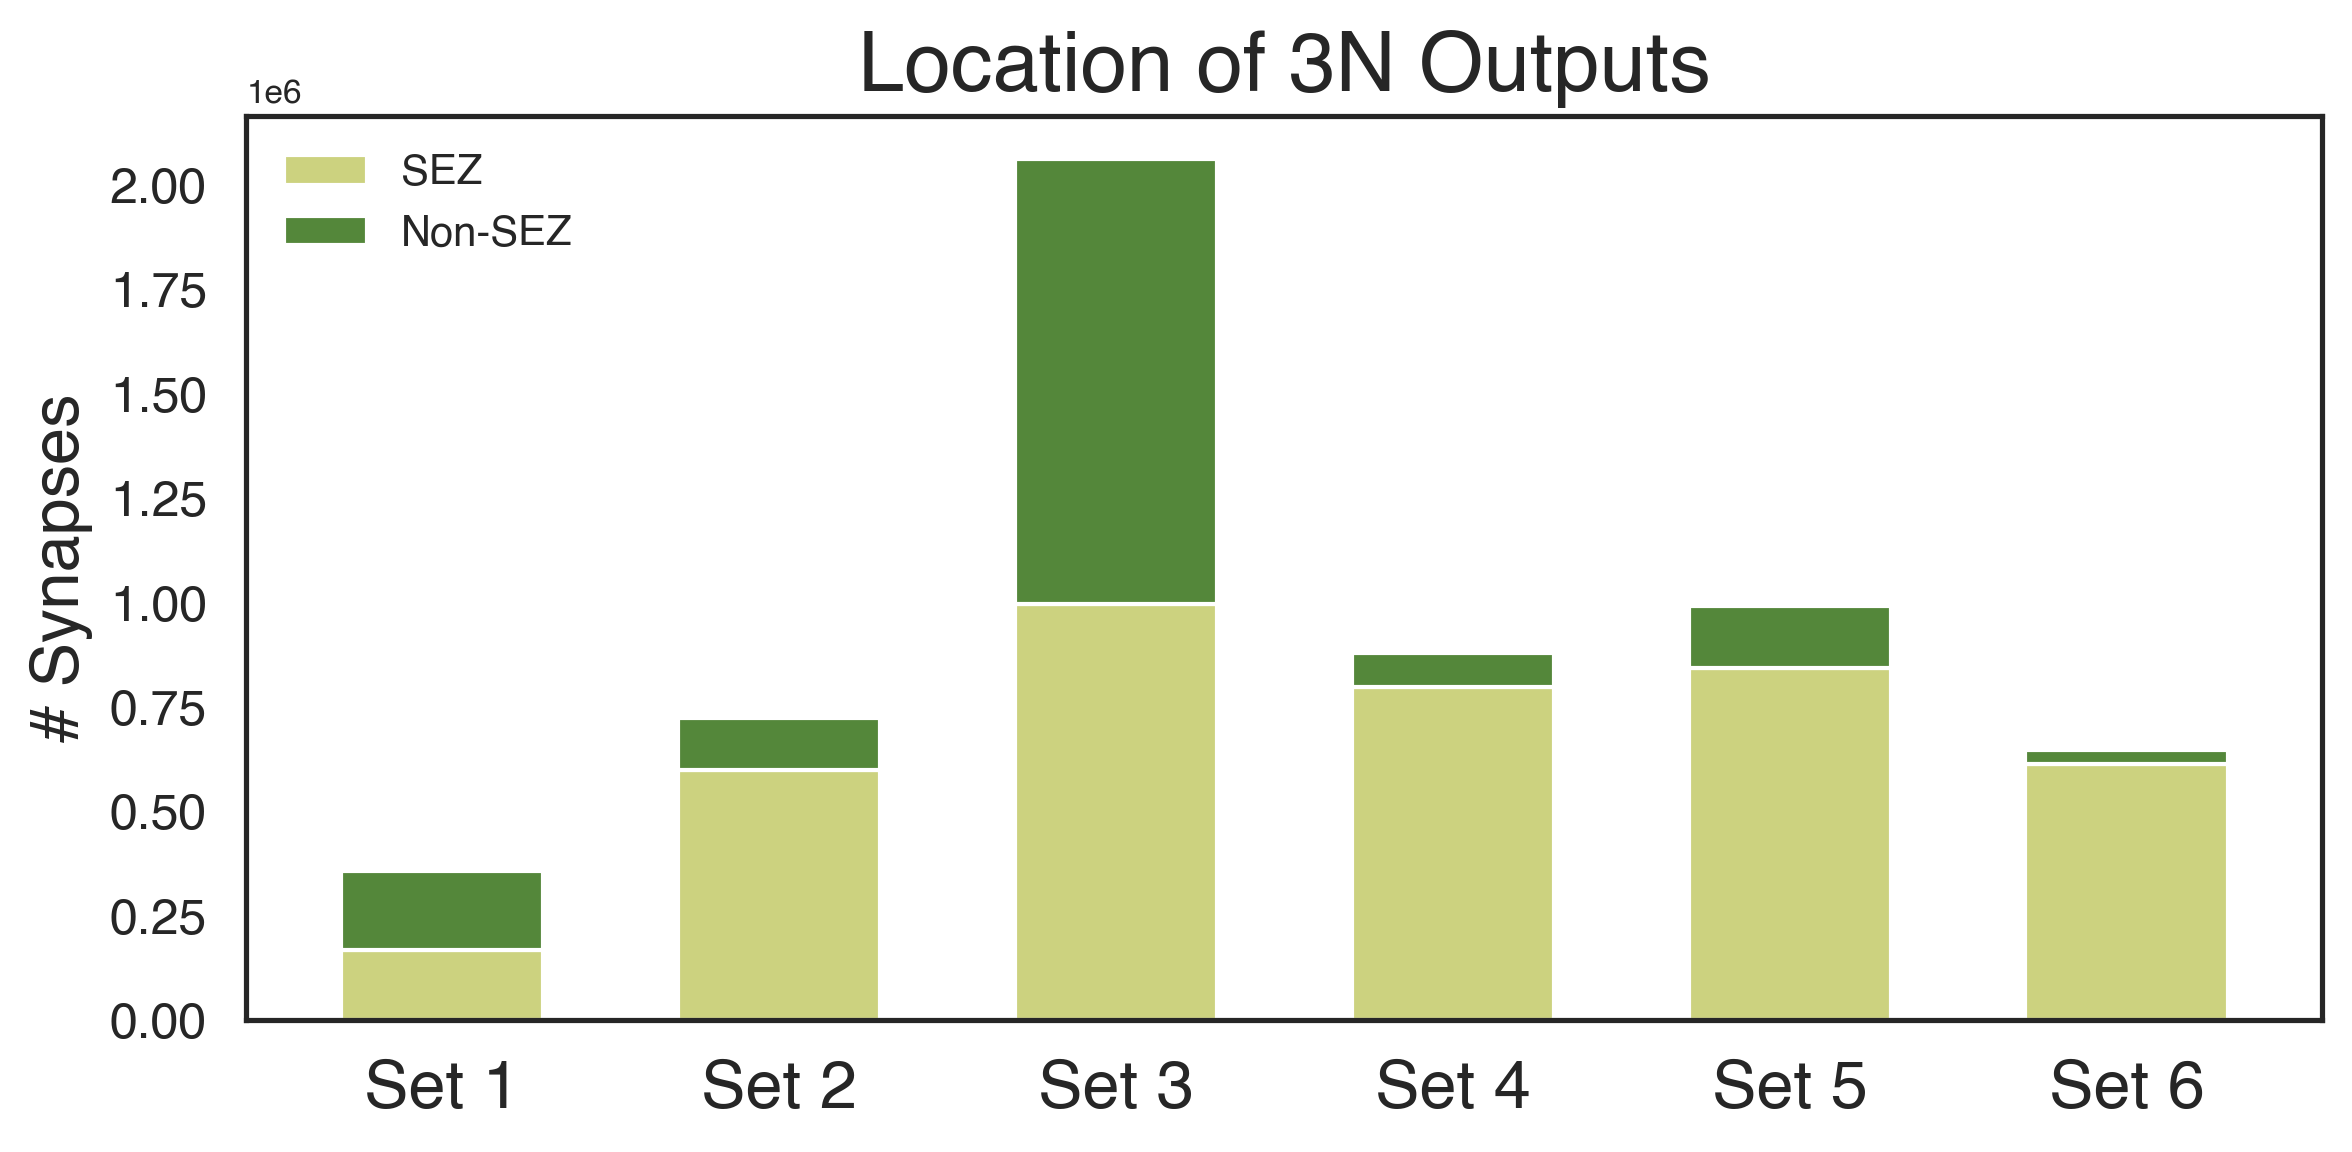

In [93]:
# 1) Define your categories and grab the outputs programmatically
categories = [f"Set {i}" for i in range(1, 7)]
datasets   = [globals()[f"set_{i}_3N_outputs"] for i in range(1, 7)]

# 2) Compute SEZ vs Non-SEZ synapse sums
local_synapses = [
    ds.query("location_of_connection == 'local'")['syn_count'].sum()
    for ds in datasets
]
projection_synapses = [
    ds.query("location_of_connection == 'outside_SEZ'")['syn_count'].sum()
    for ds in datasets
]

# (optional) store for later
chi_3N_synapses = {
    'SEZ':     local_synapses,
    'Non-SEZ': projection_synapses,
}

# 3) Plot stacked bar chart
fig, ax = plt.subplots(figsize=(8, 4))
x = np.arange(len(categories))
width = 0.6

ax.bar(
    x,
    local_synapses,
    width=width,
    color='#CCD27F',
    label='SEZ'
)
ax.bar(
    x,
    projection_synapses,
    width=width,
    bottom=local_synapses,
    color='#54873A',
    label='Non-SEZ'
)

# 4) Formatting
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=16)
ax.set_ylabel('# Synapses', fontsize=16)
ax.set_title('Location of 3N Outputs', fontsize=20)
ax.legend(frameon=False, fontsize=10, loc='upper left')
ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.savefig('/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/General - YaoLabUF/SVG_figs/Fig4/Location_of_3N_Outputs.svg', format='svg', bbox_inches='tight')
plt.show()

In [94]:
# Show numbers of local and non-local synapses
print(local_synapses)
print(projection_synapses)

[168194, 598709, 995521, 797645, 843138, 612398]
[188256, 124465, 1065632, 82333, 148503, 34679]


### Identify 3N superclasses

In [95]:
# Get classifications for all six sets of 3Ns
# 1) Gather your six 3N DataFrames
sets_3N = [globals()[f"set_{i}_3Ns"] for i in range(1, 7)]

In [96]:
# 2) For each set, pull unique root_ids and merge in super_class
classified_3N = []
for df in sets_3N:
    ids = pd.DataFrame({'root_id': df['root_id'].unique()})
    classified = ids.merge(
        classification_other[['root_id', 'super_class']],
        on='root_id',
        how='left'
    )
    classified_3N.append(classified)

# 3) Specify the order you want for superclasses
superclasses = [
    'sensory', 'ascending', 'central',
    'descending', 'motor', 'endocrine',
    'optic', 'visual_projection', 'visual_centrifugal'
]

In [97]:
# reorder the superclasses in desired order
categories = ['sensory', 'ascending', 'central',
              'descending', 'motor', 'endocrine',
              'optic', 'visual_projection', 'visual_centrifugal']
categories

['sensory',
 'ascending',
 'central',
 'descending',
 'motor',
 'endocrine',
 'optic',
 'visual_projection',
 'visual_centrifugal']

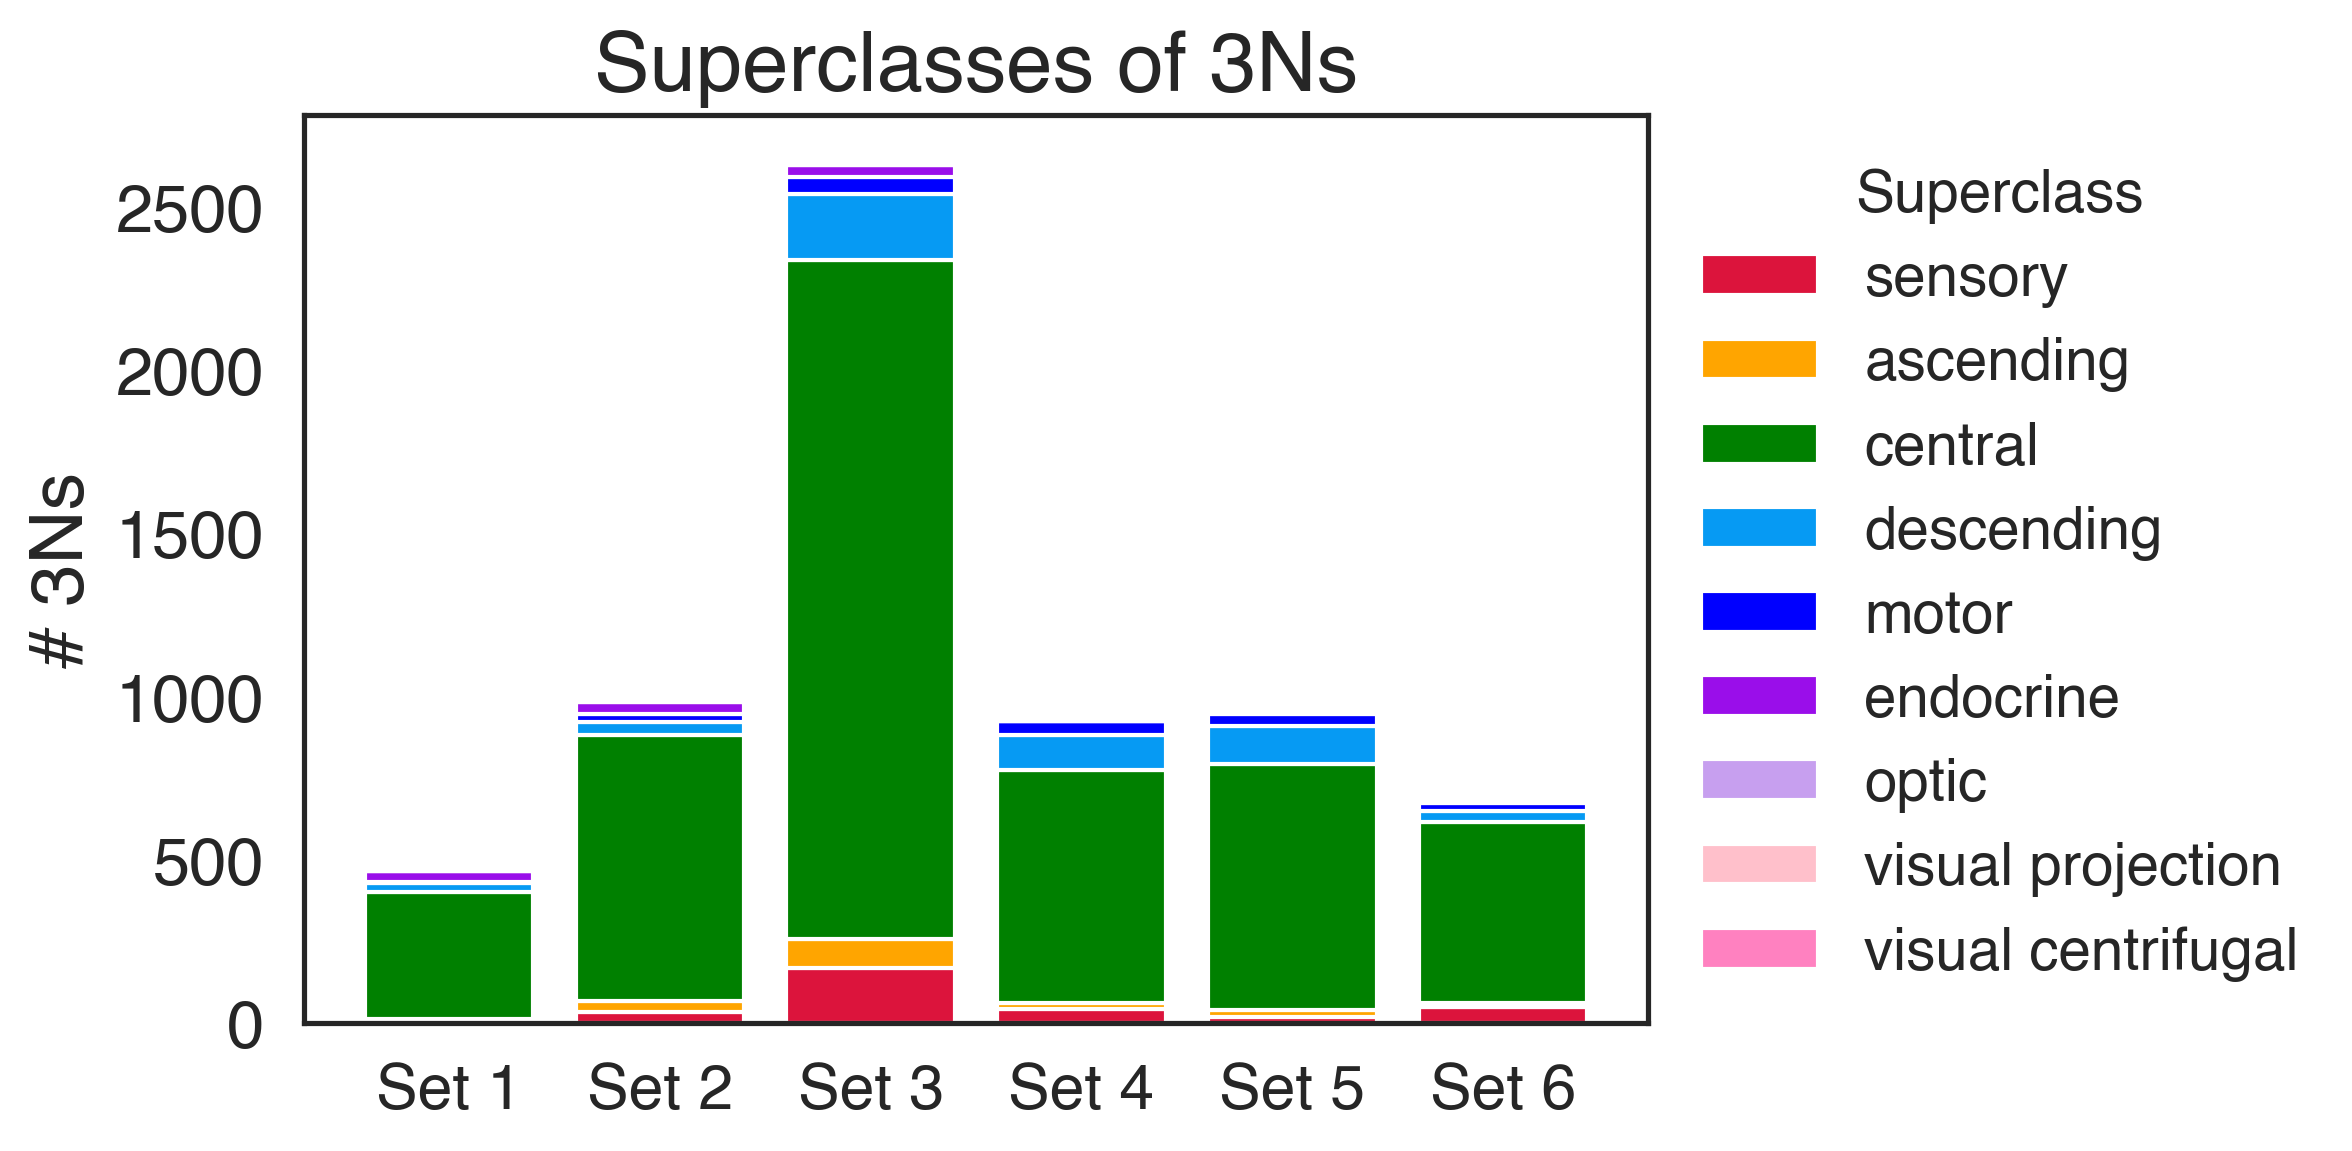

In [98]:
# 4) Count how many 3Ns fall into each superclass, per set
counts_per_set = [c['super_class'].value_counts() for c in classified_3N]

# 5) Build an array of shape (n_superclasses, 6)
array_plot = np.array([
    [counts_per_set[j].get(cls, 0) for j in range(6)]
    for cls in superclasses
])

# 6) Plot a stacked‐bar chart
categories = [f"Set {i}" for i in range(1,7)]
palette = [
    '#dc143c','#ffa500','green',
    '#069af3','#0000ff','#9a0eea',
    '#c79fef','#ffc0cb','#ff81c0'
]

fig, ax = plt.subplots(figsize=(8, 4))
x = np.arange(len(categories))
bottom = np.zeros(len(categories), dtype=int)

for idx, cls in enumerate(superclasses):
    ax.bar(
        x,
        array_plot[idx],
        width=0.8,
        bottom=bottom,
        color=palette[idx],
        label=cls.replace('_', ' ')
    )
    bottom += array_plot[idx]

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=15)
ax.set_ylabel('# 3Ns', fontsize=18)
ax.set_title('Superclasses of 3Ns', fontsize=20)
ax.legend(
    title='Superclass',
    loc='upper left',
    bbox_to_anchor=(1,1),
    frameon=False,
    fontsize=14
)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/General - YaoLabUF/SVG_figs/Fig4/Superclasses_of_3Ns.svg', format='svg', bbox_inches='tight')
plt.show()




In [99]:
# Get values for proportion of each type
array_plot/np.sum(array_plot, axis=0)

array([[0.00214592, 0.03437816, 0.06457704, 0.04859611, 0.02083333,
        0.07205882],
       [0.027897  , 0.03437816, 0.03247734, 0.01835853, 0.02083333,
        0.01764706],
       [0.8304721 , 0.82305359, 0.78512085, 0.7699784 , 0.784375  ,
        0.81470588],
       [0.06437768, 0.04044489, 0.07628399, 0.11771058, 0.121875  ,
        0.05      ],
       [0.00429185, 0.02426694, 0.01963746, 0.04535637, 0.03958333,
        0.03970588],
       [0.07081545, 0.03943377, 0.01359517, 0.        , 0.00729167,
        0.00588235],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.00404449, 0.00377644, 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00453172, 0.        , 0.00520833,
        0.        ]])

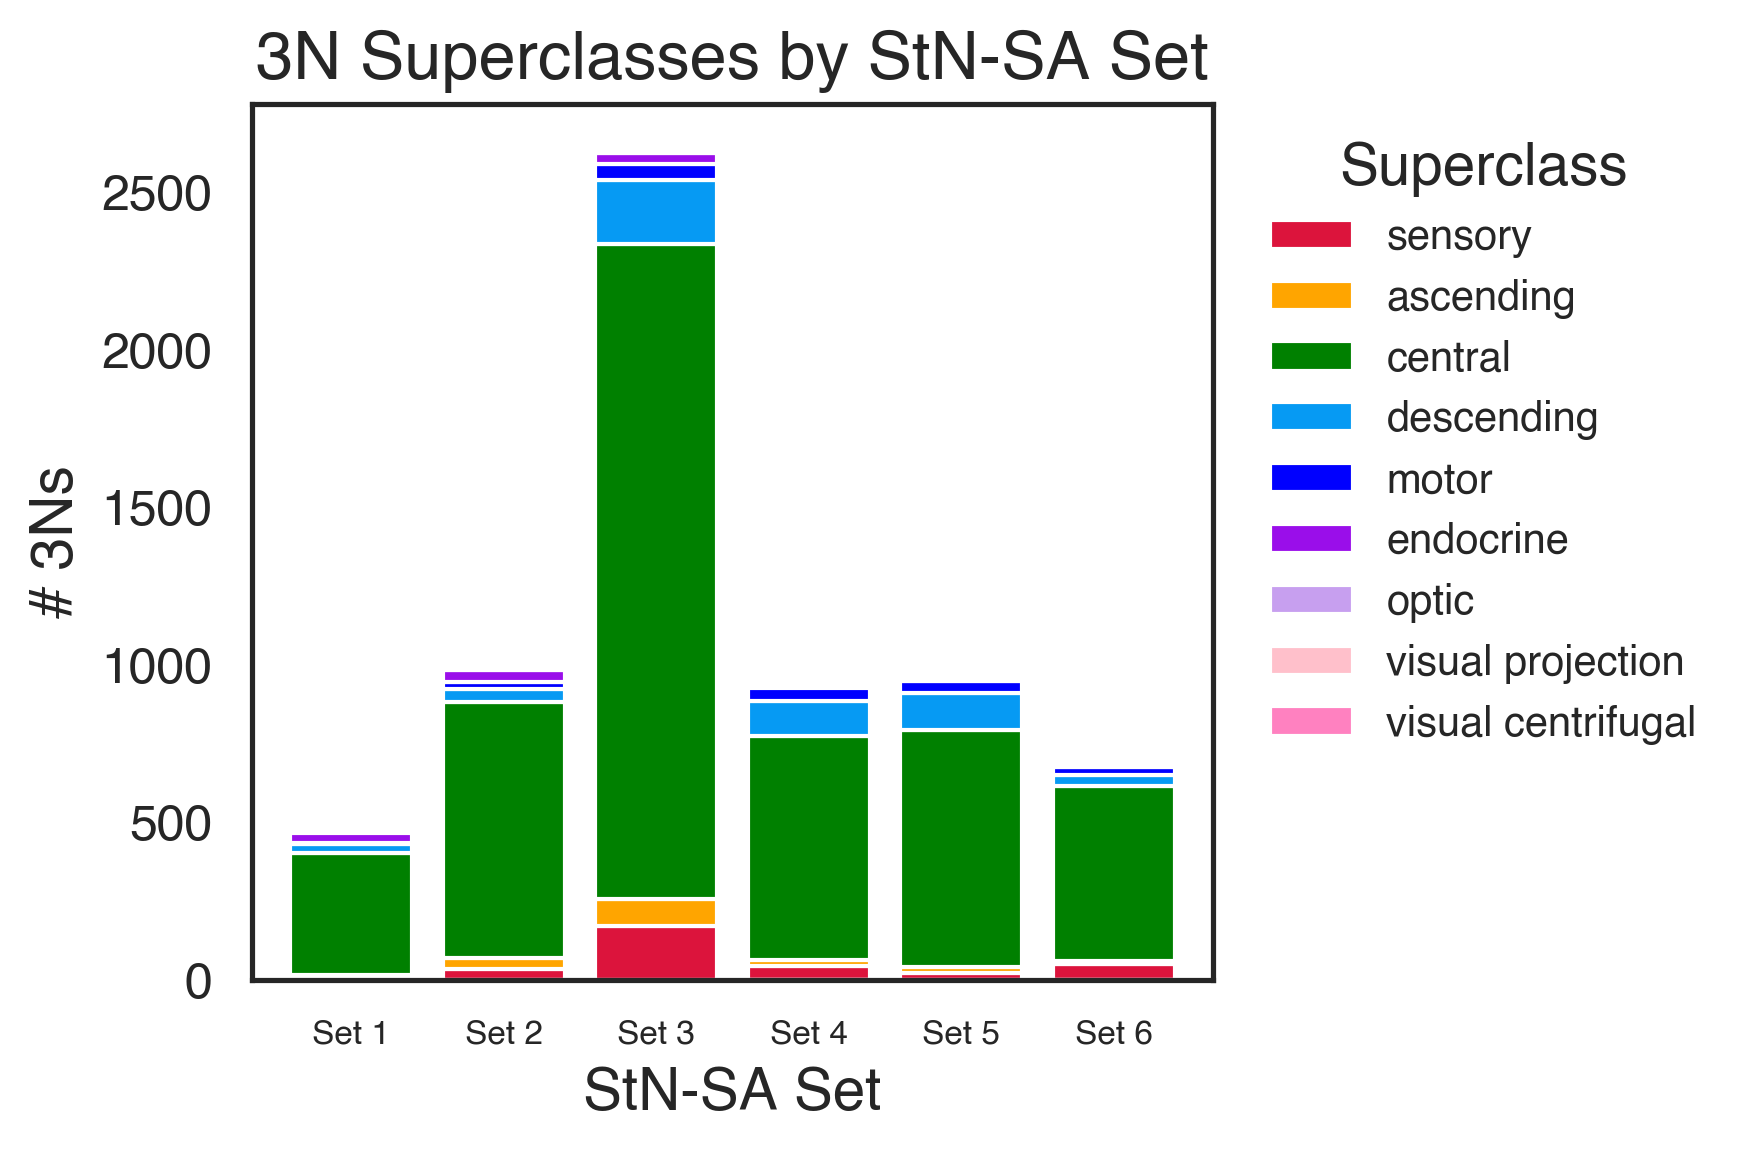

In [100]:
### Identify 3N superclasses and plot
# 1) Pull in only root_id + super_class from classification_other
cls_lookup = classification_other[['root_id', 'super_class']].drop_duplicates()

# 2) Merge that onto each set_i_3Ns to create a *_classified DataFrame
for i in range(1, 7):
    three = globals()[f"set_{i}_3Ns"]
    merged = pd.merge(
        three[['root_id']].drop_duplicates(),
        cls_lookup,
        on='root_id',
        how='left'
    )
    globals()[f"set_{i}_3Ns_classified"] = merged

# 3) Prepare for plotting
set_labels = [f"Set {i}" for i in range(1, 7)]
superclasses = [
    'sensory', 'ascending', 'central',
    'descending', 'motor', 'endocrine',
    'optic', 'visual_projection', 'visual_centrifugal'
]

# 4) Build counts DataFrame: rows=superclasses, cols=sets
counts_df = pd.DataFrame(index=superclasses, columns=set_labels, dtype=int)
for lbl, df in zip(set_labels,
                   [globals()[f"set_{i}_3Ns_classified"] for i in range(1, 7)]):
    vc = df['super_class'].value_counts()
    counts_df[lbl] = vc.reindex(superclasses, fill_value=0)

# 5) Sanity‐check
for lbl, df in zip(set_labels,
                   [globals()[f"set_{i}_3Ns_classified"] for i in range(1, 7)]):
    assert counts_df[lbl].sum() == df['root_id'].nunique(), (
        f"{lbl}: plotting {counts_df[lbl].sum()} but have {df['root_id'].nunique()}"
    )

# 6) Plot stacked bar
palette = [
    '#dc143c', '#ffa500', 'green', '#069af3',
    '#0000ff', '#9a0eea', '#c79fef', '#ffc0cb', '#ff81c0'
]

ax = counts_df.T.plot(
    kind='bar',
    stacked=True,
    figsize=(6, 4),
    color=palette,
    width=0.8,
    legend=False,
    rot=0
)

ax.set_xlabel("StN-SA Set", fontsize=14)
ax.set_ylabel("# 3Ns", fontsize=14)
ax.set_title("3N Superclasses by StN-SA Set", fontsize=16)
ax.tick_params(axis='y', labelsize=12)

ax.legend(
    [s.replace('_', ' ') for s in superclasses],
    title="Superclass",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    frameon=False,
    fontsize=10
)

plt.tight_layout()
plt.savefig("3N_superclasses_by_set.svg", format="svg", bbox_inches="tight")
plt.show()


                    Set 1  Set 2  Set 3  Set 4  Set 5  Set 6
sensory                 1     34    171     45     20     49
ascending              13     34     86     17     20     12
central               387    814   2079    713    753    554
descending             30     40    202    109    117     34
motor                   2     24     52     42     38     27
endocrine              33     39     36      0      7      4
optic                   0      0      0      0      0      0
visual_projection       0      4     10      0      0      0
visual_centrifugal      0      0     12      0      5      0


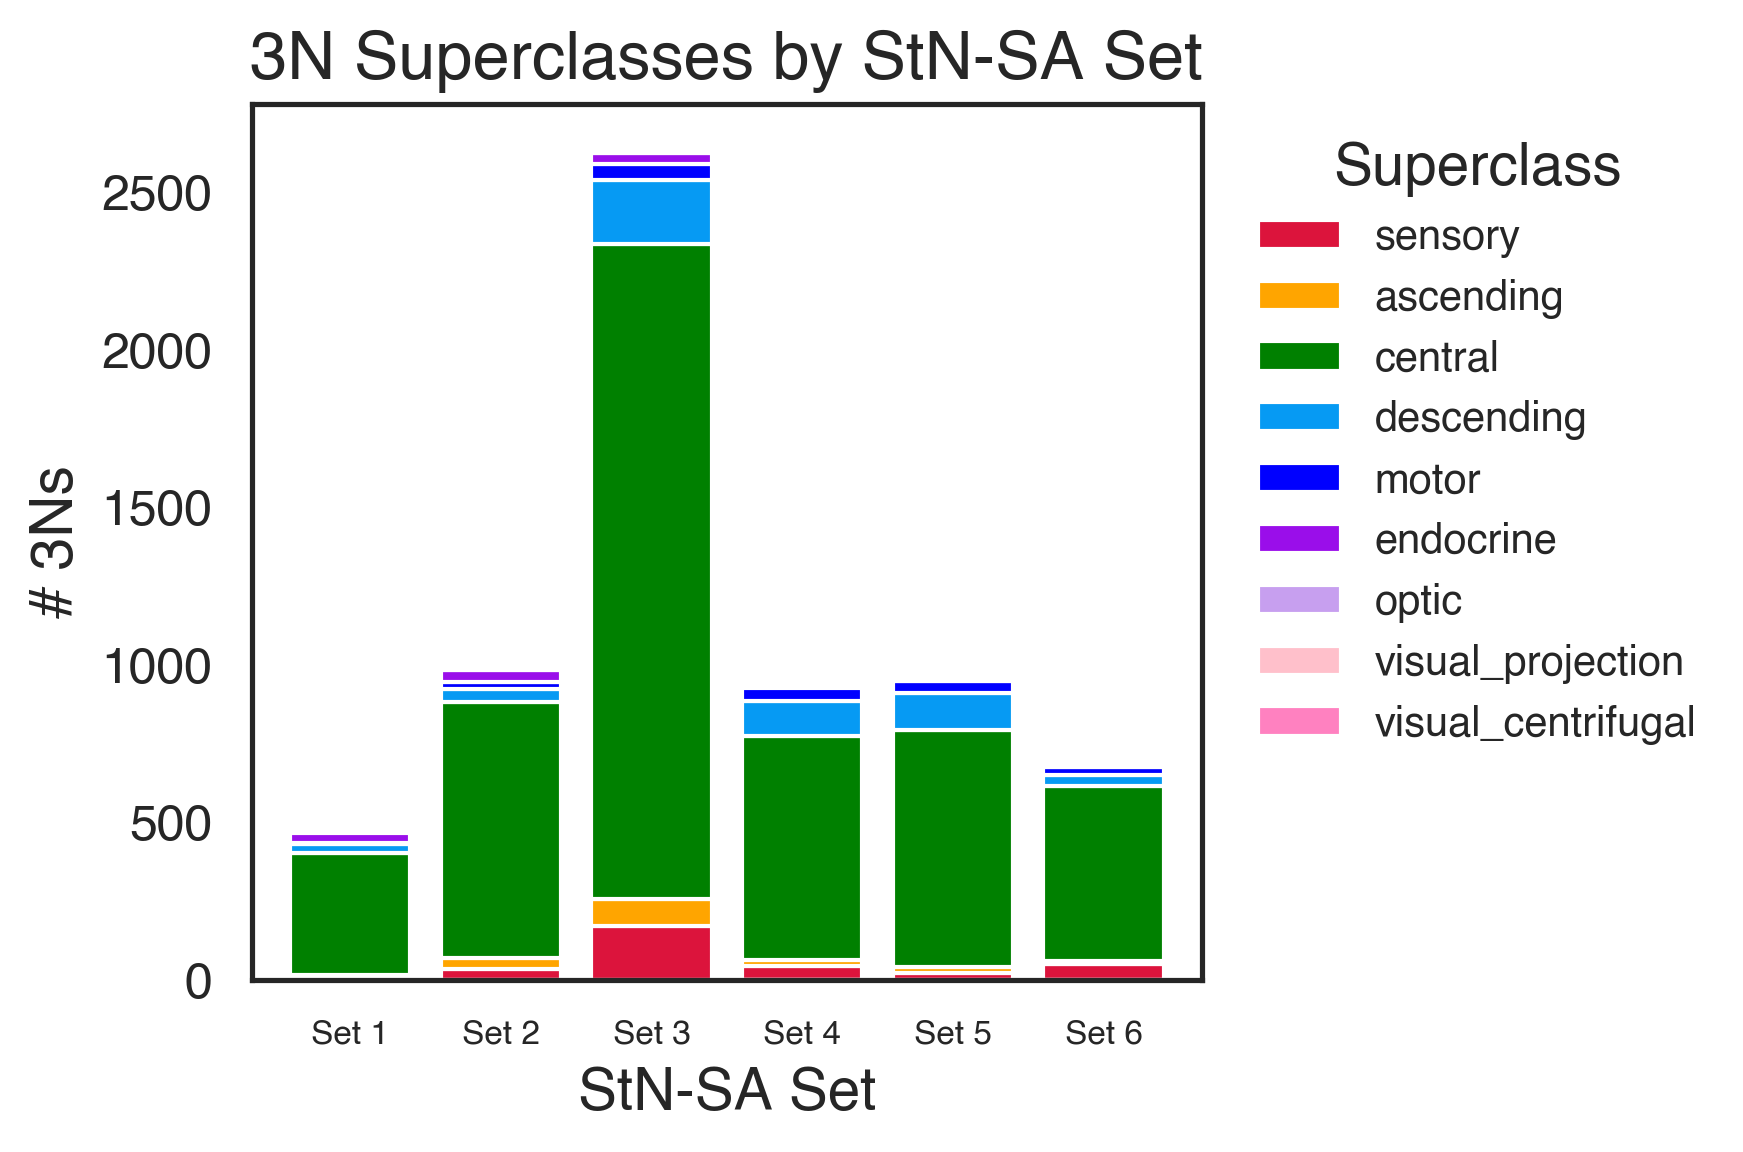

In [101]:
# 1) Gather all six classified DataFrames dynamically
sets = [f"Set {i}" for i in range(1, 7)]
dfs  = [globals()[f"set_{i}_3Ns_classified"] for i in range(1, 7)]

# 2) Define the exact order of superclasses
categories = [
    'sensory', 'ascending', 'central',
    'descending', 'motor', 'endocrine',
    'optic', 'visual_projection', 'visual_centrifugal'
]

# 3) Build a DataFrame of counts, reindexing to ensure all categories appear
counts_dict = {
    set_name: df['super_class']
                   .fillna('')                      # in case of any NaNs
                   .value_counts()
                   .reindex(categories, fill_value=0)
    for set_name, df in zip(sets, dfs)
}
counts_df = pd.DataFrame(counts_dict, index=categories).astype(int)

# 4) Sanity check: each column sum should equal number of unique 3Ns in that set
for set_name, df in zip(sets, dfs):
    total_neurons   = df['root_id'].nunique()
    plotted_neurons = counts_df[set_name].sum()
    assert plotted_neurons == total_neurons, (
        f"{set_name}: plotting {plotted_neurons} but have {total_neurons}"
    )

# 5) Inspect
print(counts_df)

# 6) Plot
palette = [
    '#dc143c','#ffa500','green','#069af3',
    '#0000ff','#9a0eea','#c79fef','#ffc0cb','#ff81c0'
]

ax = counts_df.T.plot(
    kind='bar',
    stacked=True,
    figsize=(6, 4),
    color=palette,
    width=0.8,
    legend=False,
    rot=0,               # horizontal x-labels
)

ax.set_ylabel("# 3Ns",       fontsize=14)
ax.set_xlabel("StN-SA Set",  fontsize=14)
ax.set_title("3N Superclasses by StN-SA Set", fontsize=16)
ax.tick_params(axis='y', labelsize=12)

ax.legend(
    labels=categories,
    title="Superclass",
    bbox_to_anchor=(1.02, 1),
    frameon=False,
    fontsize=10
)

plt.tight_layout()
plt.show()


### Identify 3N classes

### Quantify the neurotransmitter types for local and projection 3N outputs across modalities

We are only including ACH, GABA, GLUT neurotransmitter types here, which represent the vast majority of 3N synapses.

Note that this analysis quantifies 3N outputs by the number of connections, not synapses.

In [102]:
def count_NTs_local(datasets, categories):
    """
    For each dataset in datasets (representing a set of 3N outputs),
    filter to local outputs and count the total synapse counts for each
    neurotransmitter type (ACH, GABA, GLUT).
    """
    counts_ACH = []
    counts_GABA = []
    counts_GLUT = []
    for dataset in datasets:
        # Filter to local outputs and relevant NT types.
        local_subset = dataset.query("location_of_connection == 'local' and nt_type in ['ACH', 'GABA', 'GLUT']")
        counts_ACH.append(local_subset.query("nt_type == 'ACH'")['syn_count'].sum())
        counts_GABA.append(local_subset.query("nt_type == 'GABA'")['syn_count'].sum())
        counts_GLUT.append(local_subset.query("nt_type == 'GLUT'")['syn_count'].sum())
    return [np.array(counts_ACH), np.array(counts_GABA), np.array(counts_GLUT)]

def count_neurons_local(datasets, categories):
    """
    For each dataset, count the number of unique neurons (using the 'pre_root_id'
    column, since that is available) for each neurotransmitter type among local outputs.
    """
    neurons_ACH = []
    neurons_GABA = []
    neurons_GLUT = []
    for dataset in datasets:
        local_subset = dataset.query("location_of_connection == 'local' and nt_type in ['ACH', 'GABA', 'GLUT']")
        neurons_ACH.append(local_subset.query("nt_type == 'ACH'")['pre_root_id'].nunique())
        neurons_GABA.append(local_subset.query("nt_type == 'GABA'")['pre_root_id'].nunique())
        neurons_GLUT.append(local_subset.query("nt_type == 'GLUT'")['pre_root_id'].nunique())
    return [np.array(neurons_ACH), np.array(neurons_GABA), np.array(neurons_GLUT)]


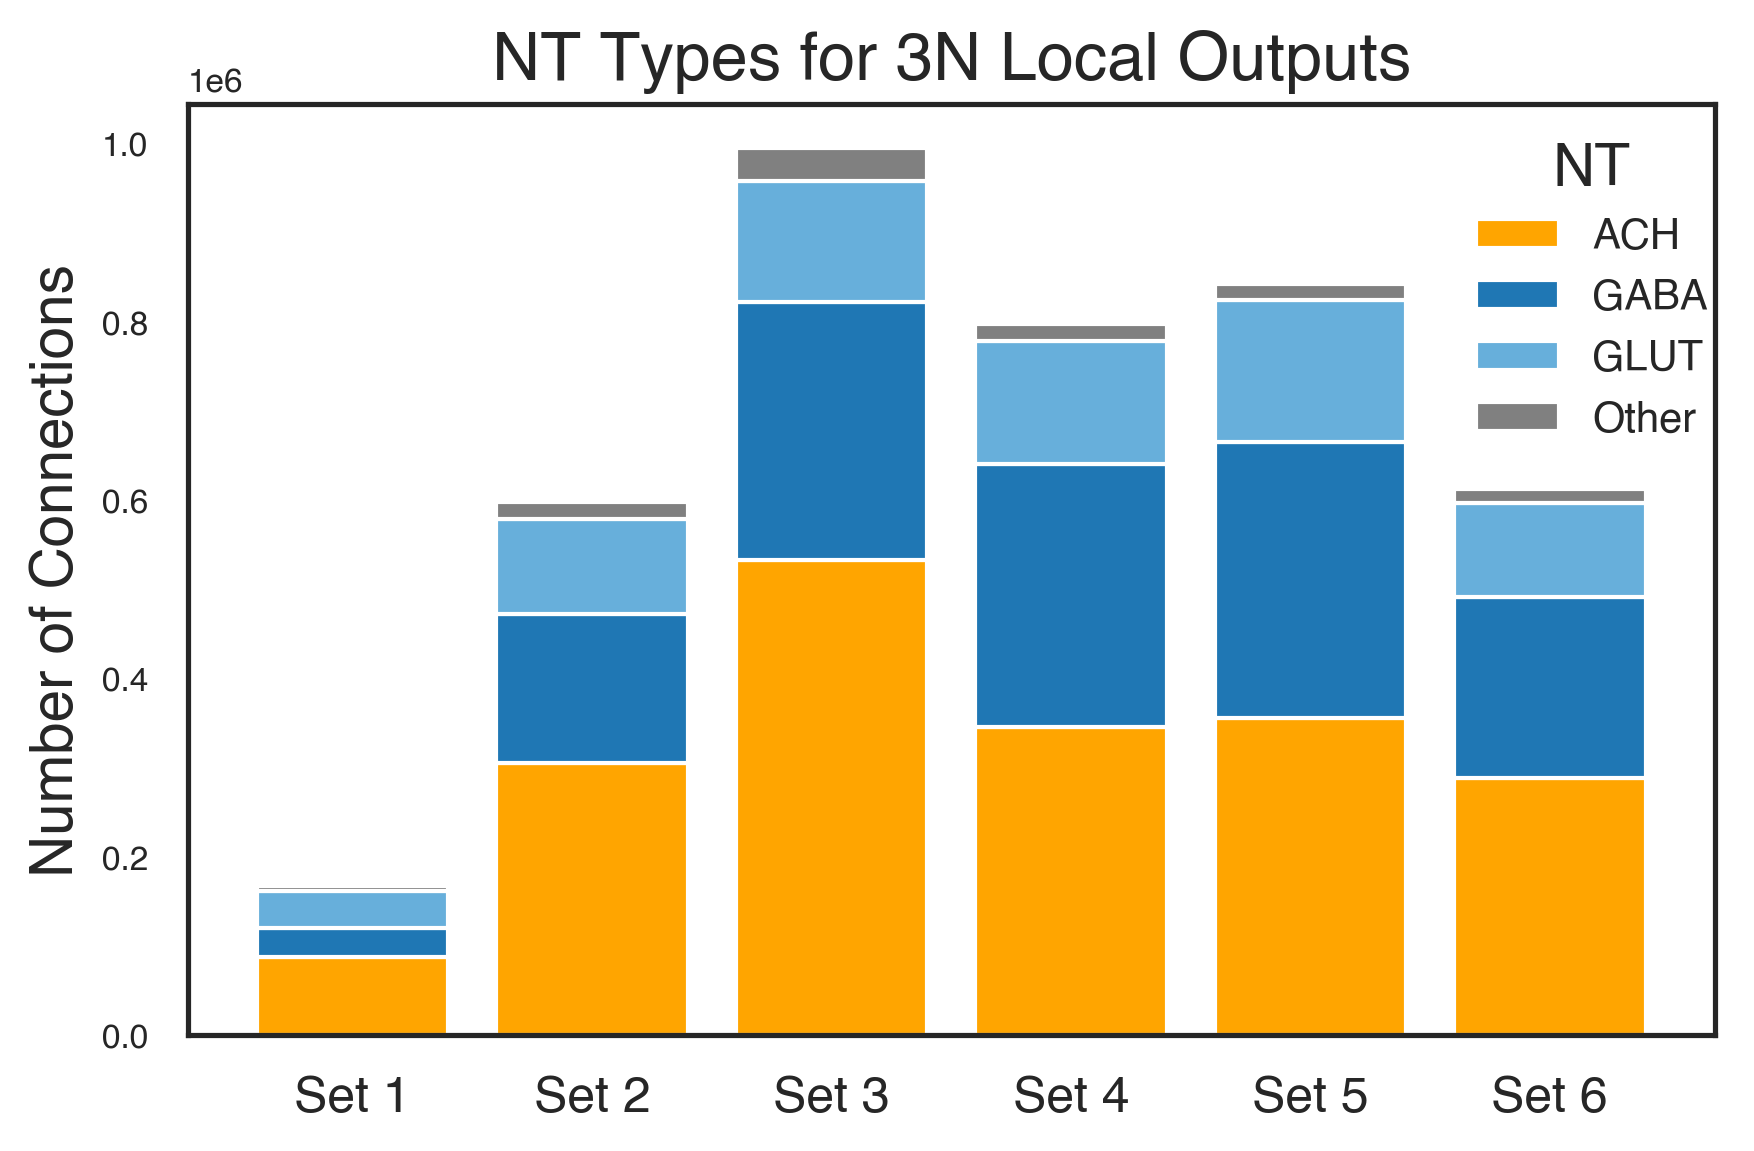

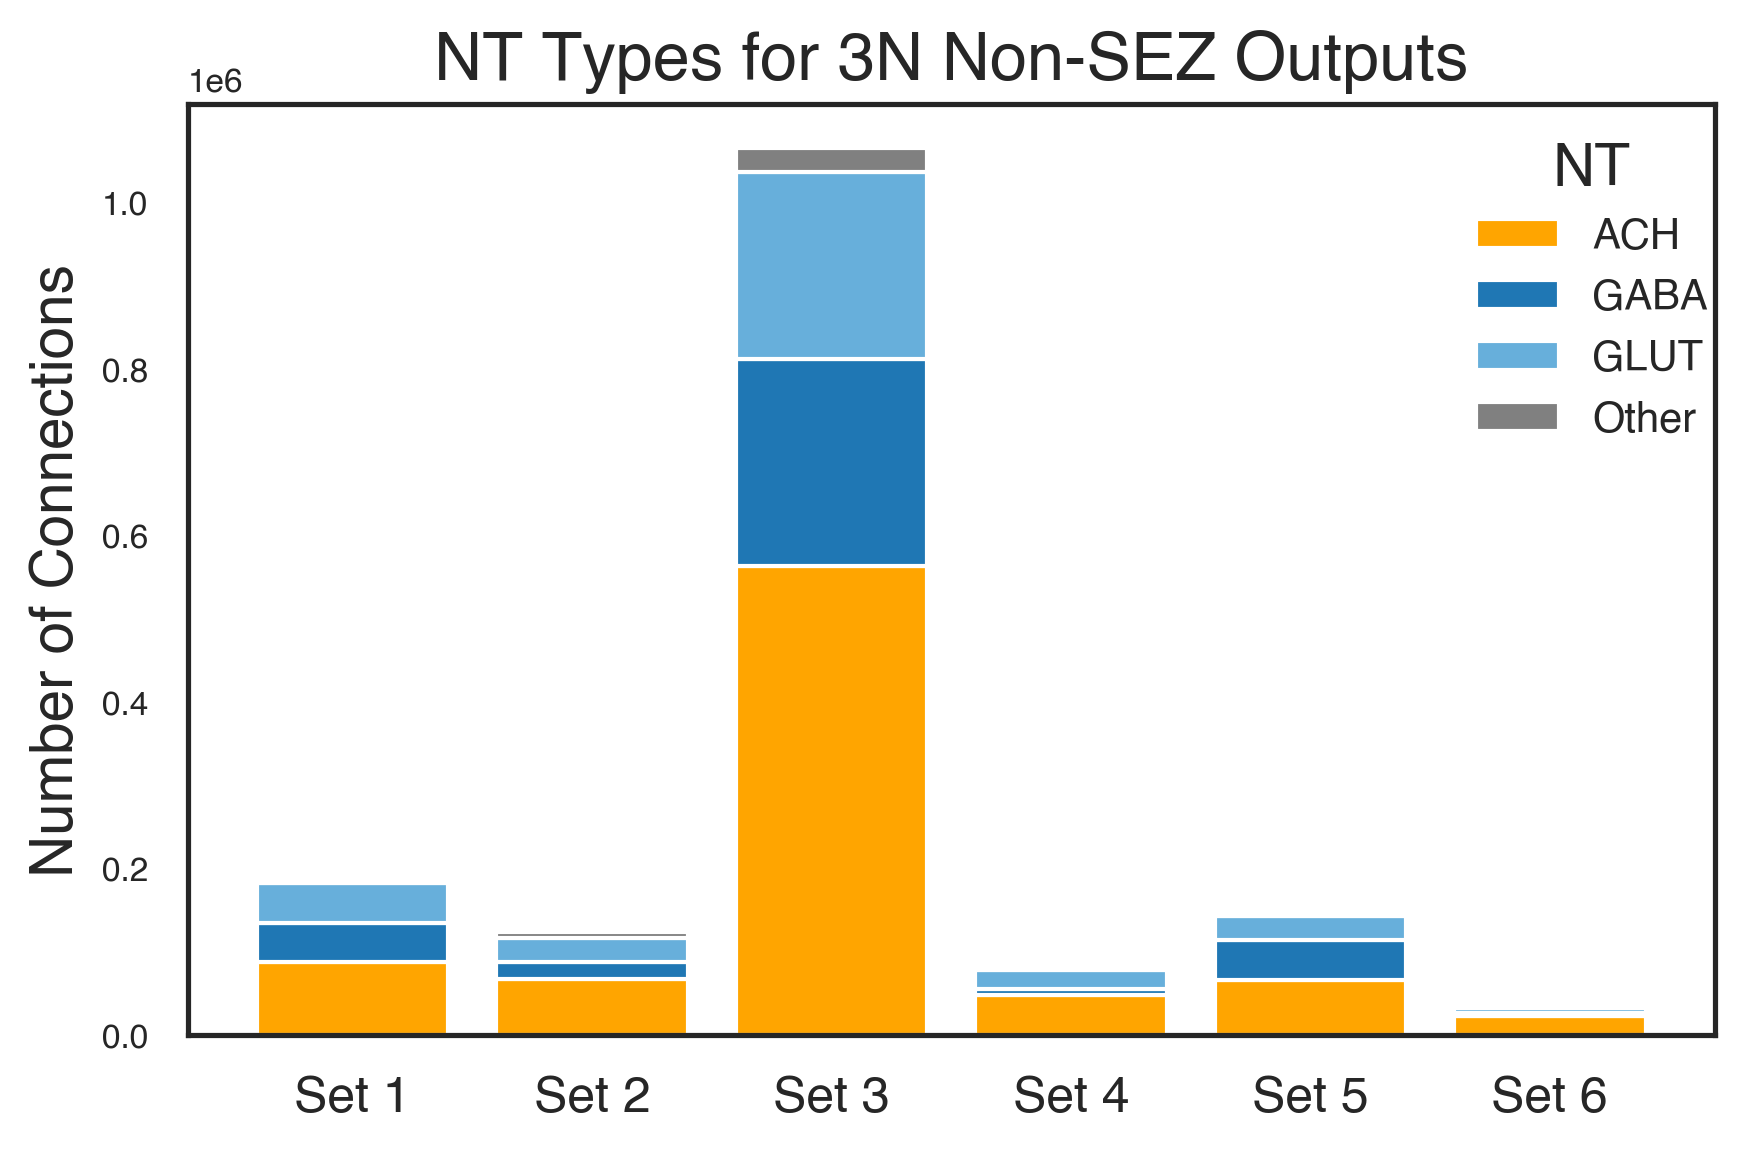

In [103]:


# 1) Prepare your labels and grab the six 3N‐output DataFrames
set_labels   = [f"Set {i}" for i in range(1,7)]
datasets_3N  = [globals()[f"set_{i}_3N_outputs"] for i in range(1,7)]

# 2) Define neurotransmitter groups
primary_NTs = ['ACH','GABA','GLUT']
other_NTs   = ['DA','SER']
plot_NTs    = primary_NTs + ['Other']
color_map   = {'ACH':'orange','GABA':'#1f77b4','GLUT':'#67afdb','Other':'gray'}

# 3) Initialize counters
local_counts = {nt: [] for nt in plot_NTs}
proj_counts  = {nt: [] for nt in plot_NTs}

# 4) Populate counts
for ds in datasets_3N:
    local = ds[ds.location_of_connection == 'local']
    proj  = ds[ds.location_of_connection == 'outside_SEZ']
    # primaries
    for nt in primary_NTs:
        local_counts[nt].append(local[local.nt_type == nt]['syn_count'].sum())
        proj_counts [nt].append(proj [proj .nt_type == nt]['syn_count'].sum())
    # Other = DA + SER
    local_counts['Other'].append(local[local.nt_type.isin(other_NTs)]['syn_count'].sum())
    proj_counts ['Other'].append(proj [proj .nt_type.isin(other_NTs)]['syn_count'].sum())

x = np.arange(len(datasets_3N))

# 5) Plot Local (SEZ) outputs
fig, ax = plt.subplots(figsize=(6,4))
bottom = np.zeros_like(x)
for nt in plot_NTs:
    vals = np.array(local_counts[nt])
    ax.bar(x, vals, width=0.8, bottom=bottom, color=color_map[nt], label=nt)
    bottom += vals

ax.set_xticks(x)
ax.set_xticklabels(set_labels, fontsize=12)
ax.set_ylabel('Number of Connections', fontsize=14)
ax.set_title('NT Types for 3N Local Outputs', fontsize=16)
ax.legend(title='NT', frameon=False, bbox_to_anchor=(1.02,1), fontsize=10)
plt.tight_layout()
plt.savefig('NT_Types_3N_local.svg', format='svg', bbox_inches='tight')
plt.show()

# 6) Plot Projection (Non-SEZ) outputs
fig, ax = plt.subplots(figsize=(6,4))
bottom = np.zeros_like(x)
for nt in plot_NTs:
    vals = np.array(proj_counts[nt])
    ax.bar(x, vals, width=0.8, bottom=bottom, color=color_map[nt], label=nt)
    bottom += vals

ax.set_xticks(x)
ax.set_xticklabels(set_labels, fontsize=12)
ax.set_ylabel('Number of Connections', fontsize=14)
ax.set_title('NT Types for 3N Non-SEZ Outputs', fontsize=16)
ax.legend(title='NT', frameon=False, bbox_to_anchor=(1.02,1), fontsize=10)
plt.tight_layout()
plt.savefig('NT_Types_3N_nonSEZ.svg', format='svg', bbox_inches='tight')
plt.show()


### Quantify 3N projections to each brain region
### Start by consolidating bilateral brain regions for second order outputs

In [104]:
# Apply region remapping for all six sets
for i in range(1, 7):
    df = globals()[f"set_{i}_3N_outputs"]
    df['neuropil_remap'] = df['neuropil'].map(lambda x: region_mapping.get(x, x))
    globals()[f"set_{i}_3N_outputs"] = df

### Make bar graphs of brain regions with 3N output synapses

In [105]:
# 2) Compute each set’s top-12 non-SEZ regions
top12_by_set = {}
for i in range(1, 7):
    top12_by_set[i] = get_top12_regions(globals()[f"set_{i}_3N_outputs"])
    print(f"Set {i} top-12:", top12_by_set[i])

# 3) Pool all six sets, get a user-tunable global top-N
all_3N = pd.concat([globals()[f"set_{i}_3N_outputs"] for i in range(1,7)],
                   ignore_index=True)

Set 1 top-12: ['FB', 'ICL', 'SCL', 'LH', 'SPS', 'SLP', 'AVLP', 'IB', 'SIP', 'CRE', 'VES', 'SMP']
Set 2 top-12: ['LH', 'IB', 'CRE', 'SCL', 'AL', 'AVLP', 'FB', 'SIP', 'VES', 'SLP', 'LAL', 'SMP']
Set 3 top-12: ['SCL', 'LH', 'AL', 'IB', 'PLP', 'LAL', 'SLP', 'VES', 'AVLP', 'SPS', 'ICL', 'SMP']
Set 4 top-12: ['IB', 'MB_CA', 'ICL', 'SIP', 'SPS', 'FB', 'SCL', 'LH', 'AL', 'VES', 'SLP', 'SMP']
Set 5 top-12: ['CRE', 'AL', 'LH', 'SCL', 'SIP', 'IPS', 'ICL', 'SPS', 'SLP', 'LAL', 'VES', 'SMP']
Set 6 top-12: ['LH', 'SPS', 'WED', 'AOTU', 'CRE', 'AVLP', 'SIP', 'AL', 'LAL', 'SLP', 'VES', 'SMP']


In [106]:
# drop SEZ
syn_by_region = (
    all_3N
    .groupby('neuropil_remap')['syn_count']
    .sum()
    .drop(['GNG','PRW','SAD','FLA','CAN'], errors='ignore')
)

In [107]:
N = 12   # ← tweak this
global_topN = syn_by_region.nlargest(N).index.tolist()
print(f"Global top-{N} regions:", global_topN)


Global top-12 regions: ['SMP', 'ICL', 'SPS', 'VES', 'AVLP', 'SLP', 'LAL', 'PLP', 'AL', 'LH', 'IB', 'SCL']


In [108]:
# 4) Helper to count synapses per NT (ACH, GABA, GLUT, Other=DA+SER)
def count_NTs_3N_brainregions(dfs):
    ach = []; gaba = []; glut = []; other = []
    for df in dfs:
        ach.append (df.query("nt_type=='ACH'") ['syn_count'].sum())
        gaba.append(df.query("nt_type=='GABA'")['syn_count'].sum())
        glut.append(df.query("nt_type=='GLUT'")['syn_count'].sum())
        other.append(df.query("nt_type in ['DA','SER']")['syn_count'].sum())
    return (np.array(ach),
            np.array(gaba),
            np.array(glut),
            np.array(other))

color_map = {'ACH':'orange','GABA':'#1f77b4','GLUT':'#67afdb','Other':'gray'}

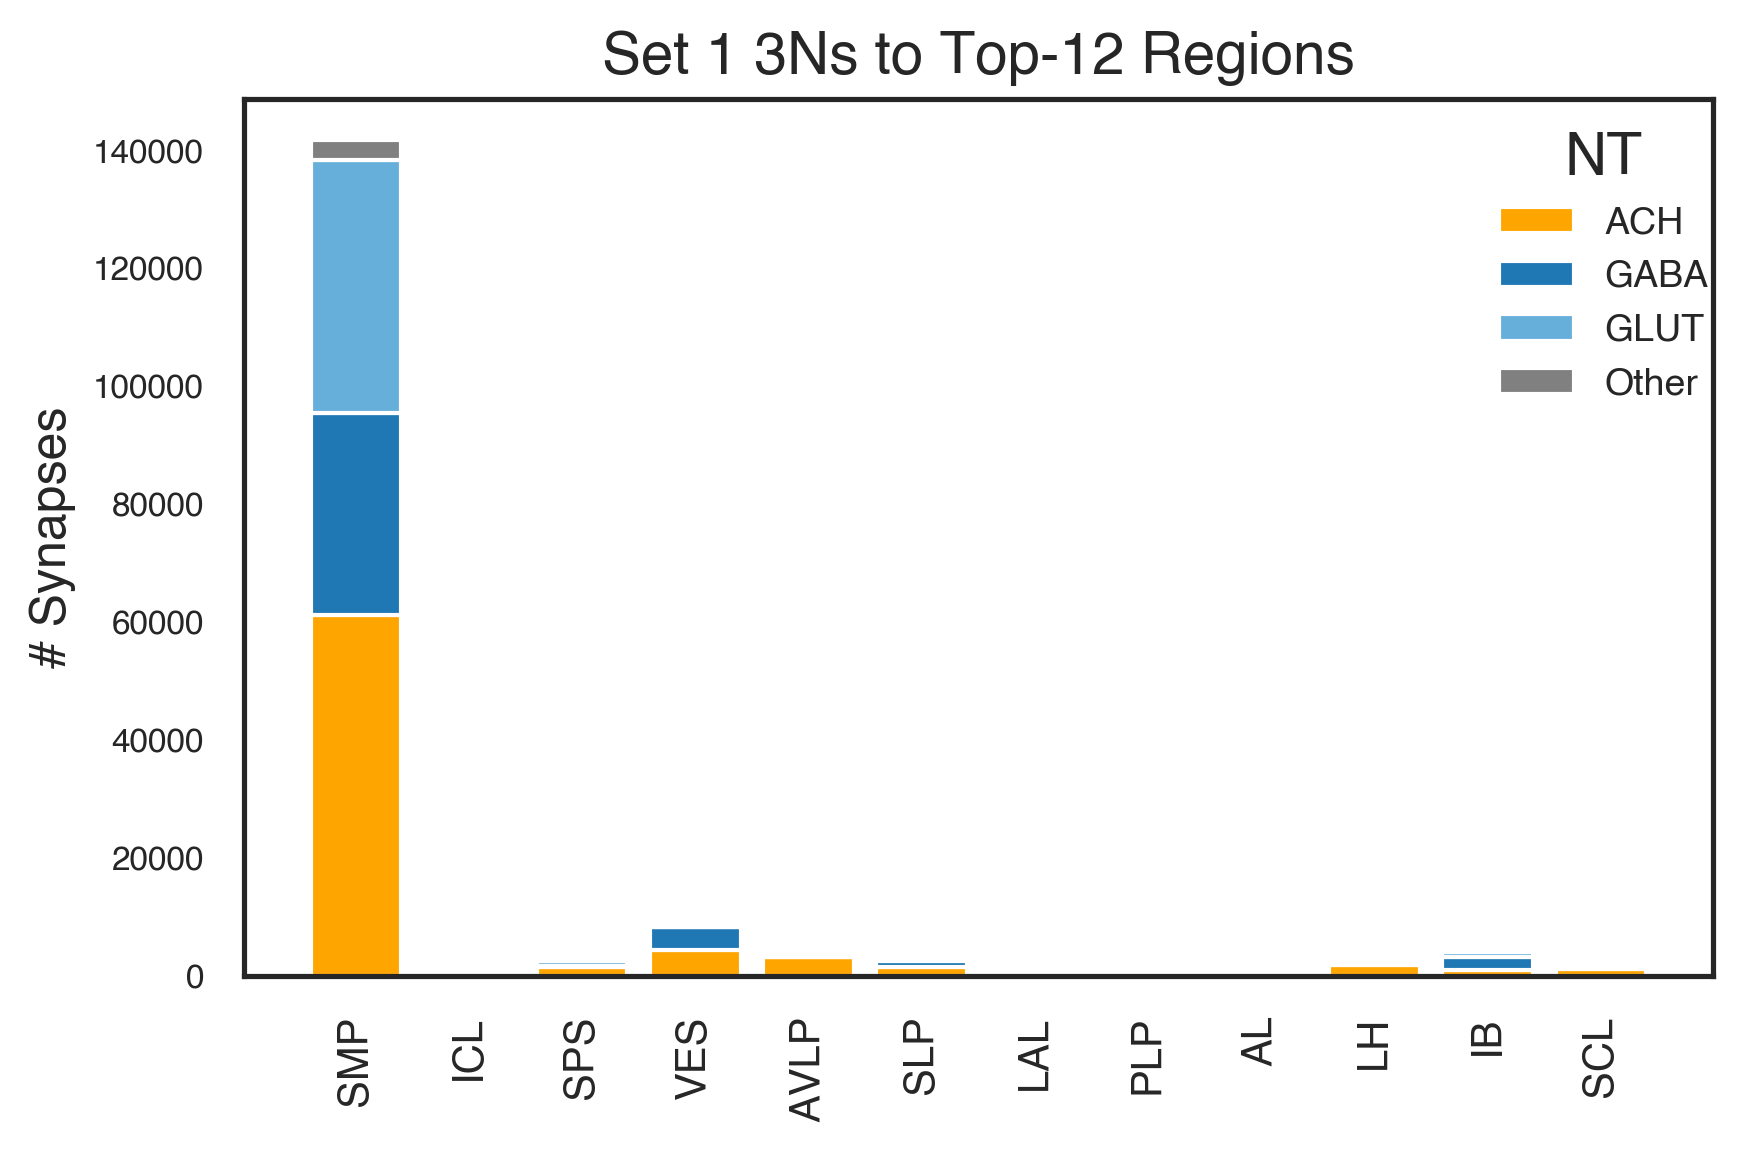

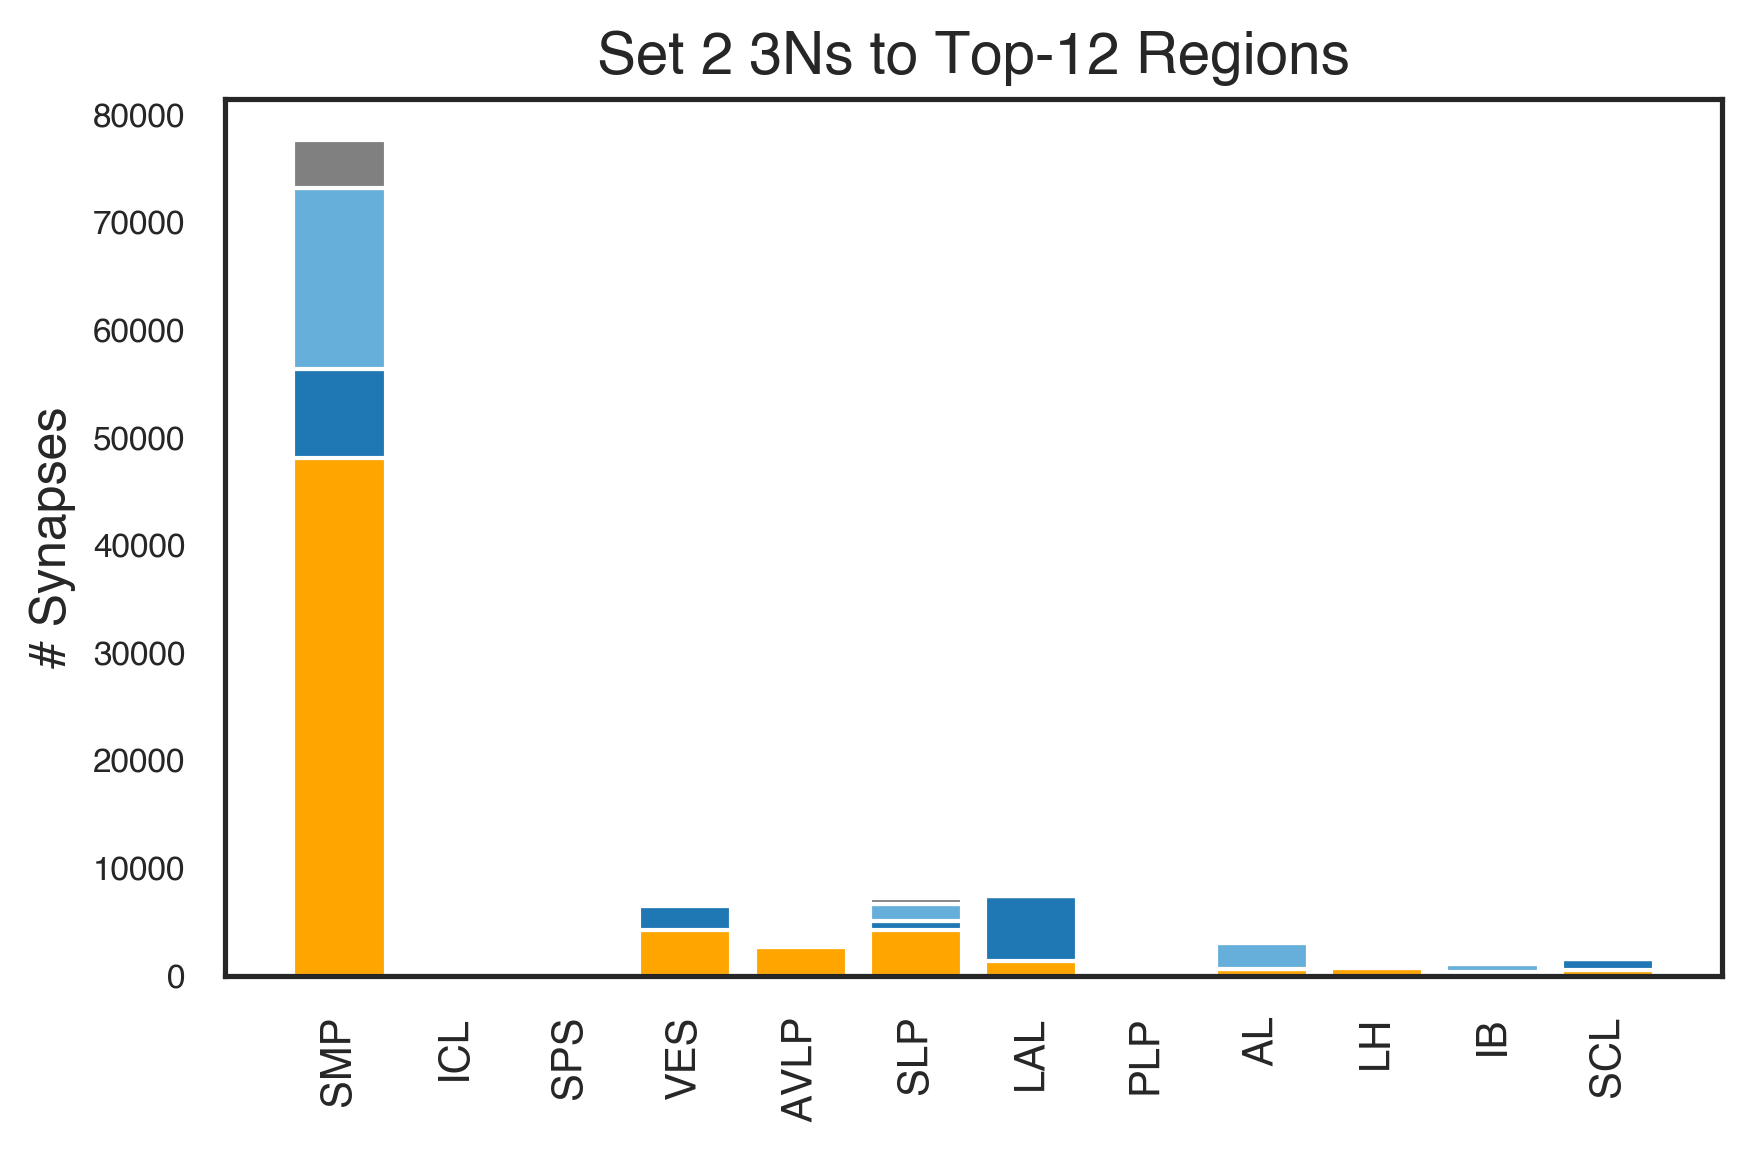

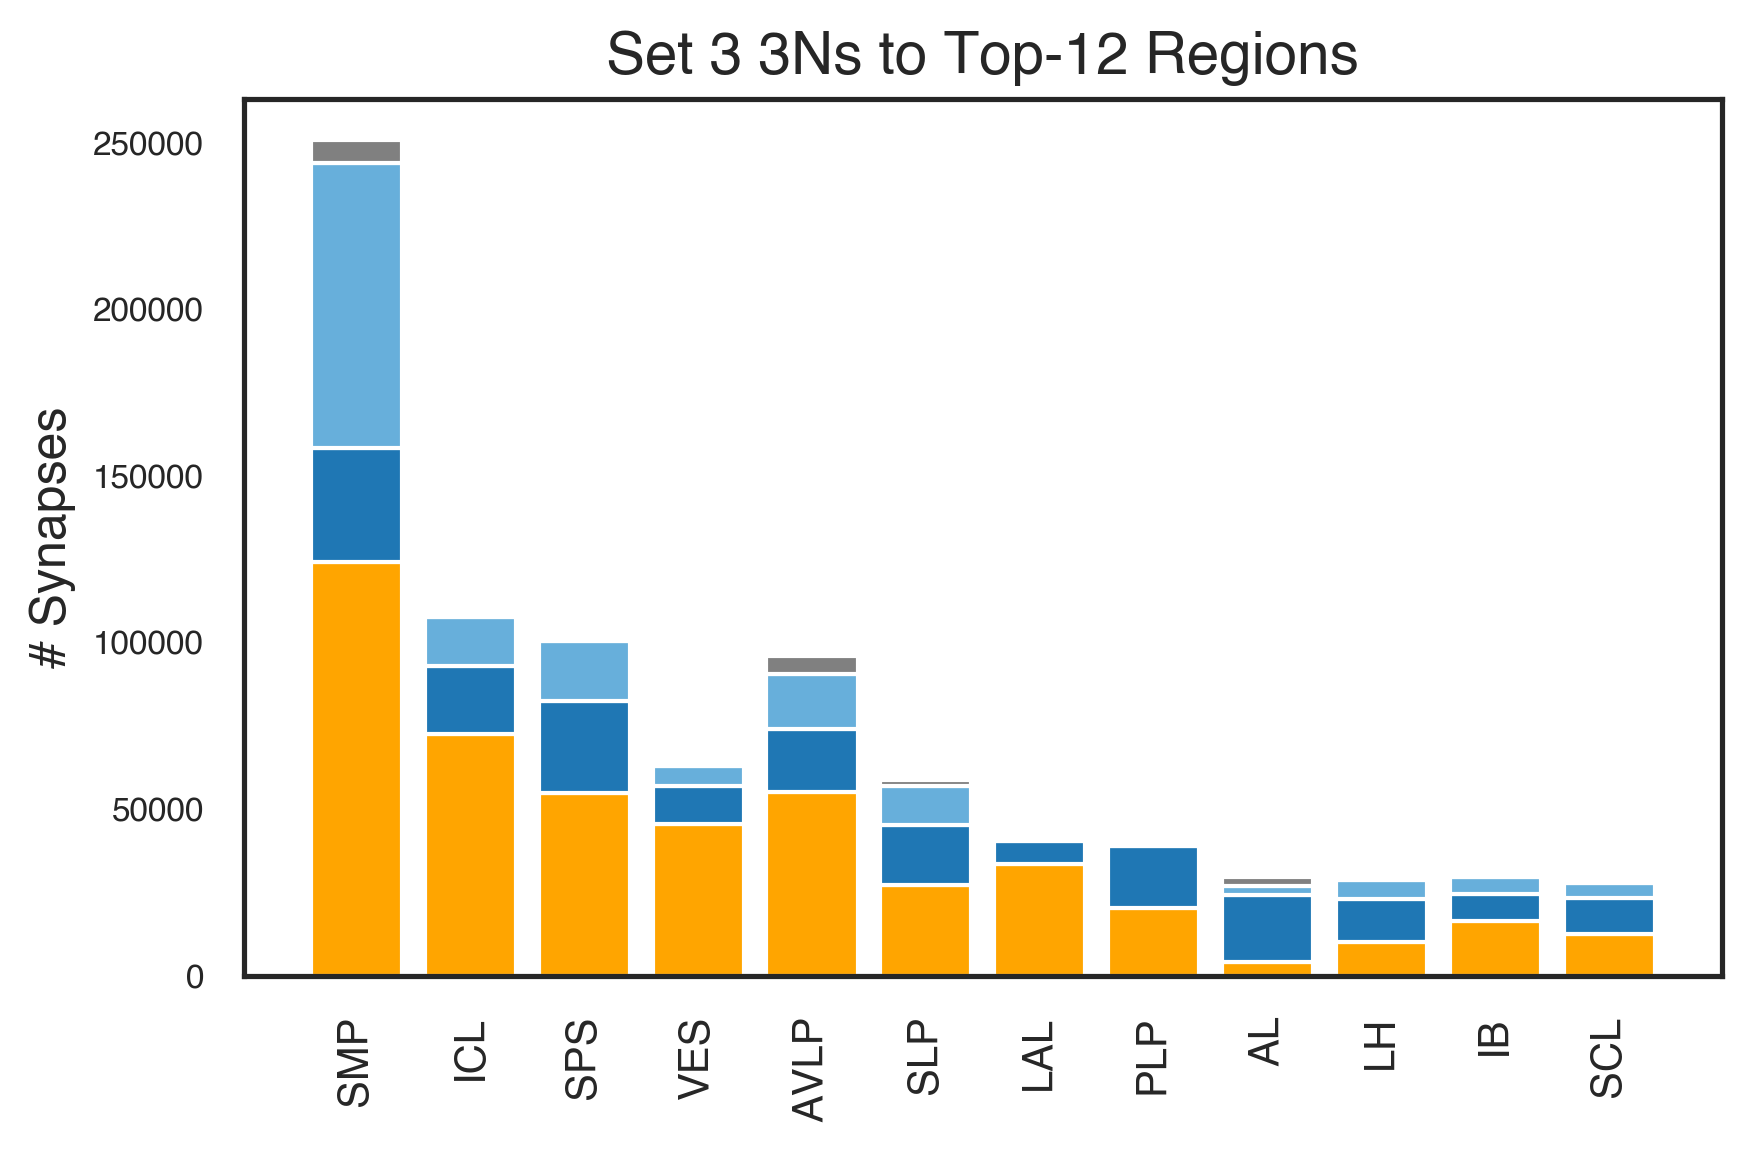

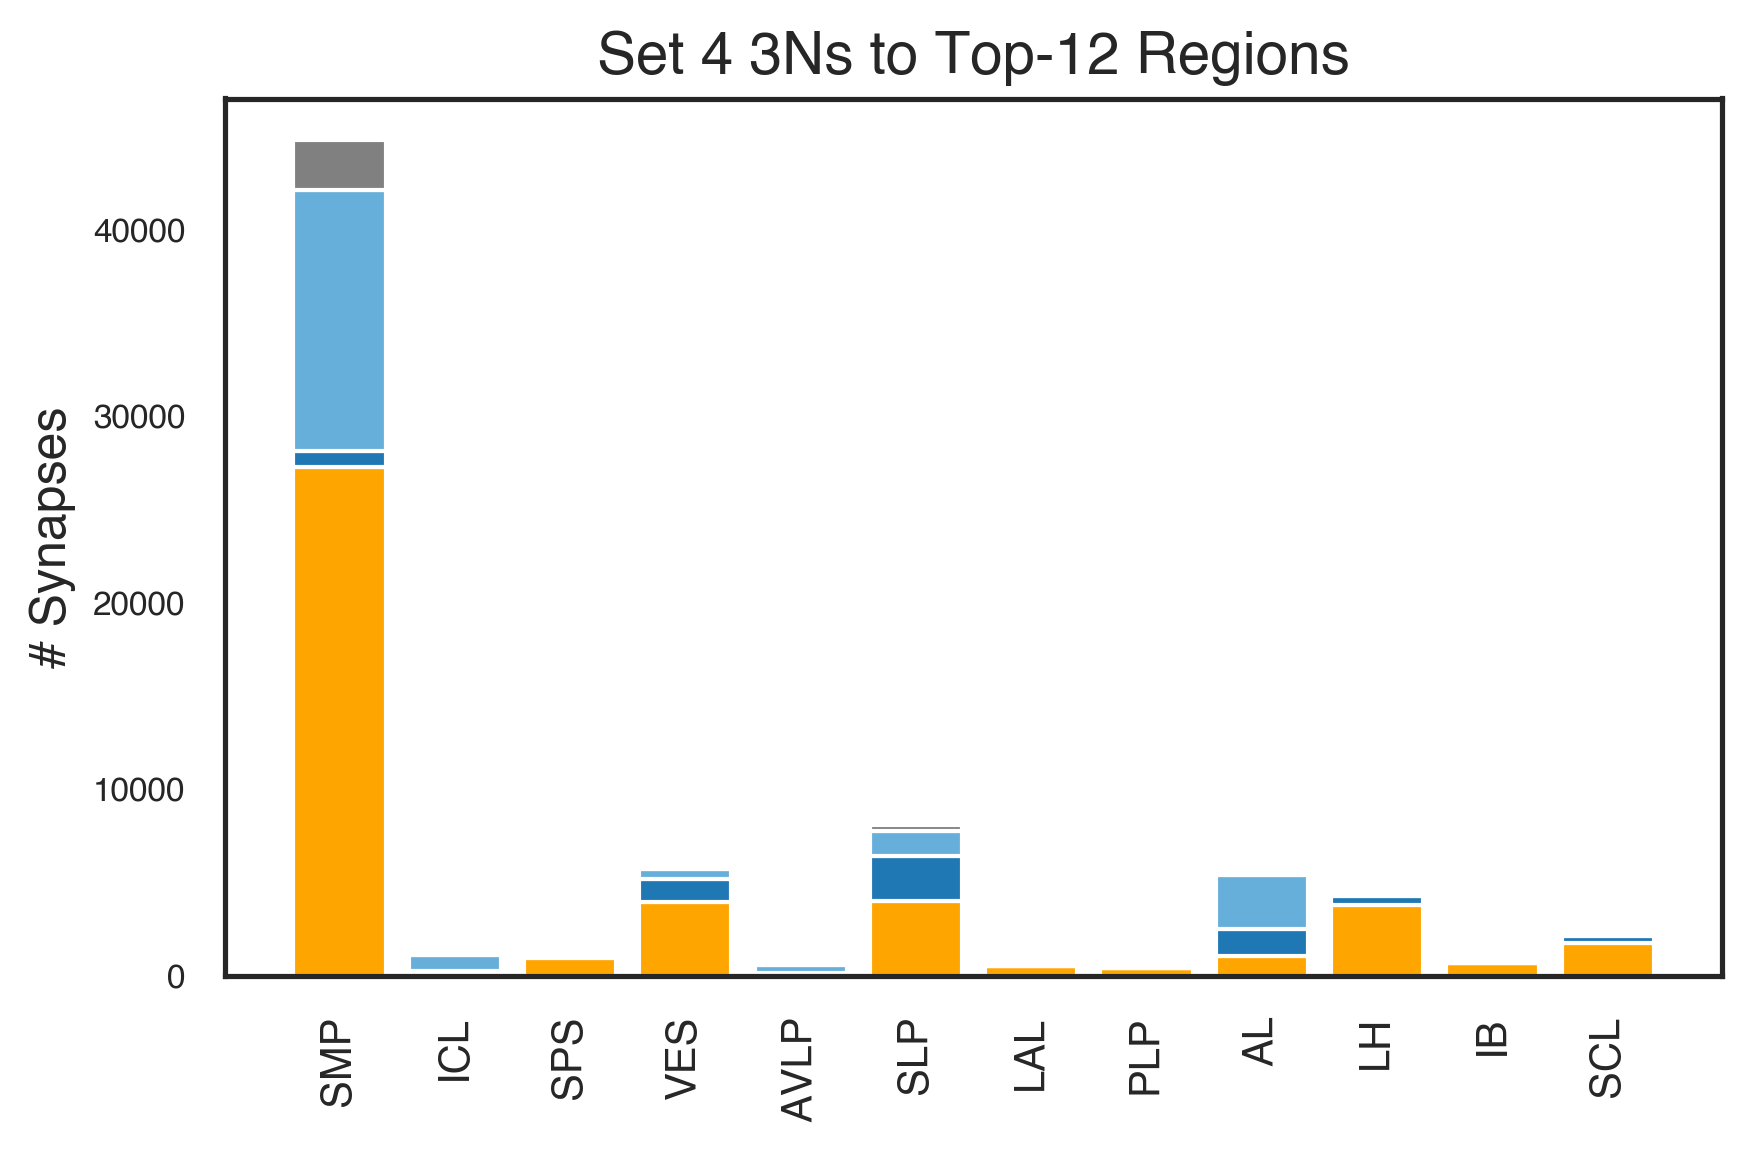

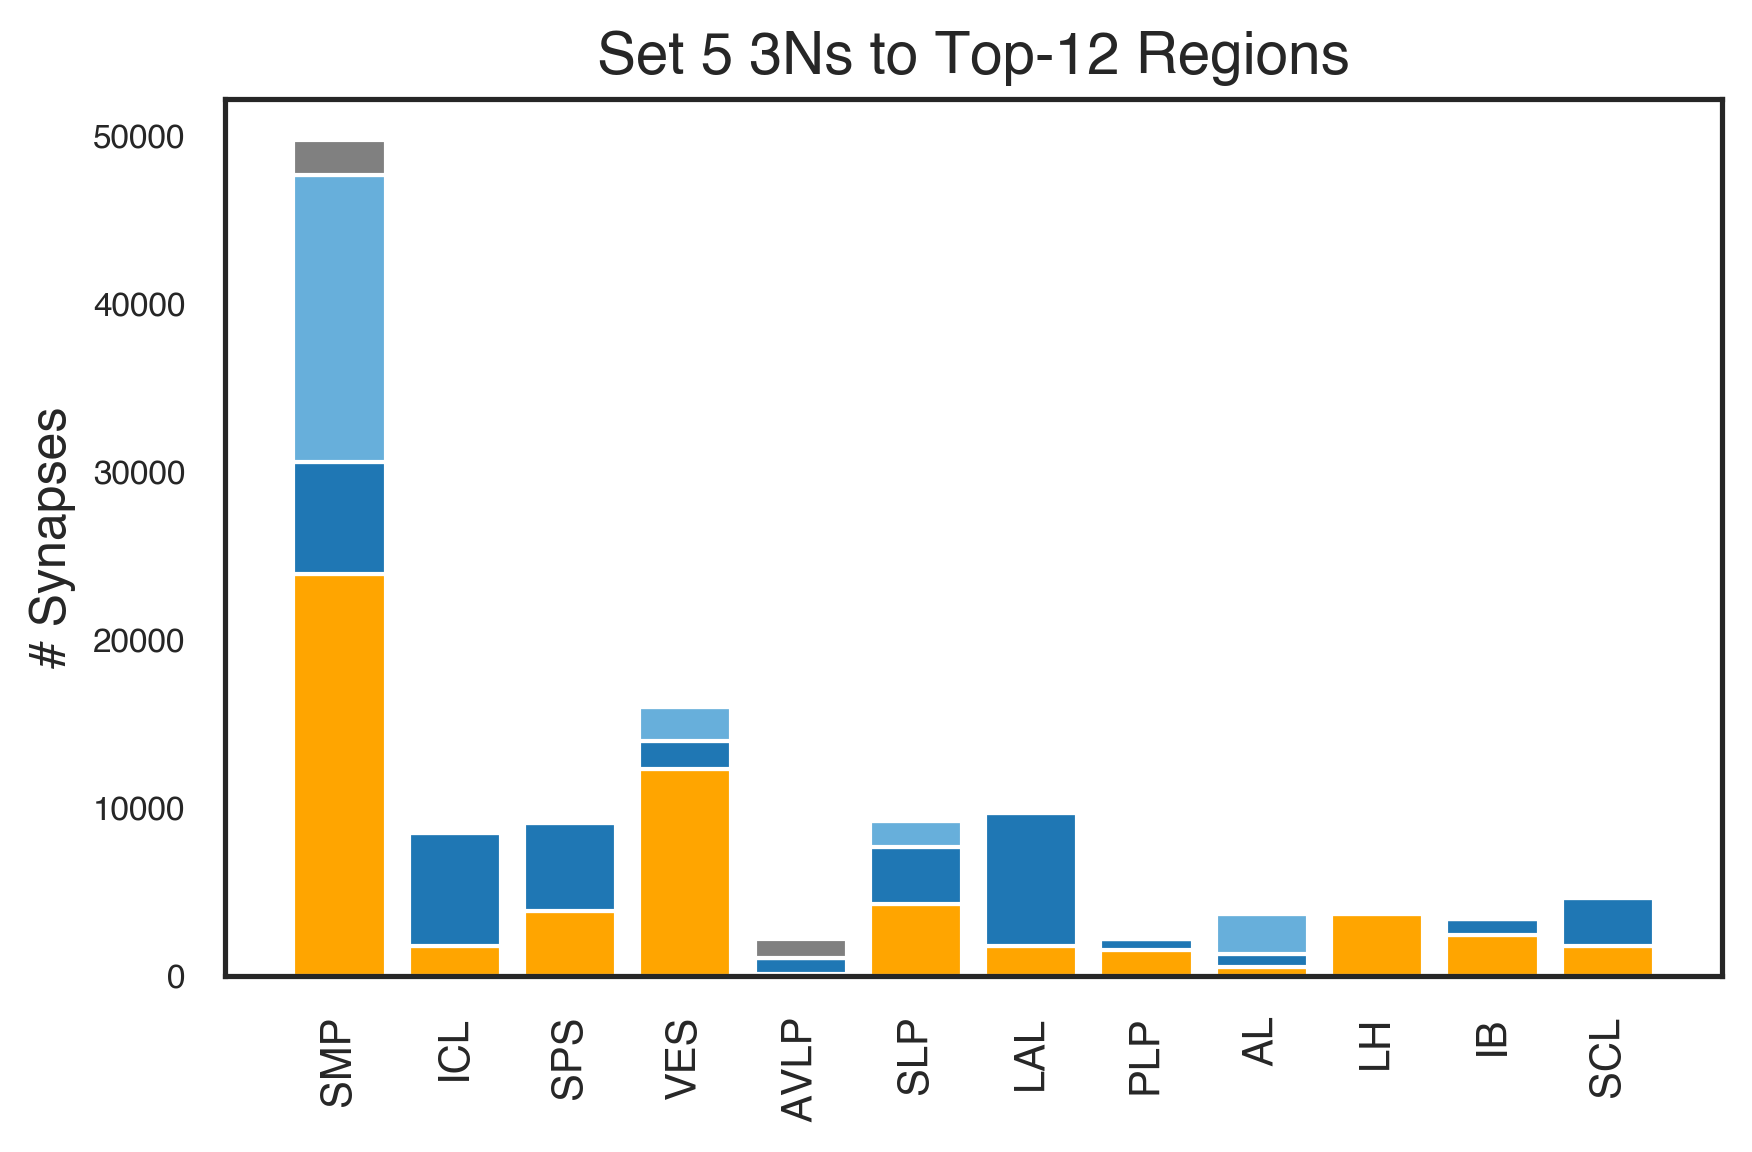

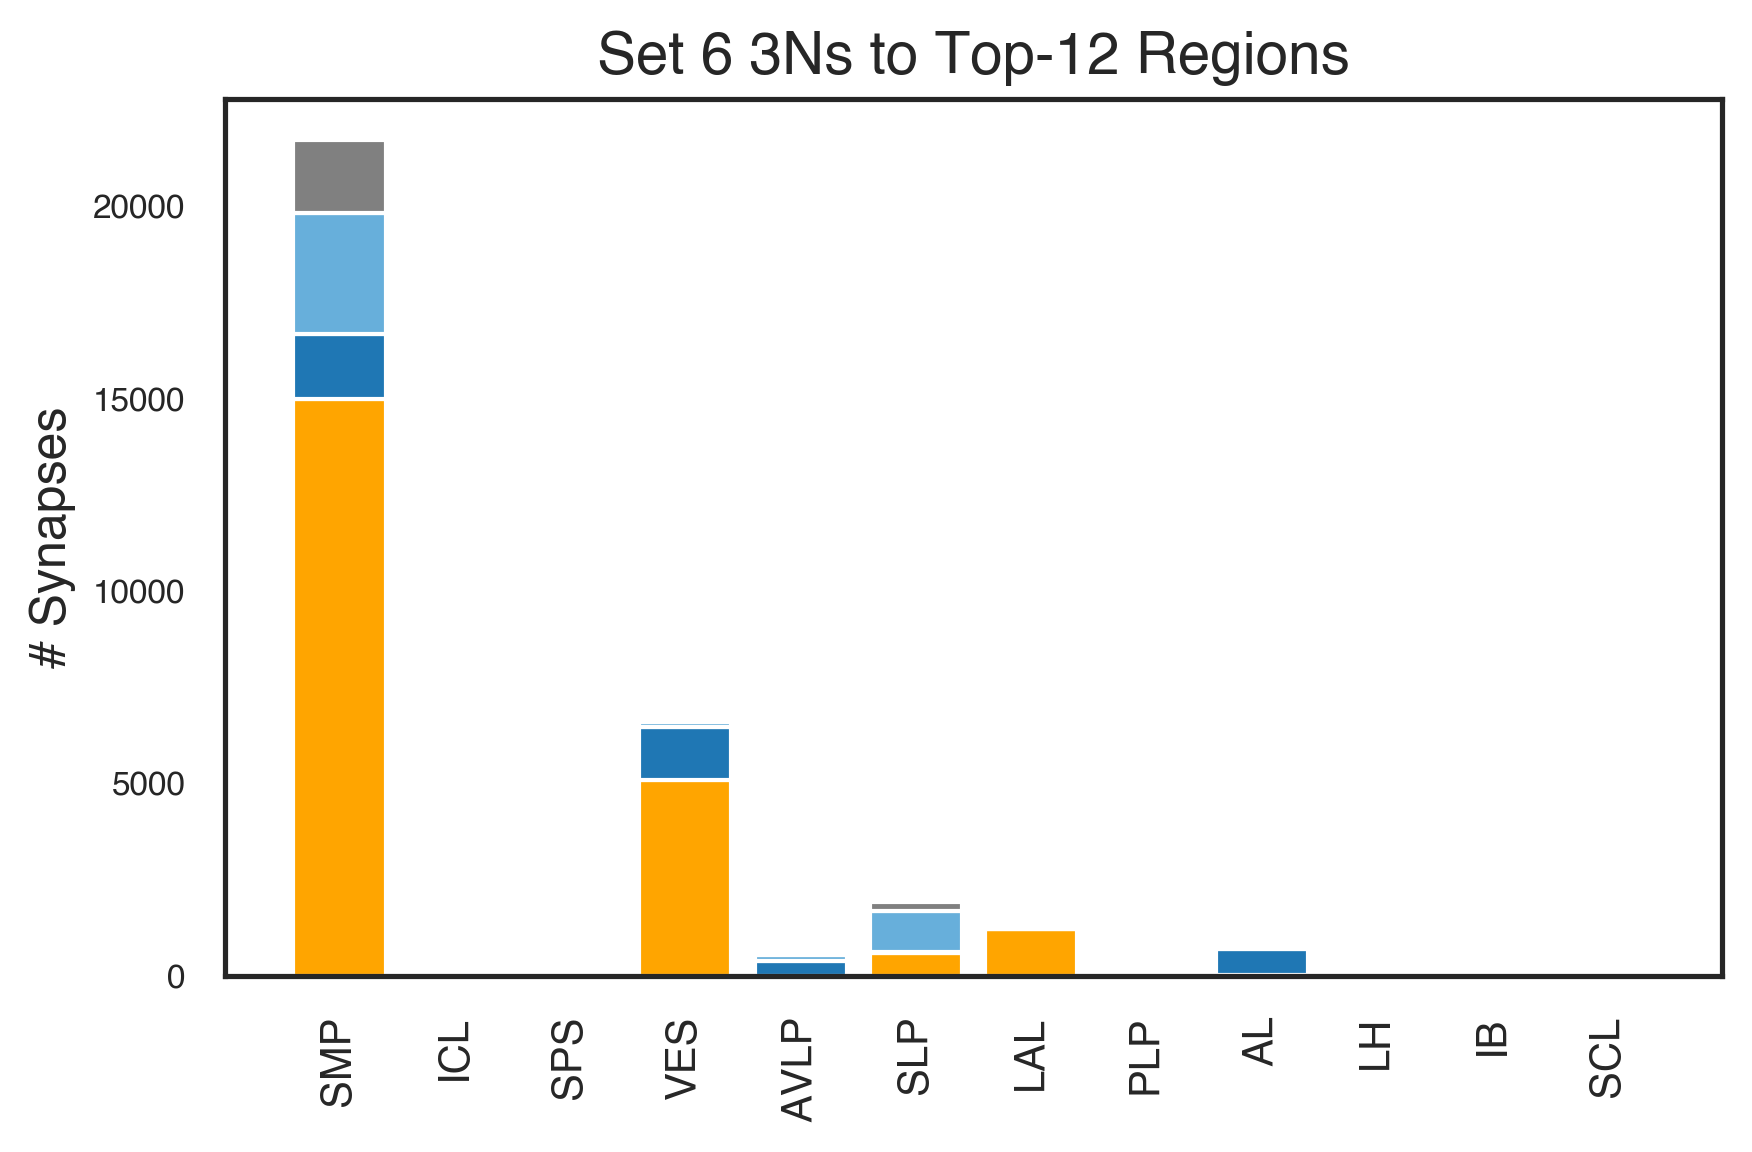

In [109]:
# 5) Plot for each set
for i in range(1, 7):
    df = globals()[f"set_{i}_3N_outputs"]
    # build one sub‐DataFrame per region in global_topN
    region_dfs = [df[df.neuropil_remap == r] for r in global_topN]

    ach, gaba, glut, other = count_NTs_3N_brainregions(region_dfs)
    x      = np.arange(len(global_topN))
    bottom = np.zeros_like(x)

    fig, ax = plt.subplots(figsize=(max(6, len(global_topN)*0.3), 4))
    for nt, vals in zip(['ACH','GABA','GLUT','Other'],
                        [ach, gaba, glut, other]):
        ax.bar(x, vals, width=0.8, bottom=bottom,
               color=color_map[nt], label=nt)
        bottom += vals

    ax.set_xticks(x)
    ax.set_xticklabels(global_topN, rotation=90, fontsize=10)
    ax.set_ylabel('# Synapses', fontsize=12)
    ax.set_title(f"Set {i} 3Ns to Top-{N} Regions", fontsize=14)
    if i == 1:
        ax.legend(title='NT', frameon=False, bbox_to_anchor=(1.02,1), fontsize=9)

    plt.tight_layout()
    plt.show()

Global top-22 non-SEZ regions: ['SMP', 'ICL', 'SPS', 'VES', 'AVLP', 'SLP', 'LAL', 'PLP', 'AL', 'LH', 'IB', 'SCL', 'CRE', 'SIP', 'GOR', 'IPS', 'LO', 'PVLP', 'FB', 'ME', 'WED', 'AOTU']


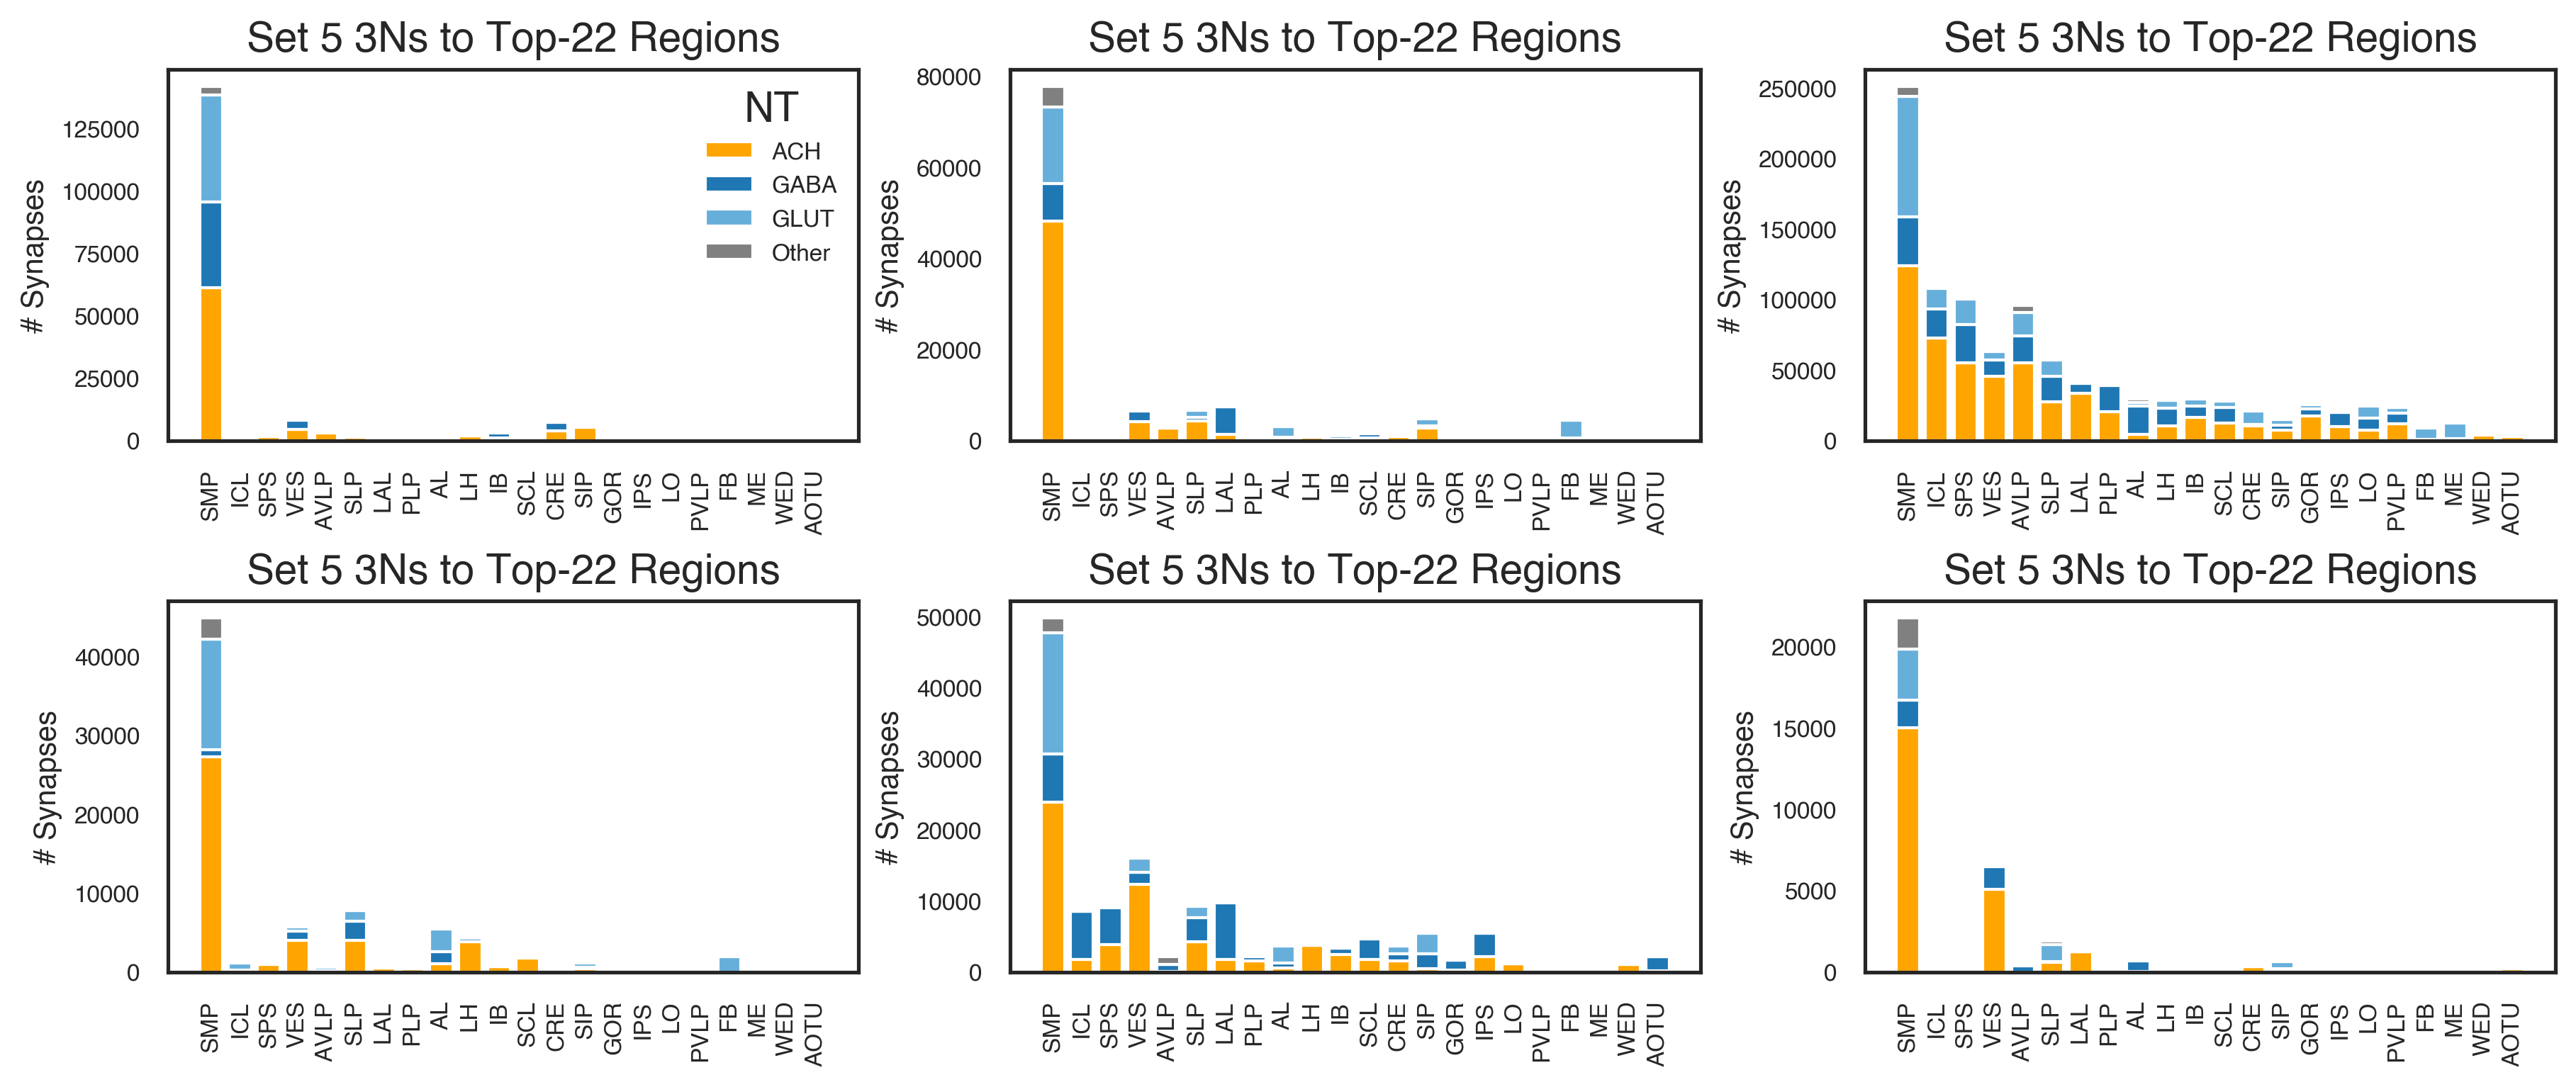

In [122]:
# ─── User controls here ────────────────────────────────────────────────────────
N = 22   # ← change this to 12, 18, 20, 24, 30, etc.
# ────────────────────────────────────────────────────────────────────────────────

import numpy as np
import matplotlib.pyplot as plt

# 1) Pool all six 3N-output tables and remap neuropils
all_3N = pd.concat(
    [globals()[f"set_{i}_3N_outputs"] for i in range(1, 7)],
    ignore_index=True
)
all_3N['neuropil_remap'] = all_3N['neuropil'].map(lambda x: region_mapping.get(x, x))

# 2) Compute the global top-N non-SEZ regions
syn_by_region = (
    all_3N
    .groupby('neuropil_remap')['syn_count']
    .sum()
    .drop(['GNG','PRW','SAD','FLA','CAN'], errors='ignore')
)
top_regions = syn_by_region.nlargest(N).index.tolist()
print(f"Global top-{N} non-SEZ regions:", top_regions)

# 3) Helper to count NT synapses (ACH, GABA, GLUT, Other=DA+SER)
def count_NTs_by_region(region_dfs):
    ach = []; gaba = []; glut = []; other = []
    for df in region_dfs:
        ach.append (df.query("nt_type=='ACH'")['syn_count'].sum())
        gaba.append(df.query("nt_type=='GABA'")['syn_count'].sum())
        glut.append(df.query("nt_type=='GLUT'")['syn_count'].sum())
        other.append(df.query("nt_type in ['DA','SER']")['syn_count'].sum())
    return (np.array(ach), np.array(gaba), np.array(glut), np.array(other))

# 4) Prepare per-set slices
sets_3N = [globals()[f"set_{i}_3N_outputs"] for i in range(1,7)]
labels  = [f"Set {i}" for i in range(1,7)]
# For each set, build a list of DataFrames (one per region in top_regions)
region_slices = [
    [df[df['neuropil_remap'] == r] for r in top_regions]
    for df in sets_3N
]
counts = [count_NTs_by_region(slices) for slices in region_slices]

# 5) Plot on a 2×3 grid
fig, axes = plt.subplots(2, 3,
                         figsize=(max(12, len(top_regions)*0.4), 5),
                         constrained_layout=True)
axes = axes.flatten()
colors = {'ACH':'orange', 'GABA':'#1f77b4', 'GLUT':'#67afdb', 'Other':'gray'}
nt_order = ['ACH','GABA','GLUT','Other']

for ax, label, (ach, gaba, glut, other) in zip(axes, labels, counts):
    x = np.arange(len(top_regions))
    bottom = np.zeros_like(x)
    for nt, vals in zip(nt_order, [ach, gaba, glut, other]):
        ax.bar(x, vals, bottom=bottom, color=colors[nt], label=nt)
        bottom += vals

    ax.set_title(f"Set {i} 3Ns to Top-{N} Regions", fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(top_regions, rotation=90, fontsize=8)
    ax.set_ylabel('# Synapses', fontsize=10)
    #ax.set_title(label, fontsize=12)


# Only show legend on the first subplot
axes[0].legend(title='NT', frameon=False, fontsize=8, loc='upper right')

# Save and show
plt.savefig(f"/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/General - YaoLabUF/SVG_figs/Fig4/All_3Ns_to_top{N}_regions.svg", format='svg', bbox_inches='tight')
plt.show()


In [111]:
# List of 3N‐output tables and labels
sets_3N_outputs = [
    set_1_3N_outputs, set_2_3N_outputs, set_3_3N_outputs,
    set_4_3N_outputs, set_5_3N_outputs, set_6_3N_outputs
]
set_labels = [f"Set {i}" for i in range(1,7)]

# Helper from previous cell:
# def count_NTs_by_region(region_dfs):
#     ach = []; gaba = []; glut = []; other = []
#     for df in region_dfs:
#         ach.append (df.query("nt_type=='ACH'")['syn_count'].sum())
#         gaba.append(df.query("nt_type=='GABA'")['syn_count'].sum())
#         glut.append(df.query("nt_type=='GLUT'")['syn_count'].sum())
#         other.append(df.query("nt_type in ['DA','SER']")['syn_count'].sum())
#     return (np.array(ach), np.array(gaba), np.array(glut), np.array(other))

projection_synapse_capture = {}

for outputs_df, label in zip(sets_3N_outputs, set_labels):
    # 1) Remap neuropils
    df = outputs_df.copy()
    df['neuropil_remap'] = df['neuropil'].map(lambda x: region_mapping.get(x, x))

    # 2) Build one DataFrame per top region
    region_dfs = [df[df['neuropil_remap'] == region] for region in top_regions]

    # 3) Count synapses per NT in those regions
    ach, gaba, glut, other = count_NTs_by_region(region_dfs)
    captured = (ach + gaba + glut + other).sum()

    # 4) Total projection synapses in this set
    total_proj = df.query("location_of_connection=='outside_SEZ'")['syn_count'].sum()

    # 5) Store fraction
    projection_synapse_capture[label] = captured / total_proj

# Display
for label, rate in projection_synapse_capture.items():
    print(f"{label}: {rate:.2%} of projection synapses captured in top-{N} regions")


Set 1: 98.69% of projection synapses captured in top-22 regions
Set 2: 97.86% of projection synapses captured in top-22 regions
Set 3: 97.76% of projection synapses captured in top-22 regions
Set 4: 96.99% of projection synapses captured in top-22 regions
Set 5: 97.48% of projection synapses captured in top-22 regions
Set 6: 99.58% of projection synapses captured in top-22 regions


## 3i. Net excitation onto 3Ns from 2Ns of different modalities

### For 3Ns receiving input from 2Ns of different modalities, analyze whether the sign of that input is correlated.

We will do this by making a scatter plot plotting net excitation from each modality and determining if there is a significant correlation.

Note that 2Ns that receive input from multiple modalities will be counted as 3N inputs for both modalities, so any positive correlations in net excitation from different modalities may partially reflect 2Ns belonging to multiple modalities, as well as correlated inputs from different 2Ns.

## 3j. Analyze recurrent connections from 3Ns to 2Ns or Sets

### Make heatmaps for 3N-2N synapses

Will make 3 plots corresponding to all connections, excitatory connections, and inhibitory connections

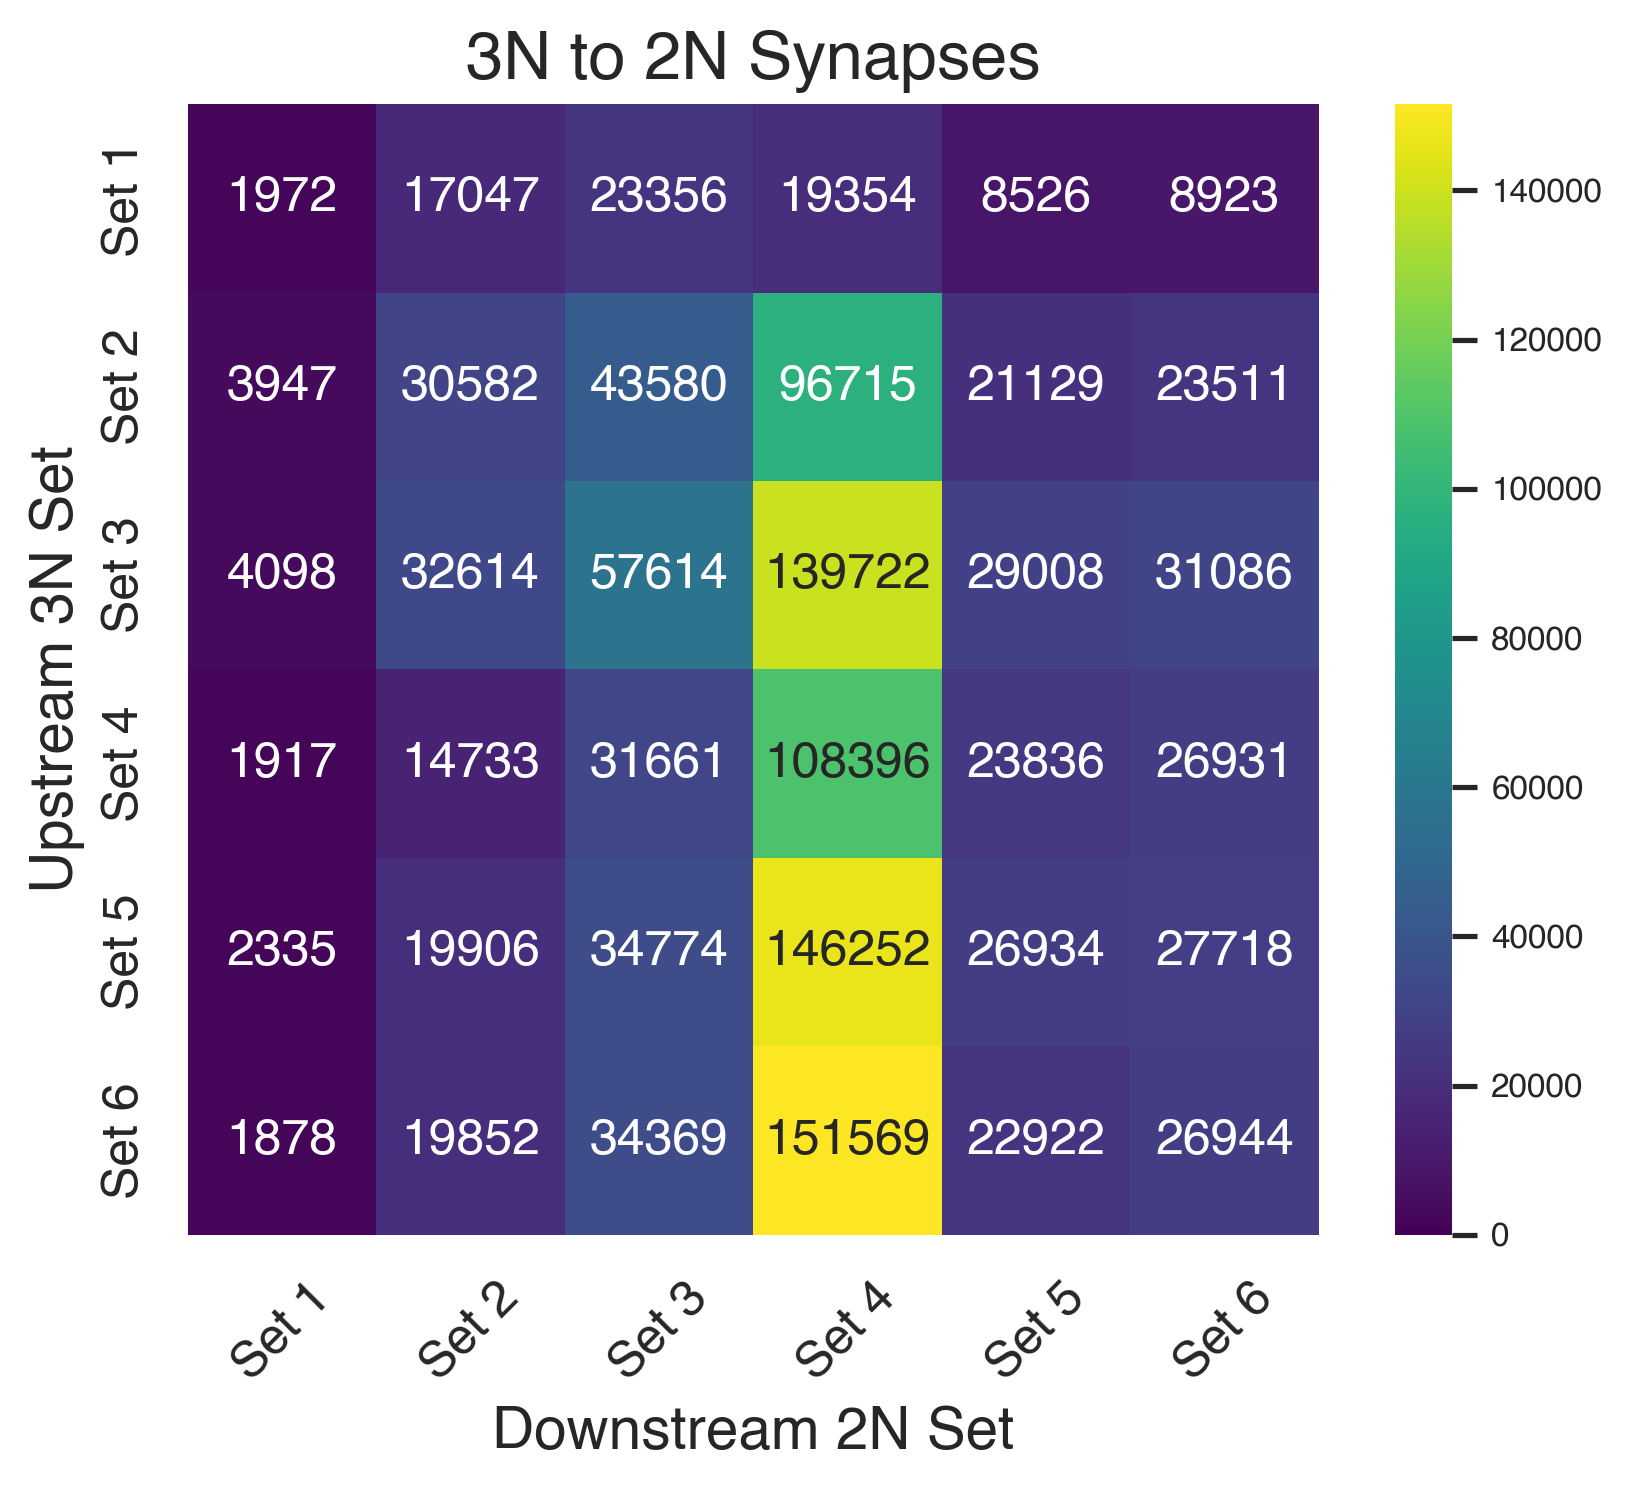

In [112]:
# 1) Collect your six 2N‐ and 3N‐DataFrames by name
twoN_sets = [globals()[f"set_{i}_2Ns"] for i in range(1, 7)]
threeN_outs = [globals()[f"set_{i}_3N_outputs"] for i in range(1, 7)]
labels = [f"Set {i}" for i in range(1, 7)]

# 2) Compute the 6×6 matrix: each row = one 3N‐population’s outputs, each column = synapses onto that 2N‐population
matrix_3N2N = np.array([
    _2N_heatmap(outs, twoN_sets)
    for outs in threeN_outs
])

# 3) Plot the heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(
    matrix_3N2N,
    cmap='viridis',
    annot=True,
    fmt='d',
    xticklabels=labels,
    yticklabels=labels,
    square=True,
    vmin=0
)
plt.title("3N to 2N Synapses", fontsize=16)
plt.ylabel("Upstream 3N Set", fontsize=14)
plt.xlabel("Downstream 2N Set", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


## 4. ANALYZING StN_SA VS. NON-StN_SA INPUTS TO 2Ns AND 3Ns

The goal of these analyses is to determine how much of the input onto 2Ns and 3Ns are StN_SAs inputs versus other types of input, and what those other inputs are.

We will quantify the % of total synaptic input to 2Ns and 3Ns that are StN_SAs inputs, 2N inputs, or any StN_SAinputs (StN_SA, 2N, 3N) considering StN_SAs of any set.

## 4a. 2Ns: Percent input from Sets

Quantify the % of total synaptic input to 2Ns and 3Ns that are StN_SAs inputs, defined as StN_SAs, 2Ns, or 3Ns of any set.

In [113]:
def neuronal_inputs(neurons_of_interest, connections_df, min_syn=5):
    """
    Returns rows from `connections_df` where the postsynaptic neuron is in `neurons_of_interest`
    and the number of synapses is at least `min_syn`.

    Parameters:
    -----------
    neurons_of_interest : pandas.DataFrame
        A DataFrame containing a column 'root_id' that identifies the neurons of interest.
    connections_df : pandas.DataFrame
        A DataFrame with columns ['pre_root_id', 'post_root_id', 'neuropil', 'syn_count', 'nt_type'].
    min_syn : int, optional
        Minimum synapse count required to be included in the output. Default is 5.

    Returns:
    --------
    connectivity : pandas.DataFrame
        A DataFrame containing all connections that meet the minimum synapse threshold.
    """
    # Merge on 'root_id' of the postsynaptic neuron
    connectivity = pd.merge(
        neurons_of_interest[['root_id']],
        connections_df[['pre_root_id', 'post_root_id', 'neuropil', 'syn_count', 'nt_type']],
        left_on='root_id',
        right_on='post_root_id',
        how='inner'
    ).query("syn_count >= @min_syn")

    # Remove the redundant 'root_id' column from neurons_of_interest
    connectivity.drop(columns='root_id', inplace=True)

    return connectivity


In [114]:
# Get inputs for 2Ns of each set
input_2Ns_dfs = []
for i in range(1, 7):
    inputs = neuronal_inputs(globals()[f"set_{i}_2Ns"], connections)
    input_2Ns_dfs.append(inputs)
    globals()[f"set_{i}_2Ns_inputs"] = inputs  # If you want to preserve globals

In [115]:
# Function to calculate the % of inputs coming from any set
def set_input_perc(_2Ns_inputs, _2Ns, input_sets):

    """
    Calculates the percentage of synaptic inputs to each 2N that come from neurons in `input_sets`.

    Parameters:
    -----------
    _2Ns_inputs : pandas.DataFrame
        DataFrame of input synapses for the 2Ns (output from `neuronal_inputs`).
    _2Ns : pandas.DataFrame
        DataFrame containing 2N neurons, must have a 'root_id' column.
    input_sets : list of pandas.DataFrames
        List of DataFrames, each containing a column 'root_id' representing neurons of interest.

    Returns:
    --------
    list
        A list containing the percentage of input from the specified `input_sets` for each 2N.
    """

    # Combine all input sets into a single DataFrame
    all_inputs = pd.concat(input_sets)

    _2Ns_input_perc = []  # Store percent input from input sets

    for i in _2Ns.root_id.values:  # Loop through all 2Ns

        # Get all inputs to each 2N
        df = _2Ns_inputs[_2Ns_inputs['post_root_id'] == i]

        # Get inputs from specified sets
        connectivity_set_2N_i = pd.merge(
            all_inputs[['root_id']],
            df[['pre_root_id', 'post_root_id', 'neuropil', 'syn_count', 'nt_type']],
            left_on='root_id',
            right_on='pre_root_id',
            how='inner'
        ).query("syn_count >= 5")

        # Calculate % of inputs from the specified sets
        if np.sum(df['syn_count'].values) > 0:
            perc = np.sum(connectivity_set_2N_i['syn_count'].values) / np.sum(df['syn_count'].values)
        else:
            perc = 0  # Avoid division by zero

        _2Ns_input_perc.append(perc)

    return _2Ns_input_perc


In [116]:
# Build lists of the 2N and 1N DataFrames for each set
all_sets = [set_1, set_2, set_3, set_4, set_5, set_6]
all_2Ns  = [set_1_2Ns, set_2_2Ns, set_3_2Ns, set_4_2Ns, set_5_2Ns, set_6_2Ns]

# Calculate % input for each set
input_perc_results = []
for i in range(6):
    perc = set_input_perc(input_2Ns_dfs[i], all_2Ns[i], all_sets)
    input_perc_results.append(perc)
    print(f"Set {i+1}: Mean input % from any set = {np.mean(perc):.2%}")

Set 1: Mean input % from any set = 12.11%
Set 2: Mean input % from any set = 16.84%
Set 3: Mean input % from any set = 10.26%
Set 4: Mean input % from any set = 3.63%
Set 5: Mean input % from any set = 9.51%
Set 6: Mean input % from any set = 14.15%


### Categorize input neuron classes

### Export lists of specific types of input to visualize in Flywire

# Extract and save mechanosensory, AN, and DN inputs for each set
#for i, set_input_classified in enumerate([set_1_2N_input_classified, set_2_2N_input_classified,
                                          set_3_2N_input_classified, set_4_2N_input_classified,
                                          set_5_2N_input_classified, set_6_2N_input_classified], start=1):
    mechano_input = set_input_classified.loc[set_input_classified['class'] == 'mechanosensory']
    mechano_input.to_csv(f'set_{i}_2N_mechano_input.csv')

    AN_input = set_input_classified.loc[set_input_classified['class'] == 'AN']
    AN_input.to_csv(f'set_{i}_2N_AN_input.csv')

    DN_input = set_input_classified.loc[set_input_classified['class'] == 'DN']
    DN_input.to_csv(f'set_{i}_2N_DN_input.csv')

# Extract and save ALPN, LHLN, MBON, and mAL inputs for each set
#for i, set_input_classified in enumerate([set_1_3N_input_classified, set_2_3N_input_classified,
                                          set_3_3N_input_classified, set_4_3N_input_classified,
                                          set_5_3N_input_classified, set_6_3N_input_classified], start=1):
    ALPN_input = set_input_classified.loc[set_input_classified['class'] == 'ALPN']
    ALPN_input.to_csv(f'set_{i}_3N_ALPN_input.csv')

    LHLN_input = set_input_classified.loc[set_input_classified['class'] == 'LHLN']
    LHLN_input.to_csv(f'set_{i}_3N_LHLN_input.csv')

    MBON_input = set_input_classified.loc[set_input_classified['class'] == 'MBON']
    MBON_input.to_csv(f'set_{i}_3N_MBON_input.csv')

    mAL_input = set_input_classified.loc[set_input_classified['class'] == 'mAL']
    mAL_input.to_csv(f'set_{i}_3N_mAL_input.csv')

################ End of walkers scripts/workflow

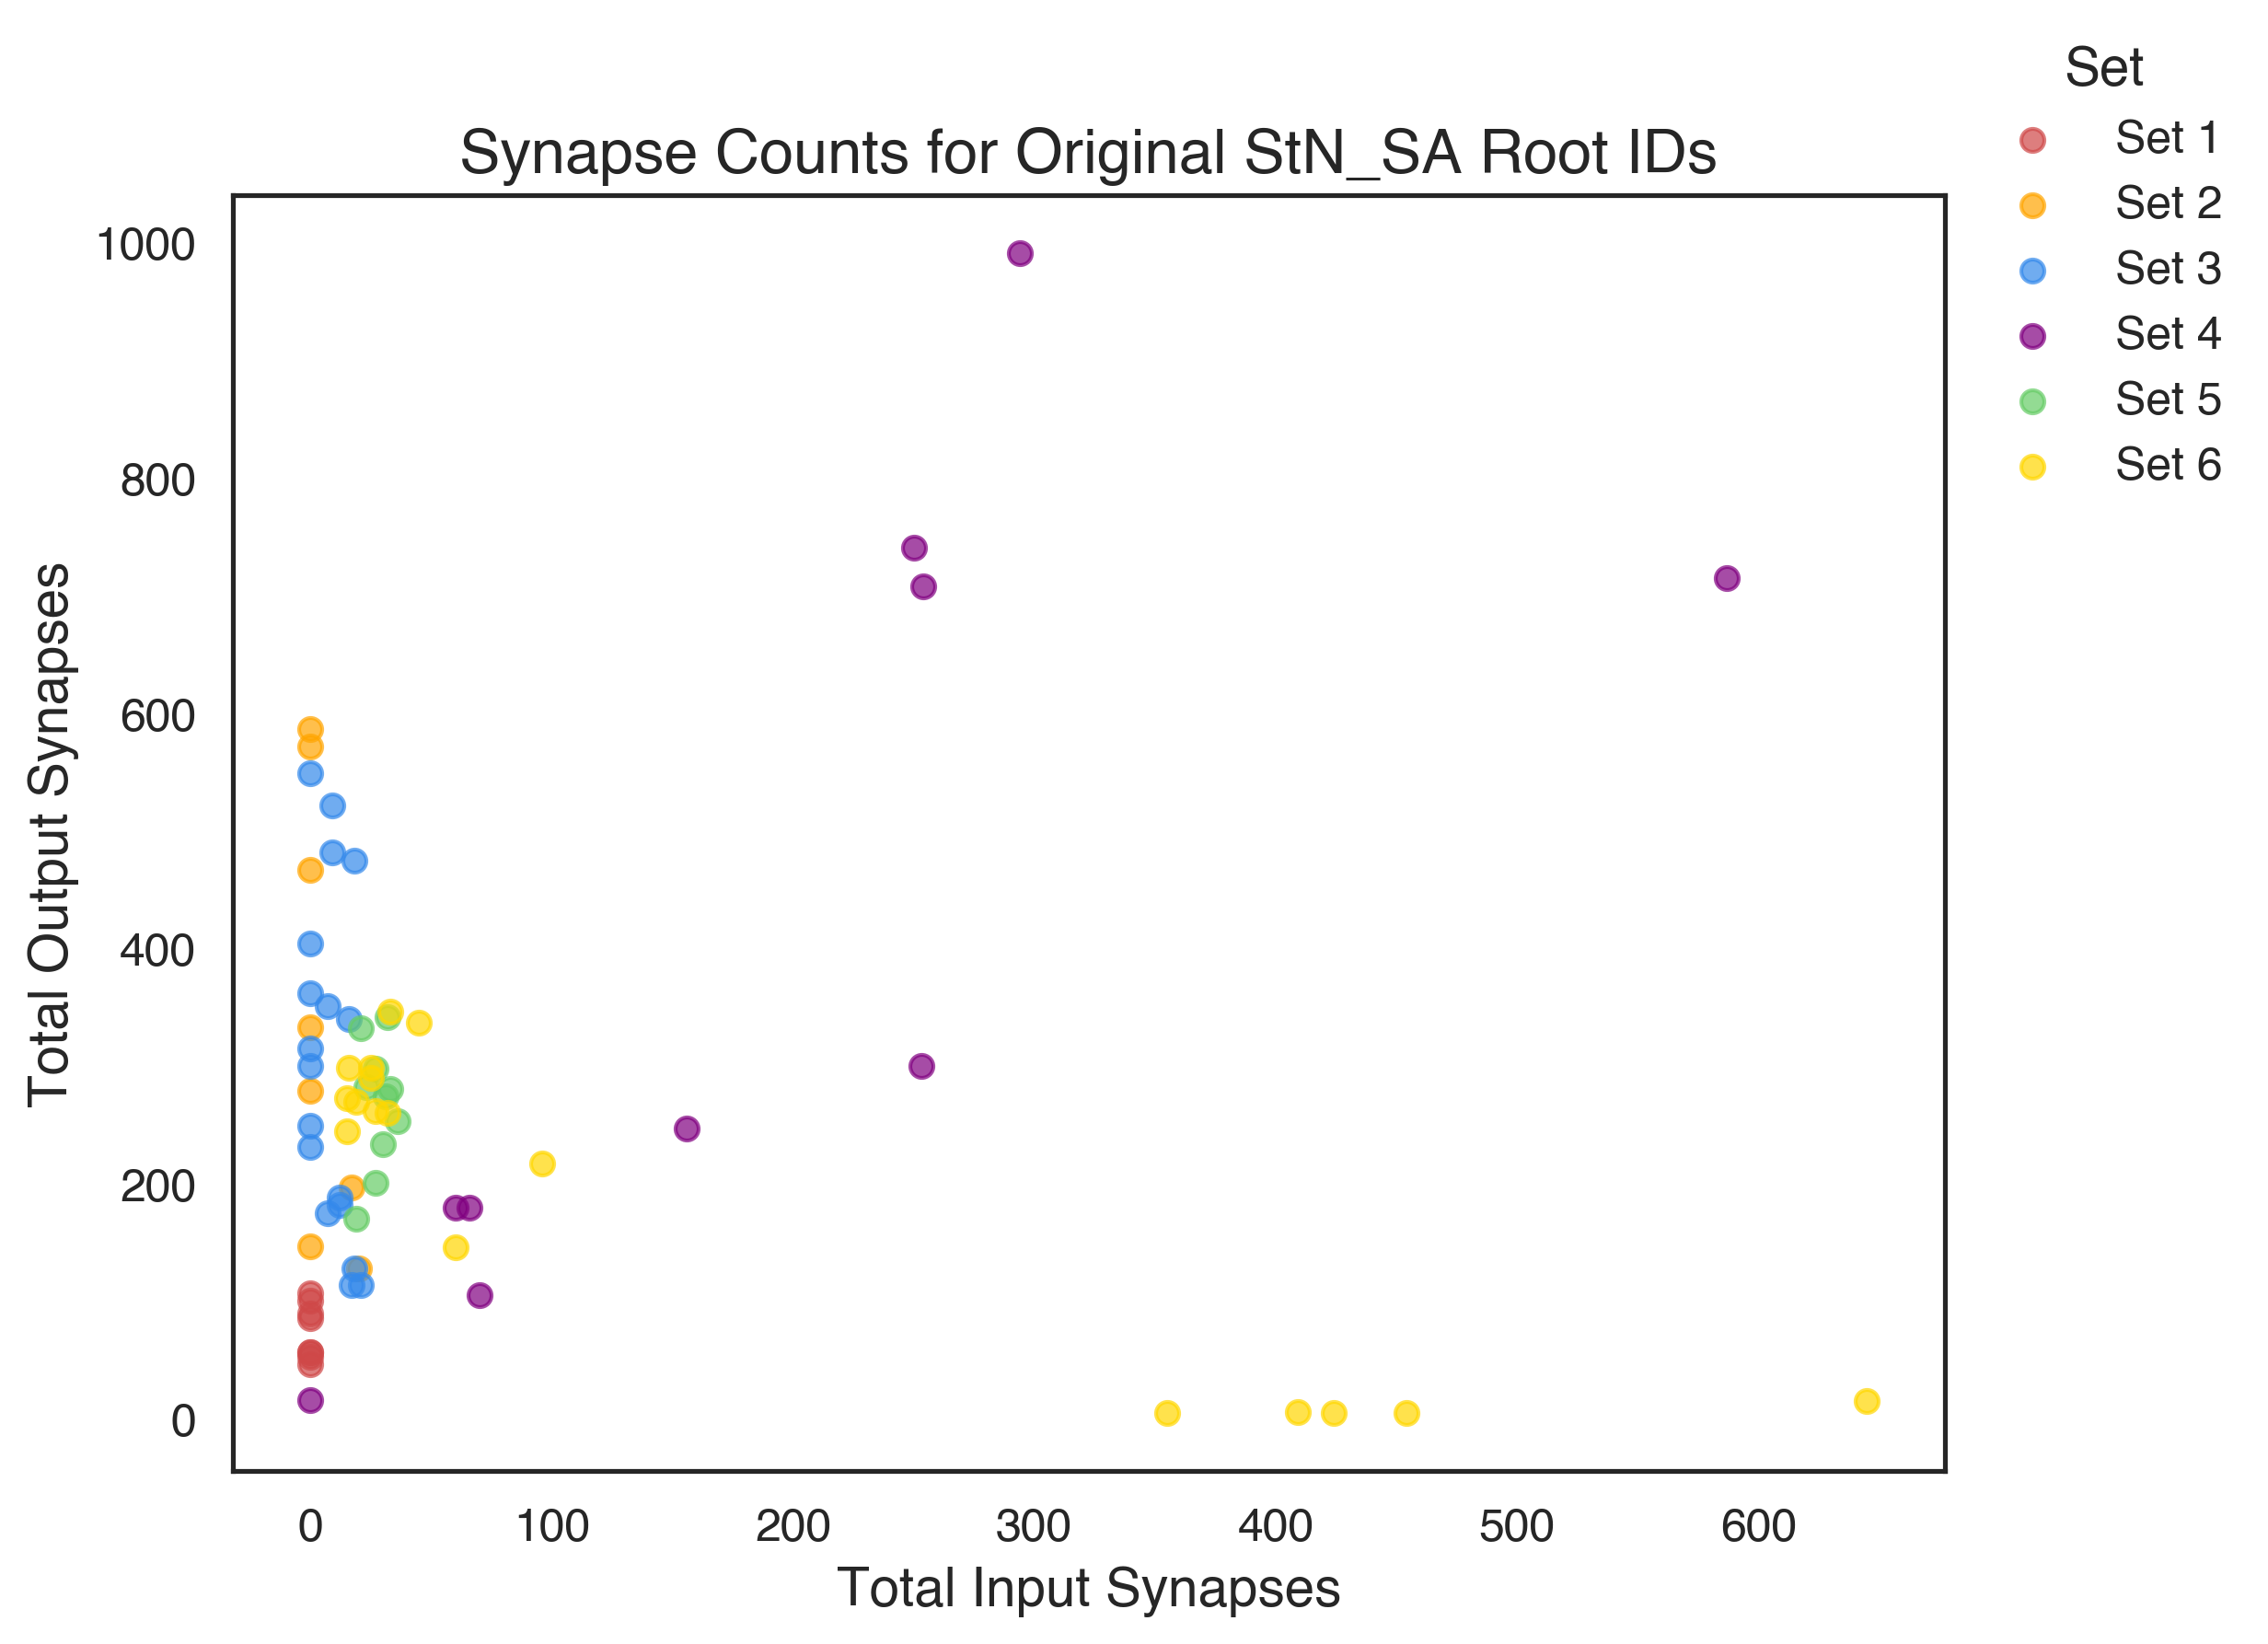

In [117]:
# set that do not meet the >= 5 output synapses to x root id. set_x = [ 720575940625471896 720575940610897906 720575940634755041 720575940635501560 720575940645524003 720575940604782624 720575940641265549 720575940619316603 ]



def get_synapse_counts_for_set(set_df):
    """
    For a given set (which contains a column 'root_id'), aggregate the connections
    (with syn_count>=5) to compute total output and input synapses.
    Output synapses are computed from connections where the neuron appears as the presynaptic cell (pre_root_id),
    and input synapses where it appears as the postsynaptic cell (post_root_id).
    """
    # Filter connections to only include those with syn_count >= 5
    conn = connections.query("syn_count >= 0")

    # Aggregate output synapses (using pre_root_id)
    outputs = conn.groupby("pre_root_id")["syn_count"].sum().reset_index()
    outputs.rename(columns={"pre_root_id": "root_id", "syn_count": "output_synapses"}, inplace=True)

    # Aggregate input synapses (using post_root_id)
    inputs = conn.groupby("post_root_id")["syn_count"].sum().reset_index()
    inputs.rename(columns={"post_root_id": "root_id", "syn_count": "input_synapses"}, inplace=True)

    # Merge with the set (which contains the original root_ids)
    syn_df = pd.merge(set_df[['root_id']], outputs, on="root_id", how="left")
    syn_df = pd.merge(syn_df, inputs, on="root_id", how="left")

    # Fill missing values with 0
    syn_df.fillna(0, inplace=True)
    return syn_df

# Assume your original sets have been loaded as set_1, set_2, ..., set_6
sets = [set_1, set_2, set_3, set_4, set_5, set_6]
set_labels = ['Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5', 'Set 6']

# Define a list of colors for each set (adjust as desired)
colors = ['#cf4848', 'orange', '#3489eb', 'purple', '#66cc66', 'gold']

plt.figure(figsize=(8,6))
for set_df, label, color in zip(sets, set_labels, colors):
    # Get input/output synapse counts for the neurons in this set.
    syn_df = get_synapse_counts_for_set(set_df)
    plt.scatter(syn_df['input_synapses'], syn_df['output_synapses'],
                label=label, color=color, alpha=0.7)

plt.xlabel('Total Input Synapses', fontsize=14)
plt.ylabel('Total Output Synapses', fontsize=14)
plt.title('Synapse Counts for Original StN_SA Root IDs', fontsize=16)
plt.legend(title='Set', loc='upper left', bbox_to_anchor=(1, 1.15), frameon=False, fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


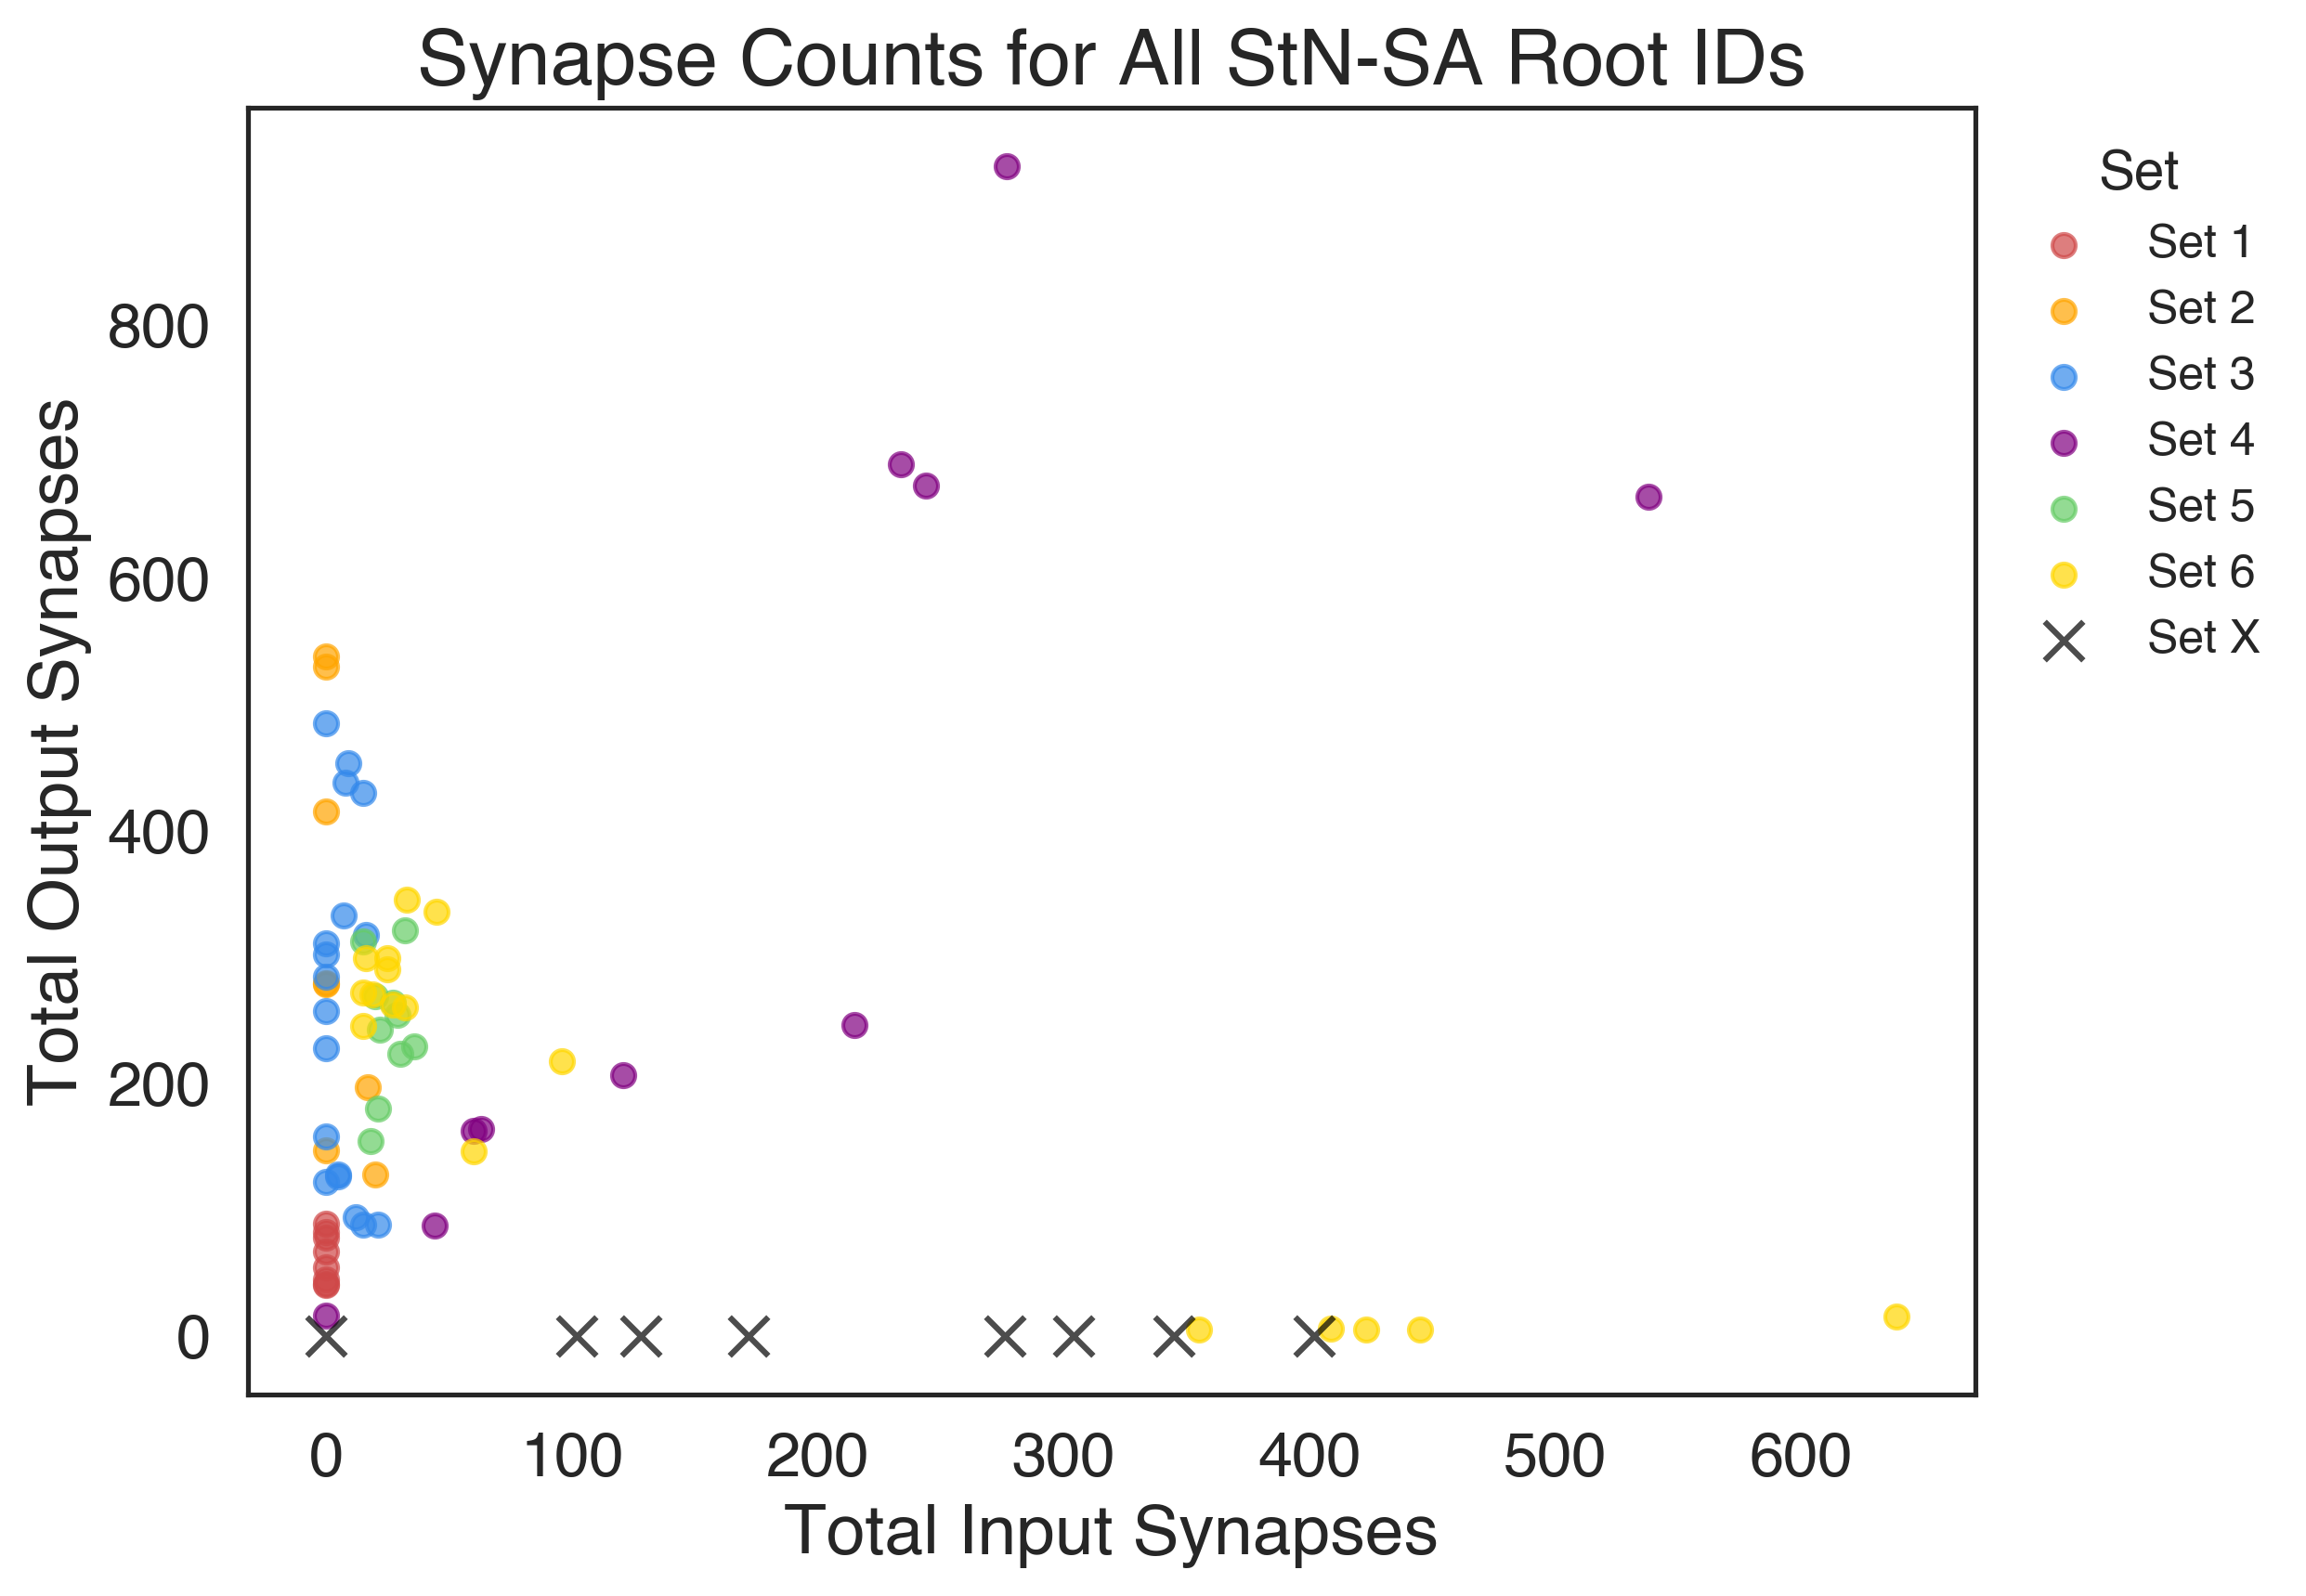

In [118]:
# set that do not meet the >= 5 output synapses threshold
set_x = pd.DataFrame({
    'root_id': [
        720575940625471896,
        720575940610897906,
        720575940634755041,
        720575940635501560,
        720575940645524003,
        720575940604782624,
        720575940641265549,
        720575940619316603
    ]
})

def get_synapse_counts_for_set(set_df):
    """
    For a given set (which contains a column 'root_id'), aggregate the connections
    (with syn_count>=5) to compute total output and input synapses.
    Output synapses are computed from connections where the neuron appears as the presynaptic cell (pre_root_id),
    and input synapses where it appears as the postsynaptic cell (post_root_id).
    """
    # Filter connections to only include those with syn_count >= 5
    conn = connections.query("syn_count >= 5")

    # Aggregate output synapses (using pre_root_id)
    outputs = conn.groupby("pre_root_id")["syn_count"].sum().reset_index()
    outputs.rename(columns={"pre_root_id": "root_id", "syn_count": "output_synapses"}, inplace=True)

    # Aggregate input synapses (using post_root_id)
    inputs = conn.groupby("post_root_id")["syn_count"].sum().reset_index()
    inputs.rename(columns={"post_root_id": "root_id", "syn_count": "input_synapses"}, inplace=True)

    # Merge with the set (which contains the original root_ids)
    syn_df = pd.merge(set_df[['root_id']], outputs, on="root_id", how="left")
    syn_df = pd.merge(syn_df, inputs, on="root_id", how="left")

    # Fill missing values with 0
    syn_df.fillna(0, inplace=True)
    return syn_df

# Assume your original sets have been loaded as set_1, set_2, ..., set_6
sets = [set_1, set_2, set_3, set_4, set_5, set_6]
set_labels = ['Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5', 'Set 6']

# Define a list of colors for each set (adjust as desired)
colors = ['#cf4848', 'orange', '#3489eb', 'purple', '#66cc66', 'gold']

plt.figure(figsize=(8,6))
# Plot each of the original sets
for set_df, label, color in zip(sets, set_labels, colors):
    syn_df = get_synapse_counts_for_set(set_df)
    plt.scatter(syn_df['input_synapses'], syn_df['output_synapses'],
                label=label, color=color, alpha=0.7)

# Now incorporate set_x into the same plot
syn_df_x = get_synapse_counts_for_set(set_x)
plt.scatter(syn_df_x['input_synapses'], syn_df_x['output_synapses'],
            label='Set X', color='black', marker='x', s=100, alpha=0.7)

plt.xlabel('Total Input Synapses', fontsize=18)
plt.ylabel('Total Output Synapses', fontsize=18)
plt.title('Synapse Counts for All StN-SA Root IDs', fontsize=20)
plt.legend(title='Set', loc='upper left', bbox_to_anchor=(1, 1), frameon=False, fontsize=12)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/General - YaoLabUF/SVG_figs/Fig2/syncount1n.svg', format='svg', bbox_inches='tight')
plt.show()


that did not work. here is what i think we need to do. we need to plot the first and second axis. and download the data for that. once we do that we need to get the data for the connections from the second order neurons to the third order neurons. we then need to alter the names of the superclasses of the third order neurons. we need to call them for example central' that is central prime instead of central. then i think we will plot successfully because superclass names wont be confused.

In [119]:
# Step 1: Concatenate with a new column called 'set_label'
combined_2Ns = pd.concat([
    set_1_2Ns.assign(set_label='set_1'),
    set_2_2Ns.assign(set_label='set_2'),
    set_3_2Ns.assign(set_label='set_3'),
    set_4_2Ns.assign(set_label='set_4'),
    set_5_2Ns.assign(set_label='set_5'),
    set_6_2Ns.assign(set_label='set_6')
])

# Step 2: Aggregate set memberships into a list and rename the aggregated column to 'membership'
membership = combined_2Ns.groupby('root_id')['set_label'].apply(lambda x: list(x.unique())).reset_index().rename(columns={'set_label': 'membership'})

# Step 3: Merge the unique neurons with the membership information
unique_2Ns = combined_2Ns.drop_duplicates(subset='root_id').merge(membership, on='root_id')

# Step 4: Create a new column counting the number of sets for each neuron
unique_2Ns['membership_count'] = unique_2Ns['membership'].apply(len)


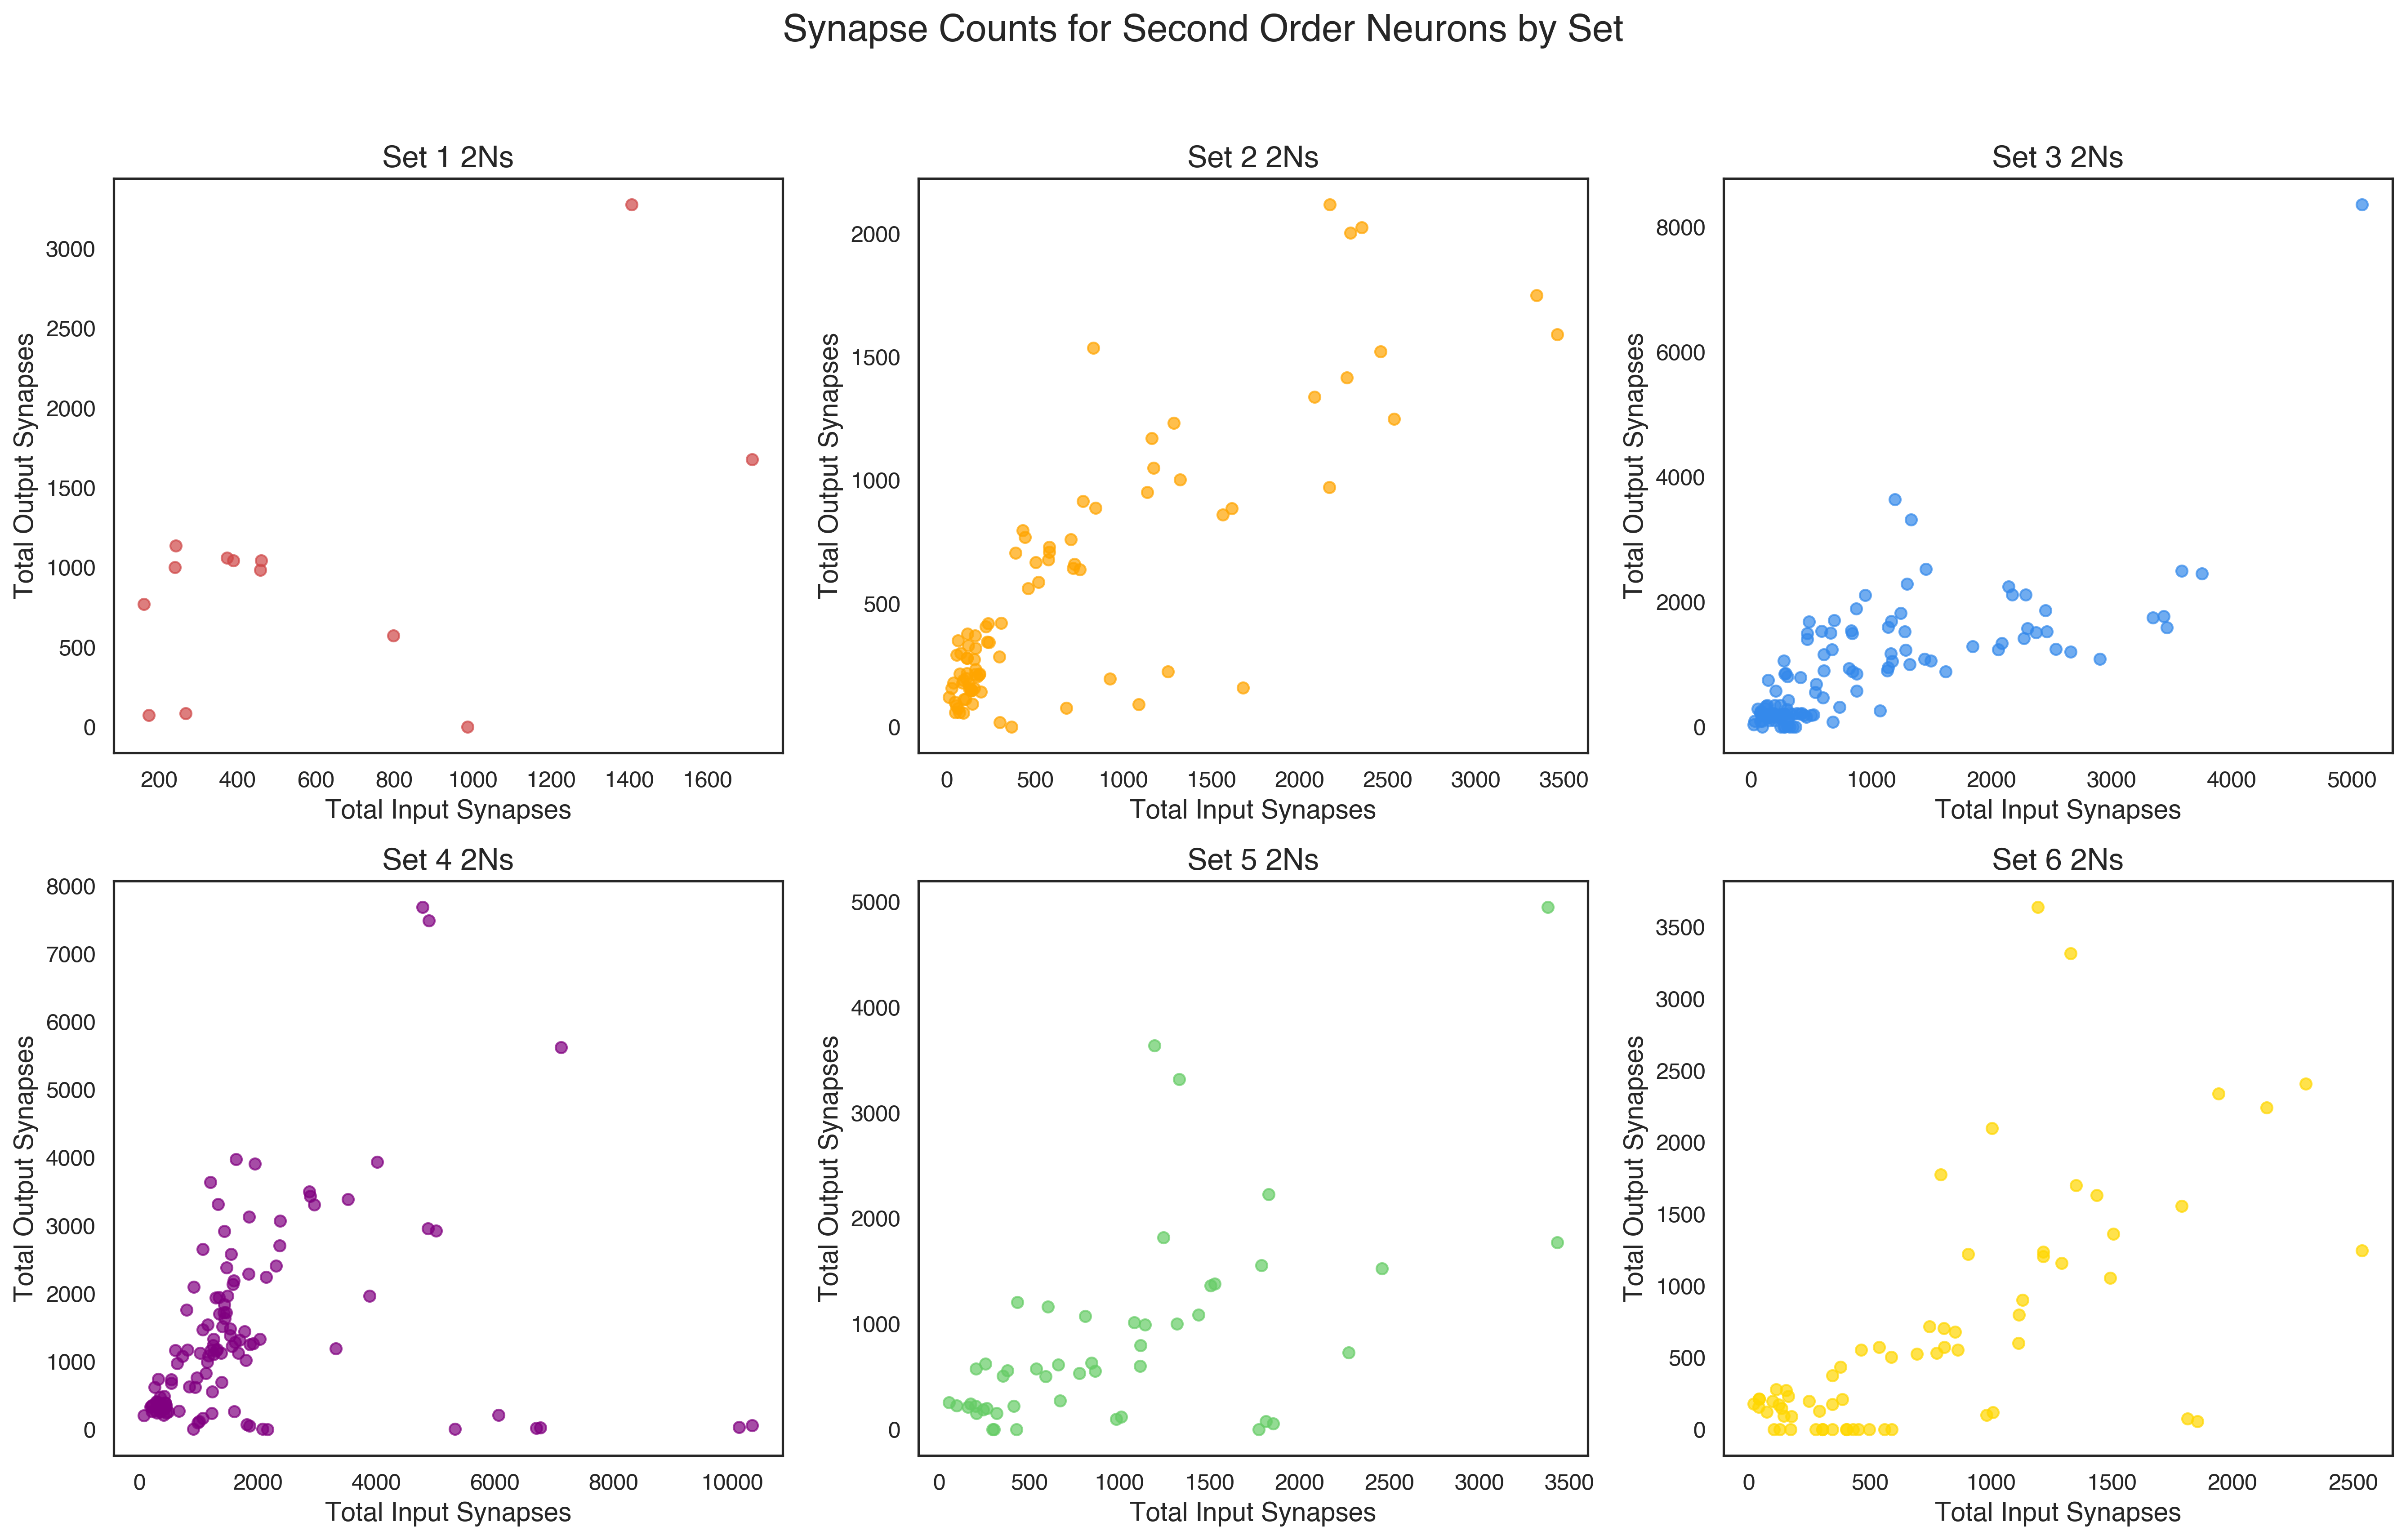

In [120]:


# List of second order neuron DataFrames and corresponding labels
sets_2Ns = [set_1_2Ns, set_2_2Ns, set_3_2Ns, set_4_2Ns, set_5_2Ns, set_6_2Ns]
labels_2Ns = ['Set 1 2Ns', 'Set 2 2Ns', 'Set 3 2Ns', 'Set 4 2Ns', 'Set 5 2Ns', 'Set 6 2Ns']
colors = ['#cf4848', 'orange', '#3489eb', 'purple', '#66cc66', 'gold']

# Create a 2x3 subplot grid
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
axs = axs.flatten()  # Flatten the array for easy iteration

# Loop over each set and its corresponding subplot axis
for ax, df, label, color in zip(axs, sets_2Ns, labels_2Ns, colors):
    ax.scatter(df['input_synapses'], df['output_synapses'], label=label, color=color, alpha=0.7)
    ax.set_xlabel('Total Input Synapses', fontsize=14)
    ax.set_ylabel('Total Output Synapses', fontsize=14)
    ax.set_title(label, fontsize=16)
    #ax.legend(title='Set', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12)

# Add a super title for the entire figure and adjust layout
fig.suptitle('Synapse Counts for Second Order Neurons by Set', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


It seems you should be able to save Plotly figures in vector format. Below is what Google AI provides when I search for "python plotly save figure in vector format".

----------

To save a Plotly figure in vector format, the write_image function from the plotly.io module can be used. This function supports saving figures in SVG, PDF, and EPS formats, which are vector-based. Before using this function, ensure that the kaleido package is installed, as it serves as the default engine for static image export in Plotly.
Python

import plotly.graph_objects as go

import plotly.io as pio


# Create a sample figure

fig = go.Figure(data=[go.Scatter(x=[1, 2, 3], y=[4, 1, 3])])


# Save the figure in SVG format

pio.write_image(fig, 'figure.svg')


# Save the figure in PDF format

pio.write_image(fig, 'figure.pdf')


# Save the figure in EPS format

pio.write_image(fig, 'figure.eps')



It is important to note that while saving in vector formats, graphs based on WebGL, like 3D scatter plots, might include rasterized elements instead of pure vectors in certain parts of the image.